# A Rigorous Machine Learning Pipeline (Supervised Binary Classification):
* Author: Ryan Urbanowicz, PhD 
*  Affiliation: University of Pennsylvania - Department of Biostatistics, Epidemiology, and Informatics & Institute for Biomedical Informatics (IBI) 
* Date: 1/25/20
* Requirements: Anaconda (with Python 3), skrebate
    - Install most recent version of anaconda
    - [pip install skrebate]
    - [pip install xgboost]
    - [pip install lightgbm]
    - [pip install optuna]
    - [pip install -U plotly>=4.0.0]
    - [conda install -c plotly plotly-orca]

***
## Introduction
This notebook presents an example of a 'rigorous' machine learning (ML) analysis pipeline that could be reasonablly applied to various supervised learning classification tasks. This pipeline was developed with biomedical data mining/modeling in mind. The notebook is set up with the following assumptions:
- The user is starting from a single binary class dataset with a column for class labels (0 for major class, 1 for minor class), some number of potentially predictive feature/variables as columns, and (optionaly) a column providing instance id's and potentially other columns that should be excluded from analysis
- The user realizes that any unique dataset may require its own unique data cleaning, feature transformation, or feature engineering in order to maximize ML performance
- This pipeline is not necesarily ideal for all datasets, however it offers a rigorous starting point for analysis.
- Target dataset is saved in the working directory contiaining this notebook
- Target dataset is a .txt file (however notebook code may be modified to work with other file types)
- User knows the column names corresponding to all features to include in analysis as well as the column name corresponding to the outcome/endpoint/class to be included 
- All variables in the dataset have been numerically encoded (otherwise additional data preprocessing may be needed)
- If running the LCS algorithm in this notebook, this code must be run from a file path with no spaces in the path/name. 

## Notebook Organization
#### Part 1: Exploratory analysis, data cleaning, and creating n-fold CV partitioned datasets 
- Instances missing a class value are excluded
- The user can indicate other columns that should be excluded from the analysis
- The user can turn on/off the option to apply standard scaling to the data prior to CV partitioning or imputation
    - We use no scaling by default. This is because most methods should work properly without it, and in applying the model downstream, it is difficult to properly scale new data so that models may be re-applied later.
    - ANN modeling is sensitive to feature scaling, thus without it, performance not be as good. However this is only one of many challenges in getting ANN to perform well. 
- The user can turn on/off the option to impute missing values following CV partitioning
- The user can turn on/off the option for the code to automatically attempt to discriminate nominal from ordinal features
- The user can choose the number of CV partitions as well as the strategy for CV partitioning (i.e.  random (R), stratified (S), and matched (M) 
- CV training and testing datasets are saved as .txt files so that the same partitions may be analyzed external to this code
    
#### Part 2: Feature selection
- The user can turn on/off the option to filter out the lowest scoring features in the data (i.e. to conduct not just feature importance evaluation but feature selection)
- Feature importance evaluation and feature selection are conducted within each respective CV training partition
- The pipeline reports feature importance estimates via two feature selection algorithms:
    - Mutual Information: Proficient at detecting univariate associations
    - MultiSURF: Proficient at detecting univariate associations, 2-way epistatic interactions, and heterogeneous associations
    
- When selected by the user, feature selection conservatively keeps any feature identified as 'potentially relevant' (i.e. score > 0) by either algorithm
- Since MultiSURF scales quadratically with the number of training instances, there is an option to utilize a random subset of instances when running this algorithm to save computational time
    
#### Part 3: Machine learning modeling
- Seven ML modeling algorithms have been implemented in this pipeline:
    - Logistic Regression (scikit learn)
    - Decision Tree (scikit learn)
    - Random Forest (scikit learn)
    - Naïve Bayes (scikit learn)
    - XGBoost (separate python package)
    - LightGBM (separate python package)
    - SVM (scikit learn)
    - ANN (scikit learn)
    - ExSTraCS (v2.0.2.1) - a Learning Classifier System (LCS) algorithm manually configured to run in this notebook
- User can select any subset of these methods to run
- ML modeling is conducted within each respective CV training partition on the respective feature subset selected within the given CV partition
- ML modeling begins with a hyperparameter sweep conducted with a grid search of hard coded run parameter options (user can edit as needed)
- Balanced accuracy is applied as the evaluation metric for the hyperparameter sweep

#### Part 4: ML feature importance vizualization

***
## Schematic of ML Analysis Pipeline

<img src="ML_pipe_nums.png" />

---
# Import Necessary Python Packages 

In [1]:
import pandas as pd
import numpy as np
import os
import random
import copy
import sys
import pickle
import time

from data_processing_methods import cv_partitioner
from data_processing_methods import identifyCategoricalFeatures
from data_processing_methods import imputeCVData
from data_processing_methods import dataScaling

from feature_selection_methods import reportAllFS
from feature_selection_methods import reportTopFS
from feature_selection_methods import sort_save_fi_scores
from feature_selection_methods import sort_save_fs_fi_scores
from feature_selection_methods import run_mi
from feature_selection_methods import run_multisurf
from feature_selection_methods import selectFeatures
from feature_selection_methods import genFilteredDatasets

from modeling_methods import classEval
from modeling_methods import roc_plot_single
from modeling_methods import save_performance
from modeling_methods import save_FI
from modeling_methods import eval_Algorithm_FI
from modeling_methods import eval_LCS
from modeling_methods import eval_LCS_QRF

#LCS package
#sys.path.append('C:/home/work/research_urbslab/Core_ML_Pipeline/ml_pipeline_lcs/exstracs_2.0.2.1_noclassmutate_lynch')
#import exstracs_main

#Statistics packages
from scipy import stats

#Visualization Packages:
#This code ensures that the output of plotting commands is displayed inline directly below the code cell that produced it.
%matplotlib inline 
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
from matplotlib import rc
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import Progress bar:
from tqdm import tnrange, tqdm_notebook

C:\Users\Moore Lab\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


---
# Set Dataset Pipeline Variables (Mandatory)
These variables values will have to be respecified to run this pipeline on a given dataset or computer

In [2]:
#Unique dataset name (include dataset extension) (must be updated for a given dataset analysis)
target_data = 'a_20s_1600_Het_h_0.4MAF_0.2_r_50_EDM-2_01.txt' 

#Dataset specific constants (Must be updated for a given dataset)
outcomeLabel = 'Class' #i.e. class outcome column label
categoricalOutcome = True  #Is outcome nominal (i.e. discrete/classification) This script will not function correctly if False!
instLabel = None #If data includes instance labels, given respective column name here, otherwise put None
ignore_columns = [] #list of column names to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_variables = [] #Leave empty for 'auto-detect' otherwise list feature names to be treated as categorical.

---
# Set Other Pipeline Variables (Optional) 
These variables can be left as is, or modified to update key aspects of how the ML pipeline will be run and what methods will be included

In [3]:
#Descriptive Analysis options ------------------------------------------------------------------------------------
doCorrelation = True #Generate visualization of feature correlations (Not recommended for feature sets > 100)
doUA = True #Perform a univariate analysis of features in the dataset 

#Cross Validation run parameters (change as needed) --------------------------------------------------------------
cv_partitions = 10 #number of CV partitions (3-10 recommended)
partition_method = 'S' #Options: random (R), stratified (S), matched (M)
matchName = None #Name of column used for matched CV partitioning. Put None otherwise.

#Data cleaning options--------------------------------------------------------------------------------------------
scaleData = True  #Prescale original dataset values (important for ML and feature importance interpretation of some algorithms)
imputeData = True  #Impute missing values (separate methods used for categorical vs ordinal variables)
autoDetectCategorical = True #keep in mind that this can incorectly identify some ordinal values as being categorical (e.g. tumor state/grade)
categoricalCutoff = 10 #If the number of unique values is greater than this value, the feature is assumed to be ordinal/continuous-valued

#Feature Selection----------------------------------------------------------------------------------------------
algorithms = ['mutual_information','multisurf']
instanceSubset = 2000 #Sample subset size to use with MultiSURF (since they scale quandratically with n)
maxFeaturesToKeep = 50 #Maximum number of features to keep during feature selection - pute None if no max desired)
filterPoorFeatures = True
topResults = 20 #Top features to illustrate in feature selection results figures

#ML Modeling -----------------------------------------------------------------------------------------------------
#Algorithms available: logistic_regression,decision_tree, random_forest, naive_bayes, xg_boost, lg_boost, SVM, ANN
algorithmsToRun = ['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'XGB', 'LGB','SVM','ANN','LCS','LCS_QRF'] 
methodsKey = ('Logistic Regression', 'Decision Tree', 'Random Forest', 'Naïve Bayes','XGB','LGB', 'SVM', 'ANN','LCS','LCS_QRF')
algColors = ['black','yellow','orange','grey','purple', 'aqua', 'red', 'pink', 'green', 'blue']

"""
algorithmsToRun = ['logistic_regression'] 
methodsKey = ('Logistic Regression')
algColors = ['black']

algorithmsToRun = ['decision_tree'] 
methodsKey = ('Decision Tree')
algColors = ['black']

algorithmsToRun = ['random_forest'] 
methodsKey = ('Random Forest')
algColors = ['black']

algorithmsToRun = ['XGB'] 
methodsKey = ('XGB')
algColors = ['black']

algorithmsToRun = ['LGB'] 
methodsKey = ('LGB')
algColors = ['black']

algorithmsToRun = ['SVM'] 
methodsKey = ('SVM')
algColors = ['black']

algorithmsToRun = ['ANN'] 
methodsKey = ('ANN')
algColors = ['black']

"""
#Notebook run parameters (i.e. set random seed for notebook replication consistency)
randomSeed = 42
random.seed(randomSeed)

"\nalgorithmsToRun = ['logistic_regression'] \nmethodsKey = ('Logistic Regression')\nalgColors = ['black']\n\nalgorithmsToRun = ['decision_tree'] \nmethodsKey = ('Decision Tree')\nalgColors = ['black']\n\nalgorithmsToRun = ['random_forest'] \nmethodsKey = ('Random Forest')\nalgColors = ['black']\n\nalgorithmsToRun = ['XGB'] \nmethodsKey = ('XGB')\nalgColors = ['black']\n\nalgorithmsToRun = ['LGB'] \nmethodsKey = ('LGB')\nalgColors = ['black']\n\nalgorithmsToRun = ['SVM'] \nmethodsKey = ('SVM')\nalgColors = ['black']\n\nalgorithmsToRun = ['ANN'] \nmethodsKey = ('ANN')\nalgColors = ['black']\n\n"

## ML Modeling Hyperparamters

In [4]:
#Optima Hyperparameter sweep run parameters
n_trials = 100 #number of bayesian hyperparameter optimization trials (using optuna)
scoring_metric = 'balanced_accuracy' #metric used to pick best hyperparamters
hype_cv = 3 #Internal cv partitions for hyperparamter sweep evaluations
timeout = 300 #Seconds until hyperparameter sweep stopped - 3600 sec = 1 hour, 300 sec = 5 min

#Logistic Regression
param_grid_LR = {'penalty' : ['l2','l1'],
                'C' : [1e-5, 1e5], 
                'dual' : [True, False],
                'solver' : ['newton-cg','lbfgs', 'liblinear', 'sag','saga'],
                'class_weight' : [None, 'balanced'],
                'max_iter' : [10, 1000],
                'n_jobs' : [-1]}

#Decision Tree
param_grid_DT = {'criterion' : ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'class_weight' : [None, 'balanced']}

#Random Forest
param_grid_RF = {'n_estimators': [10,1000],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'bootstrap' : [True],
                'oob_score' : [False, True],
                'n_jobs' : [-1],
                'class_weight' : [None, 'balanced']}

#XG Boost - note: class weight balance is included as option internally
param_grid_XGB = {'booster': ['gbtree'],
                'objective' : ['binary:logistic'],
                'verbosity' : [0],
                'reg_lambda' : [1e-8, 1.0],
                'alpha' : [1e-8, 1.0],
                'eta' : [1e-8, 1.0],
                'gamma' : [1e-8, 1.0],
                'max_depth' : [1, 30],
                'grow_policy' : ['depthwise', 'lossguide'],
                'n_estimators': [10,1000],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'subsample' : [0.5, 1.0],
                'min_child_weight': [0.1, 10],
                'colsample_bytree': [0.1, 1.0]}

#LG Boost - note: class weight balance is included as option internally
param_grid_LGB = {'objective' : ['binary'],
                'metric': ['binary_logloss'],
                'verbosity' : [-1],
                'boosting_type': ['gbdt'],
                'num_leaves': [2,256],
                'max_depth' : [1, 30],
                'lambda_l1': [1e-8, 10.0],
                'lambda_l2': [1e-8, 10.0],
                'feature_fraction': [0.4, 1.0],
                'bagging_fraction': [0.4, 1.0],
                'bagging_freq': [1,7],
                'min_child_samples': [5,100],
                'n_estimators': [10,1000]}

#SVM
param_grid_SVM = {'kernel' : ['linear','poly','rbf'],
                'C': [0.1, 1000],
                'gamma': ['scale'],
                'degree': [1,6],
                'probability' : [True],
                'class_weight' : [None, 'balanced']}
        
#ANN
param_grid_ANN = {'n_layers' : [1,3],
                'layer_size' : [1,100],
                'activation': ['identity','logistic', 'tanh', 'relu'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'momentum': [.1,.9],
                'solver': ['sgd', 'adam'],
                'batch_size': ['auto'],
                'alpha': [0.0001, 0.05],
                'max_iter' : [200]}

param_grid = {} #stores all user selected algorithm hyperparameters

for algorithm in algorithmsToRun: #['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'xg_boost','SVM','ANN'] 
    if algorithm == 'logistic_regression':
        param_grid['logistic_regression'] = param_grid_LR
    elif algorithm == 'decision_tree':
        param_grid['decision_tree'] = param_grid_DT
    elif algorithm == 'random_forest':
        param_grid['random_forest'] = param_grid_RF
    elif algorithm == 'naive_bayes':
        pass #no hyperparameters
    elif algorithm == 'XGB':
        param_grid['XGB'] = param_grid_XGB
    elif algorithm == 'LGB':
        param_grid['LGB'] = param_grid_LGB
    elif algorithm == 'SVM':
        param_grid['SVM'] = param_grid_SVM
    elif algorithm == 'ANN':
        param_grid['ANN'] = param_grid_ANN
    elif algorithm =='LCS':
        pass #parameters are set directly
    elif algorithm =='LCS_QRF':
        pass #parameters are set directly
    else:
        print("Error: Algorithm not found!")

#LCS Hyperparameters (not set up for parameter sweep - uses specified and default hyperparameters)
lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch/exstracs_main.py' #LCS file to call
iterations = 200000
popsize = 2000
lcs_alg = 'ExSTraCS_2.0.2.1'

#Visualization ---------------------------------------------------------------------------------------------------
focus_metric = 'Balanced Accuracy'

#Statistical Significance-----------------------------------------------------------------------------------------
sig_cutoff = 0.05

---
# Notebook/Folder Initialization
For simplicity it is recommended that this not be altered.

In [5]:
#Standard Names (no need to change)
output_folder = 'results'
cv_data_folder = 'cv_datasets'
ua_folder = 'univariate'
model_folder = 'models'
lcs_folder = 'lcs'

#Working directory path automatically detected
wd_path = os.getcwd()
wd_path = wd_path.replace('\\','/')
wd_path = wd_path+'/'
print("Working Directory: "+wd_path)

#Save data name without extension for later file labeling
data_name = target_data.split('.')[0] 

#Create output folder if it doesn't already exist
if not os.path.exists(wd_path+(output_folder)):
    os.mkdir(wd_path+(output_folder))

#Create CV dataset folder if it doesn't already exist
if not os.path.exists(wd_path+(cv_data_folder)):
    os.mkdir(wd_path+(cv_data_folder))

#Create univariate analysis folder if it doesn't already exist
if not os.path.exists(wd_path+(ua_folder)):
    os.mkdir(wd_path+(ua_folder))
    
#Create model pickle folder if it doesn't already exist
if not os.path.exists(wd_path+(model_folder)):
    os.mkdir(wd_path+(model_folder))
    
#Create LCS output folder if it doesn't already exist
if not os.path.exists(wd_path+(lcs_folder)):
    os.mkdir(wd_path+(lcs_folder))

data_changed = False #Keeps track of whether cleaning changed original dataset (leave this set to False)

run_time_dict = {}
notebook_start_time = time.time()

Working Directory: C:/temp/sim_run/


---
# Load Dataset
This code assumes that the data is being loaded as a tab delimited '.txt' file with columns as features/outcome, and rows as instances. It is also assumed that the target file includes a header and that missing values are indicated with 'NA' or an empty cell. This command can be updated depending on users dataset format. 

In [6]:
td = pd.read_csv(target_data, na_values='NA', sep = "\t") #Data loaded so that blank excell cells are 'NA'
td.shape

(1600, 21)

### Debugging data simplification (This code should be commented out during normal run)

In [7]:
#td = td.sample(frac=0.5, replace=False, random_state=randomSeed)

---
# Initial Exploratory Analysis

In [8]:
# Count the number of rows and columns
num_rows = td.shape[0]
print('Dataset contains '+str(num_rows)+' rows.')
num_cols = td.shape[1]
print('Dataset contains '+str(num_cols)+' columns.')

Dataset contains 1600 rows.
Dataset contains 21 columns.


In [9]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 21 columns):
N0       1600 non-null int64
N1       1600 non-null int64
N2       1600 non-null int64
N3       1600 non-null int64
N4       1600 non-null int64
N5       1600 non-null int64
N6       1600 non-null int64
N7       1600 non-null int64
N8       1600 non-null int64
N9       1600 non-null int64
N10      1600 non-null int64
N11      1600 non-null int64
N12      1600 non-null int64
N13      1600 non-null int64
N14      1600 non-null int64
N15      1600 non-null int64
M0P0     1600 non-null int64
M0P1     1600 non-null int64
M1P0     1600 non-null int64
M1P1     1600 non-null int64
Class    1600 non-null int64
dtypes: int64(21)
memory usage: 262.6 KB


In [10]:
td.describe()

N0           N1           N2           N3           N4  \
count  1600.000000  1600.000000  1600.000000  1600.000000  1600.000000   
mean      0.206875     0.790625     0.798125     0.049375     0.625000   
std       0.436402     0.696125     0.685686     0.216717     0.650684   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     1.000000     1.000000     0.000000     1.000000   
75%       0.000000     1.000000     1.000000     0.000000     1.000000   
max       2.000000     2.000000     2.000000     1.000000     2.000000   

                N5           N6           N7           N8           N9  \
count  1600.000000  1600.000000  1600.000000  1600.000000  1600.000000   
mean      0.920000     0.521250     0.128750     0.793750     0.607500   
std       0.697427     0.626333     0.342413     0.697506     0.641249   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     1.000000     1.000000   
75%       1.000000     1.000000     0.000000     1.000000     1.000000   
max       2.000000     2.000000     2.000000     2.000000     2.000000   

               N10        N11          N12          N13          N14  \
count  1600.000000  1600.0000  1600.000000  1600.000000  1600.000000   
mean      0.128125     0.3700     0.441875     0.061250     0.178125   
std       0.345374     0.5404     0.584667     0.242457     0.406509   
min       0.000000     0.0000     0.000000     0.000000     0.000000   
25%       0.000000     0.0000     0.000000     0.000000     0.000000   
50%       0.000000     0.0000     0.000000     0.000000     0.000000   
75%       0.000000     1.0000     1.000000     0.000000     0.000000   
max       2.000000     2.0000     2.000000     2.000000     2.000000   

               N15        M0P0         M0P1         M1P0         M1P1  \
count  1600.000000  1600.00000  1600.000000  1600.000000  1600.000000   
mean      0.148750     0.41250     0.412500     0.396250     0.393750   
std       0.369742     0.57341     0.579917     0.567395     0.562502   
min       0.000000     0.00000     0.000000     0.000000     0.000000   
25%       0.000000     0.00000     0.000000     0.000000     0.000000   
50%       0.000000     0.00000     0.000000     0.000000     0.000000   
75%       0.000000     1.00000     1.000000     1.000000     1.000000   
max       2.000000     2.00000     2.000000     2.000000     2.000000   

             Class  
count  1600.000000  
mean      0.500000  
std       0.500156  
min       0.000000  
25%       0.000000  
50%       0.500000  
75%       1.000000  
max       1.000000

In [11]:
td.dtypes

N0       int64
N1       int64
N2       int64
N3       int64
N4       int64
N5       int64
N6       int64
N7       int64
N8       int64
N9       int64
N10      int64
N11      int64
N12      int64
N13      int64
N14      int64
N15      int64
M0P0     int64
M0P1     int64
M1P0     int64
M1P1     int64
Class    int64
dtype: object

In [12]:
td.nunique()

N0       3
N1       3
N2       3
N3       2
N4       3
N5       3
N6       3
N7       3
N8       3
N9       3
N10      3
N11      3
N12      3
N13      3
N14      3
N15      3
M0P0     3
M0P1     3
M1P0     3
M1P1     3
Class    2
dtype: int64

### Assess Missingness in Columns

In [13]:
for i,c in enumerate(td.columns):
    na_percent = np.sum(td[c].isnull())/len(td)*100
    if na_percent > 0:
        print(c,'\t\t% Missing(N/A) = ',np.sum(td[c].isnull())/len(td)*100)

Text(0.5, 0, 'Missing Value Counts')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Missing Value Counts In Feature Set')

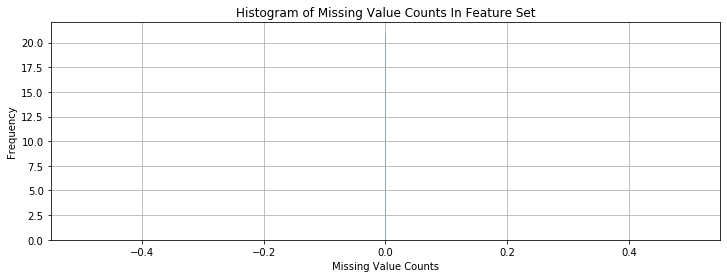

In [14]:
missing_count = td.isnull().sum()
#Plot a histogram of the missingness observed over all features in the dataset
ax = missing_count.hist(bins=num_rows,figsize=(12,4))
ax.set_xlabel("Missing Value Counts")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Missing Value Counts In Feature Set")

---
# Data Cleaning

### Remove instances (rows) with missing outcome values

In [15]:
print("Number of training instances in original dataset = ",num_rows)
td = td.dropna(axis=0,how='any',subset=[outcomeLabel])
print("Number of training instances after removing instances with missing endpoint = ",len(td))
diff = num_rows-len(td)
print("Number of instances removed = ", diff)
num_rows = len(td) #reassign value (if changed)
if diff > 0:
    data_changed = True
td.shape

Number of training instances in original dataset =  1600
Number of training instances after removing instances with missing endpoint =  1600
Number of instances removed =  0


(1600, 21)

In [16]:
#It's critical to reset the index after dropping rows to work with data frame later with pd.concat of separate columns
td = td.reset_index(drop=True)
td.shape
#Ensure Class variable is cast as an int
td[outcomeLabel] = td[outcomeLabel].astype(dtype='int64')
td.info()

(1600, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 21 columns):
N0       1600 non-null int64
N1       1600 non-null int64
N2       1600 non-null int64
N3       1600 non-null int64
N4       1600 non-null int64
N5       1600 non-null int64
N6       1600 non-null int64
N7       1600 non-null int64
N8       1600 non-null int64
N9       1600 non-null int64
N10      1600 non-null int64
N11      1600 non-null int64
N12      1600 non-null int64
N13      1600 non-null int64
N14      1600 non-null int64
N15      1600 non-null int64
M0P0     1600 non-null int64
M0P1     1600 non-null int64
M1P0     1600 non-null int64
M1P1     1600 non-null int64
Class    1600 non-null int64
dtypes: int64(21)
memory usage: 262.6 KB


In [17]:
#Confirm no missing values in outcome variable
na_percent = np.sum(td[outcomeLabel].isnull())/len(td[outcomeLabel])*100
if na_percent > 0:
    print(c,'\t\t% Missing(N/A) = ',np.sum(td[outcomeLabel].isnull())/len(td)*100)
else:
    print('No missing values found in: '+ str(outcomeLabel))

No missing values found in: Class


### Remove columns to be ignored in analysis

In [18]:
print("Number of columns in original dataset = ", num_cols)
td = td.drop(ignore_columns, axis=1)
print("Number of columns after removing ignored columns = ", len(td.columns))
diff = num_cols-len(td.columns)
print("Number of columns removed = ", diff)
num_cols = len(td.columns)
if diff > 0:
    data_changed = True
td.shape

Number of columns in original dataset =  21
Number of columns after removing ignored columns =  21
Number of columns removed =  0


(1600, 21)

### Assess class imbalance (assuming discrete outcome)

Counts of each class
1    800
0    800
Name: Class, dtype: int64


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Counts (Checking for Imbalance)')

(1600, 21)

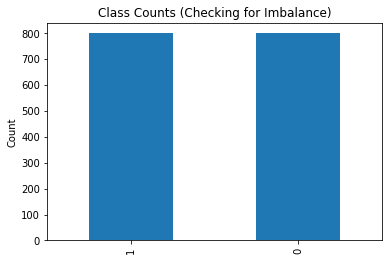

In [19]:
print("Counts of each class")
print(td[outcomeLabel].value_counts())
td[outcomeLabel].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
td.shape

### Identify categorical variables in dataset

In [20]:
if autoDetectCategorical:
    #Separate independent variables from the rest
    if instLabel == None or instLabel == 'None':
        x_data = td.drop([outcomeLabel], axis=1)
    else:
        x_data = quantitd.drop([outcomeLabel,instLabel], axis=1)

    categorical_variables = identifyCategoricalFeatures(x_data,categoricalCutoff)
    #print(categorical_variables)
    td.shape

(1600, 21)

---
# Example Code for other potential data cleaning/processing
- Not applied in this example script, but available here as an example

### Delete Rows/Instances with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [21]:
#num_rows = td.shape[0]
#print("Number of training instances in original dataset = ",num_rows)
#td = td.dropna()
#print("Number of training instances after removing instances with any missing values = ",td.shape[0])
#diff = num_rows-td.shape[0]
#if diff > 0:
#    data_changed = True

### Delete Columns with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [22]:
#num_cols = td.shape[1]
#print("Number of training instances in original dataset = ",num_cols)
#td = df.dropna(axis='columns')
#print("Number of training instances after removing instances with any missing values = ",td.shape[1])
#diff = num_cols-td.shape[1]
#if diff > 0:
#    data_changed = True

### One hot encoding of categorical variables
- Ensures that categorical variables are not treated in an ordinal manner by ML algorithms
- The code below is an example of how to convert a single column to one hot encoding, and is not meant to be run as is. 

In [23]:
## Example below assumes a data frame 'df' with a column called 'B'
#one_hot = pd.get_dummies(df['B'])
#df = df.drop('B',axis = 1)
#df = df.join(one_hot)

### Other possible cleaning steps:
- encode text values as numerics
- oversample or undersample to reduce class imbalance
- drop additional rows based on assigned cutoffs, etc
- cast variable types as nominal or ordinal
- construct missingness features with MissingIndicator: https://scikit-learn.org/stable/modules/impute.html

In [24]:
#Saved for later, determines if imputation attempted.
isMissingData = False
if td.isnull().values.any():
    isMissingData = True

## Save cleaned dataset if it has been modified

In [25]:
if data_changed:
    print('Saving cleaned data.')
    td.shape
    data_name = data_name +'_clean'
    td.to_csv(data_name+'.txt', index=None, sep='\t')

---
# Further Exploratory/Descriptive Analysis
- Visualize feature correlations in data
- Appropriate univariate analyses

## Feature Correlations

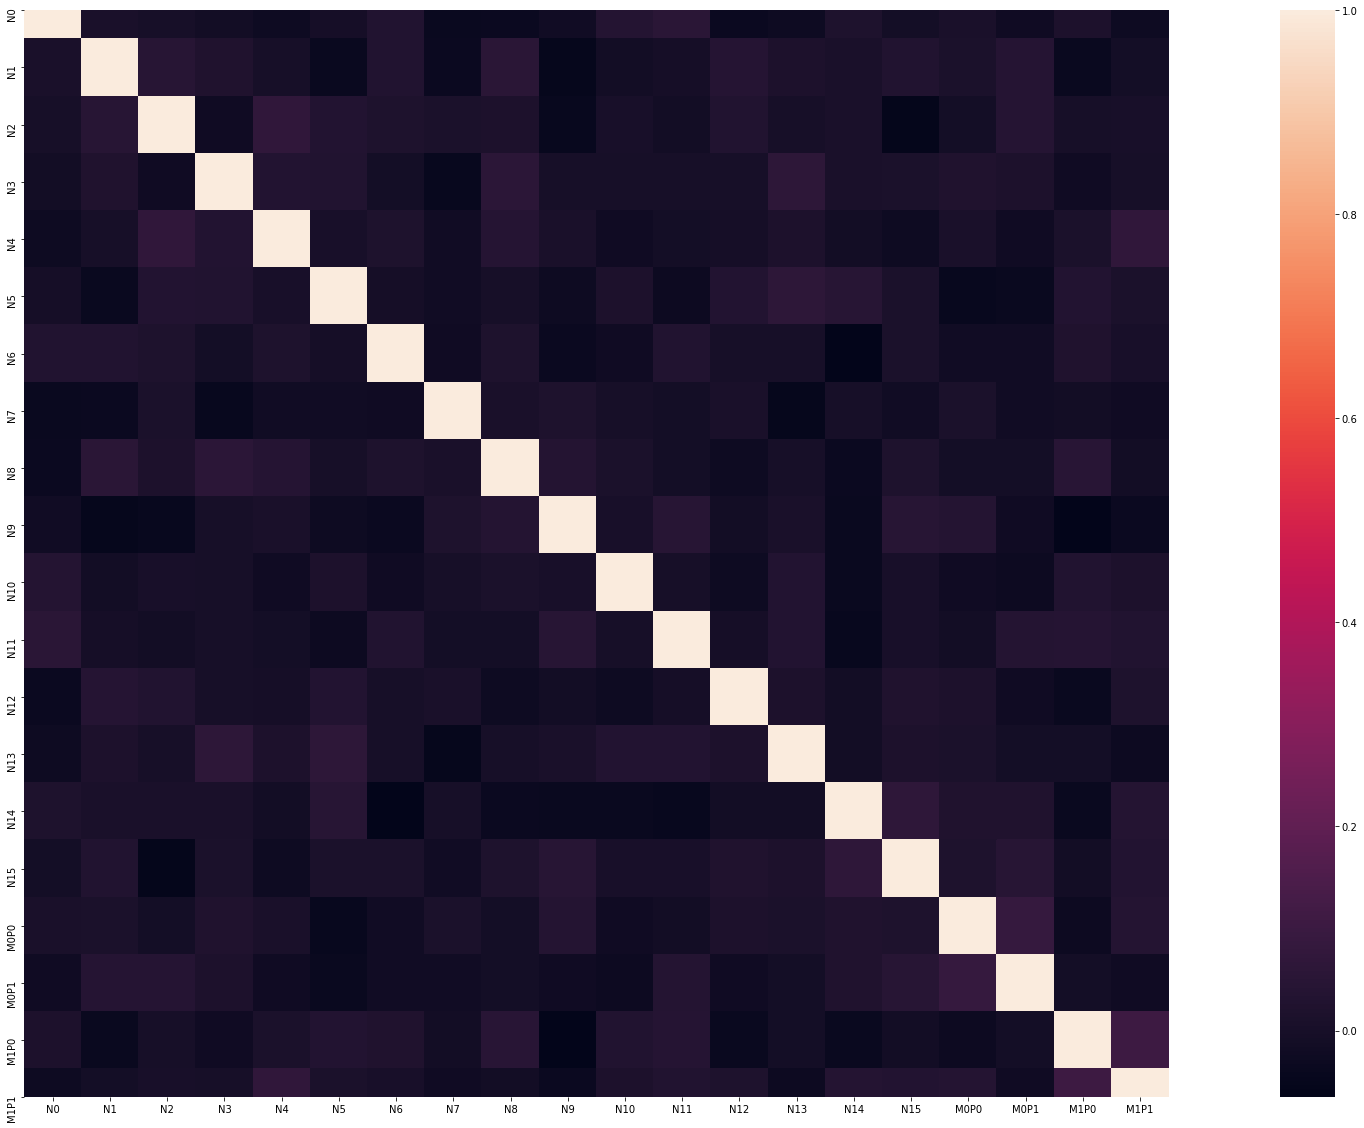

In [26]:
if doCorrelation:
    #Drop outcome column for correlation analysis
    td_cor = td.drop([outcomeLabel], axis=1)
    
    #Compute correlation between the outcome and each feature , excluding NA/null values.
    corrmat = td_cor.corr(method='pearson') 
    f, ax = plt.subplots(figsize = (40,20)) # Note: need large size
    sns.heatmap(corrmat, vmax =1.0,square = True) # Set max value and square-shaped


## Univariate Analysis and Plots
Below we have encoded a method to automatically select an appropriate plot and univariate association test between a single feature and the target outcome in the dataset.

In [27]:
# Code to analyze the univariate relationship between the outcome and each feature
def test_selector(featureName, outcomeLabel, td, categorical_variables):
    p_val = 0
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        
        #Univariate association test (Chi Square Test of Independence - Non-parametric)
        c, p, dof, expected = scs.chi2_contingency(table)
        p_val = p
        
    #Feature is continuous and Outcome is discrete/categorical/binary
    else: 
        #Univariate association test (Mann-Whitney Test - Non-parametric)
        c, p = scs.mannwhitneyu(x=td[featureName].loc[td[outcomeLabel] == 0],y=td[featureName].loc[td[outcomeLabel] == 1])
        p_val = p
        
    return p_val

In [28]:
# Function select appropriate visualizations to examine univariate relationships between each feature and outcome

def graph_selector(featureName, outcomeLabel, td, categorical_variables):
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Generate contingency table count bar plot. ------------------------------------------------------------------------
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        geom_bar_data = pd.DataFrame(table)
        mygraph = geom_bar_data.plot(kind='bar')
        plt.ylabel('Count')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Barplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight",format='png')
        plt.show()
        
    #Feature is continuous and Outcome is discrete/categorical/binary    
    else: 
        #Generate boxplot-----------------------------------------------------------------------------------------------------
        mygraph = td.boxplot(column=featureName,by=outcomeLabel)
        plt.ylabel(featureName)
        plt.title('')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Boxplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight",format='png')
        plt.show()

Plotting top significant 20 features.
###################################################
Significant Univariate Associations:
N12: (p-val = 0.056743397943177586)
N5: (p-val = 0.10947304211062434)
M0P1: (p-val = 0.1546095890022096)
N6: (p-val = 0.2159790679367283)
N2: (p-val = 0.23809669359454977)
M0P0: (p-val = 0.25587550643335555)
N9: (p-val = 0.26576003393967407)
M1P1: (p-val = 0.2835961295283351)
N15: (p-val = 0.30219013045235243)
N0: (p-val = 0.31996290514507847)
N3: (p-val = 0.3559295377623046)
N4: (p-val = 0.5597912327546358)
N1: (p-val = 0.5898635206050127)
N13: (p-val = 0.6063289199307874)
N10: (p-val = 0.712385559245169)
N14: (p-val = 0.7947315870349886)
M1P0: (p-val = 0.8079995828942341)
N11: (p-val = 0.8943938199328865)
N8: (p-val = 0.9106104129307089)
N7: (p-val = 0.988534609084064)


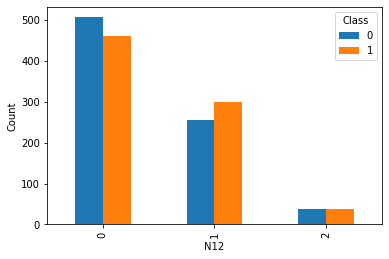

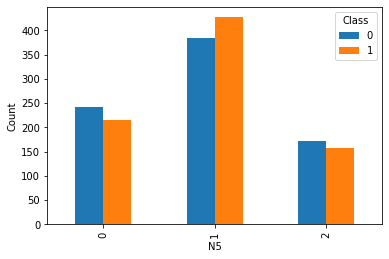

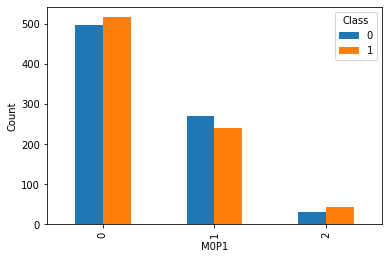

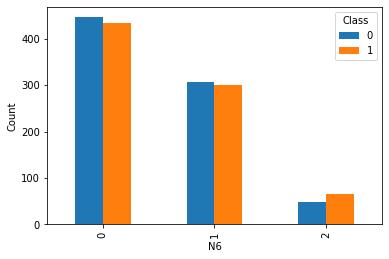

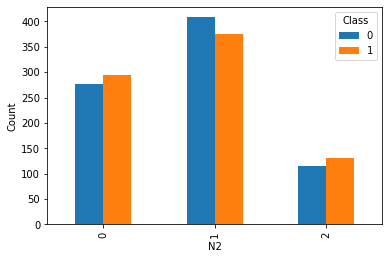

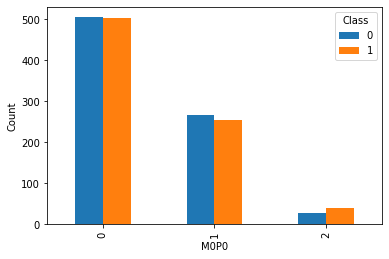

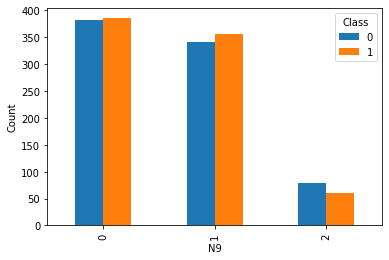

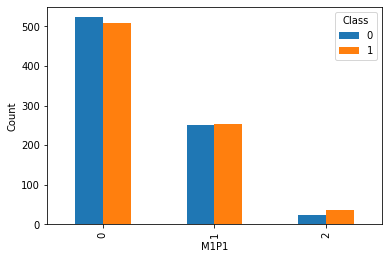

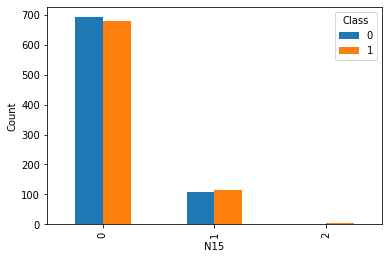

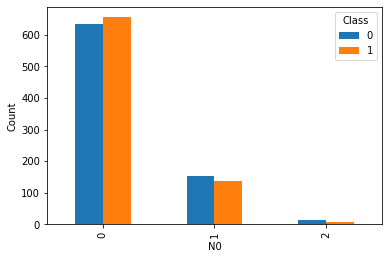

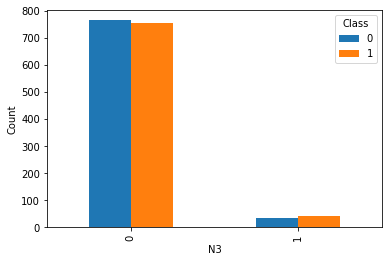

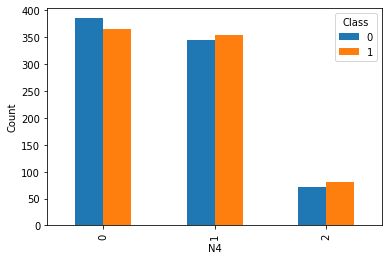

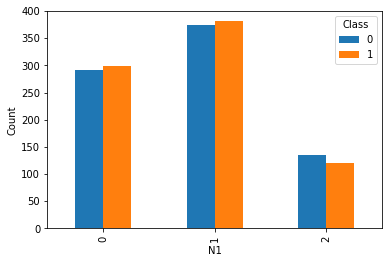

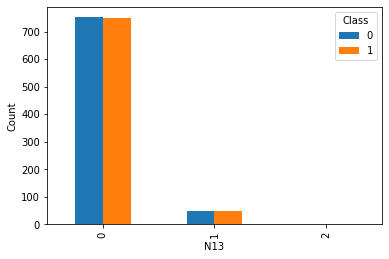

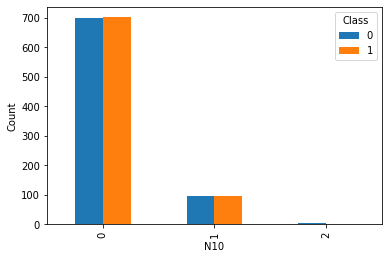

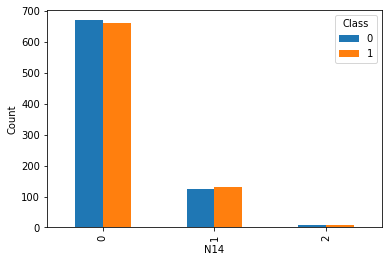

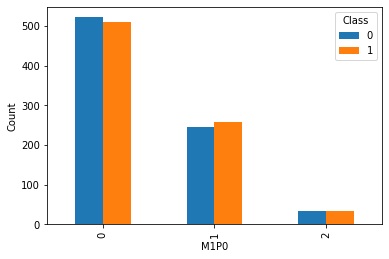

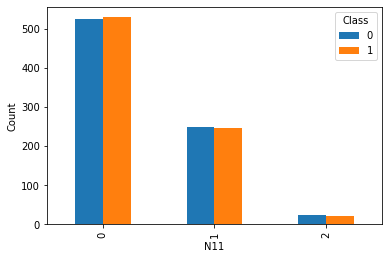

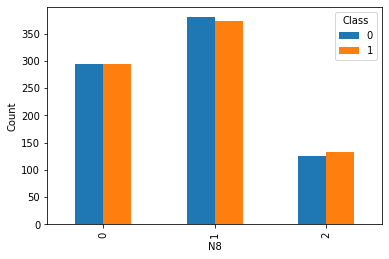

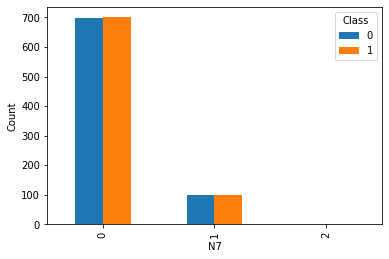

In [29]:
if doUA:
    p_val_dict = {}
    # run appropriate univariate association test for each independent variable
    for each in td:
        if each != outcomeLabel and each != instLabel: 
            p_val_dict[each] = test_selector(each, outcomeLabel, td, categorical_variables)
    
    num_features = td.shape[1] - 1
    
    sorted_p_list = sorted(p_val_dict.items(), key = lambda item:item[1])
    
    #Save all p-values to file
    pval_df = pd.DataFrame.from_dict(p_val_dict, orient='index')
    filepath = wd_path+ua_folder+'/'+'UA_Significance_'+data_name+'.csv'
    pval_df.to_csv(filepath, header=['p-value'], index=True)  
    
    min_num = min(topResults,num_features)
    sorted_p_list = sorted_p_list[: min_num]
    print('Plotting top significant '+ str(min_num) + ' features.')
    
    # summarize significant values of selected number of features
    print('###################################################')
    print('Significant Univariate Associations:')
    for each in sorted_p_list[:min_num]:
        print(each[0]+": (p-val = "+str(each[1]) +")")

    #generate appropriate descriptive plot for selected number of features
    for i in sorted_p_list:
        for j in td:
            if j == i[0]:# if the feature name is within the selected feature list
                graph_selector(j, outcomeLabel, td, categorical_variables) #plot appropriate figure for each feature

---
# Create n-fold Cross Validation (CV) Datasets 
- i.e. Training and Testing Datasets

In [30]:
#Create a header list of independant feature names
header = td.columns.values.tolist()
header.remove(outcomeLabel)
if instLabel != None and instLabel != 'None':
    header.remove(instLabel)

#Perform CV partitioning (get back list of training and testing partition dataframes)
train_dfs, test_dfs = cv_partitioner(td, cv_partitions, partition_method, outcomeLabel, categoricalOutcome, matchName, randomSeed)

if partition_method == 'M':
    header.remove(matchName)

Nominal Stratitifed Partitioning


---
# Transform data - Standard Scaling
- Features are independently scaled to allow them to be more comparable in downstream logistic regression modeling, etc
- Scaling is learned on the training data and saved with pickel so that the same scaling may be applied to any future testing data
- Completed within each training and testing partition independently

In [31]:
if scaleData:
    print('Scaling Data')
    data_name = data_name +'_scale'
    name_path = wd_path+model_folder+'/'+'Scalar_' + data_name+'_'
    train_dfs, test_dfs = dataScaling(train_dfs, test_dfs, outcomeLabel, instLabel, name_path, header)

Scaling Data


---
# Impute Missing Data Values
- Missing data values in categorical features are imputed with simple 'mode' imputation
- Remaining missing data values are imputed using Iterative Imputer (i.e. MICE) 
- Completed within each training and testing partition independently

In [32]:
if imputeData and isMissingData:
    print('Imputing Data')
    data_name = data_name + '_imp'
    train_dfs, test_dfs = imputeCVData(outcomeLabel, instLabel, categorical_variables, header, train_dfs, test_dfs, randomSeed)

### Confirm Missing Data Imputation

In [33]:
print("Training Datasets")
for each in train_dfs:
    each.isnull().sum().sum()

print("Testing Datasets")
for each in test_dfs:
    each.isnull().sum().sum()

Training Datasets


0

0

0

0

0

0

0

0

0

0

Testing Datasets


0

0

0

0

0

0

0

0

0

0

## Save Training and Testing Datasets as .txt Files

In [34]:
data_name = data_name+'_CV_'+str(partition_method)

counter = 0
for each in train_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Train.txt', index=None, sep='\t')
    counter += 1
    
counter = 0
for each in test_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Test.txt', index=None, sep='\t')
    counter += 1

---
# Load, Check, and Prepare Saved CV Datasets for ML

## Load CV Partition Datasets
Re-loads training and testing datasets from saved .txt files

In [35]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt', na_values='NA', sep = "\t")
    trainList.append(trainSet)
    
    #Load testing partition
    testSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt', na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Testing Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Testing Partitions: 10


#### Quality Control Check (Checking one of the partitions)
Merge the first training/testing datasets to confirm original dataset is reconstituted

In [36]:
#Confirm case/control counts when merging one training and testing dataset
classesTrain = trainList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTrain = len(classesTrain[classesTrain == True].index)
controlsTrain = len(classesTrain[classesTrain == False].index)

classesTest = testList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTest = len(classesTest[classesTest == True].index)
controlsTest = len(classesTest[classesTest == False].index)

print("Number of Cases in Original Dataset: "+str(casesTrain+casesTest))
print("Number of Controls in Original Dataset: "+str(controlsTrain+controlsTest))

Number of Cases in Original Dataset: 800
Number of Controls in Original Dataset: 800


In [37]:
#Confirm training and testing set dimensions
print("Training Set Dimensions: " + str(trainList[0].shape))
print("Testing Set Dimensions: " + str(testList[0].shape))
numColumns = trainList[0].shape[1]

Training Set Dimensions: (1440, 21)
Testing Set Dimensions: (160, 21)


## Partition Data Preprocessing
If present, remove instance id's from datasets prior to analysis. Also confirm that training and testing sets have same set of columns.

In [38]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [39]:
trainColumnNames = list(trainList[0])
testColumnNames = list(testList[0])

if not trainColumnNames == testColumnNames:
    print('Error: Training columns do not match testing columns!')

# As we can see, instLabel is no longer a column name for any of the sets
#print(trainColumnNames)
#print(testColumnNames)

#Create master list of feature names (excluding outcome column)
ordered_feature_names = copy.deepcopy(trainColumnNames) #Stores original ordered feature list 
ordered_feature_names.remove(outcomeLabel)
#ordered_feature_names

## Format data for Scikit learn (separate features from outcome)

In [40]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)

---
# Feature Importance Evaluation
- Completed independently within each training dataset

In [41]:
#Store indexes of 'interesting' features identified by each algorithm in algorithm labeled dictionary
selectedFeatureLists = {}
metaScoreDict = {}
metaFeatureRanks = {}

## Mutual information


Mutual Information Run Time: 2.669032096862793


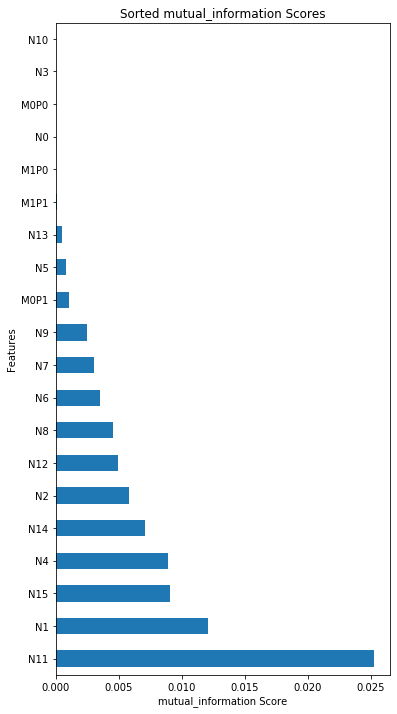

In [42]:
#Run Mutual Information for each CV------------------------------------------------------------------------------
algorithm = 'mutual_information'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    featureNameRanks = [] #list of feature name ranks for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_mi(xTrainList[i],yTrainList[i], i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    #cv_output_name = data_name+'_clean_imp_CV_'+partition_method
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('Mutual Information Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## MultiSURF


MultiSURF Run Time: 238.84040927886963


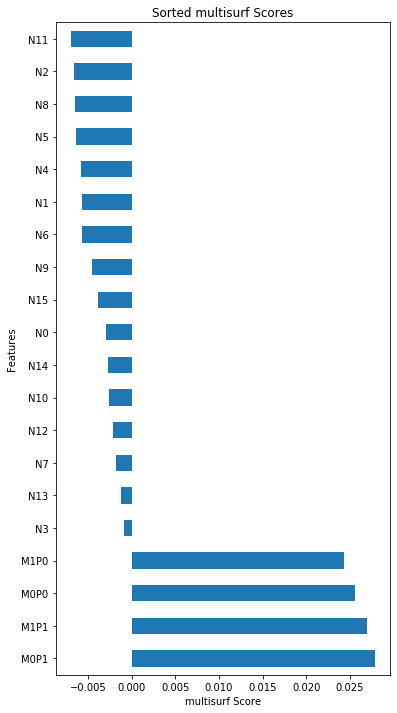

In [43]:

#Run MultiSURF for each CV------------------------------------------------------------------------------
algorithm = 'multisurf'
if algorithm in algorithms:
    start_time = time.time()
    
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #If training set is large MultiSURF will run very slowly - quadradic time complexity with # instances (so use subset)
        tempData = pd.concat([pd.DataFrame(yTrainList[i]),pd.DataFrame(xTrainList[i])], axis=1, sort=False)
        if len(tempData) < instanceSubset:
            dataSample = tempData.sample(n=len(tempData), axis = 0)
        else:
            dataSample = tempData.sample(n=instanceSubset, axis = 0)

        xTrain = dataSample.iloc[:, 1:].values
        yTrain = dataSample.iloc[:, 0].values
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_multisurf(xTrain,yTrain, i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('MultiSURF Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

---
# Feature Selection

## Identify union of 'interesting' features from different algorithms
- Operates no matter how many feature selection methods are being applied
- But assumes that all methods have larger scores as being more informative

In [44]:
cv_Selected_List = selectFeatures(algorithms, cv_partitions, selectedFeatureLists, maxFeaturesToKeep,metaFeatureRanks)

### Report counts of 'interesting' features identified by each algorithm

In [45]:
print('Original feature count: '+str(len(ordered_feature_names)))

for each in algorithms:
    print(each)
    for cv in selectedFeatureLists[each]:
        print(len(cv))
    
print("Selected Counts")
for each in cv_Selected_List:
    print(len(each))

Original feature count: 20
mutual_information
5
8
8
11
11
6
6
10
11
8
multisurf
4
4
4
4
4
4
4
4
4
4
Selected Counts
9
12
12
14
14
10
9
13
14
12


## Generate Filtered Datasets (Save as new .txt files)
- These datasets included only the selected features for each respective partition
- Note that the feature order from the original datasets is no longer preserved in these datasets

In [46]:
if filterPoorFeatures:
    genFilteredDatasets(cv_Selected_List, outcomeLabel, instLabel,cv_partitions,cv_data_folder,data_name)
    data_name = data_name +'_FS'

## Generate Filtered MultiSURF Files (Save as new .txt files)

In [47]:
if 'multisurf' in algorithms: #This method is only meant for working with MultiSURF scores
    if filterPoorFeatures:
        for i in range(cv_partitions):
            tempDict = scoreDictSet[i]

            #create new dictionary with only selected features
            scoreDict = {}
            for j in cv_Selected_List[i]:
                scoreDict[j] = tempDict[j]
            
            filename = output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
            sort_save_fs_fi_scores(scoreDict, 'multisurf', filename)

---
# Load, Check, and Prepare Filtered CV Datasets for ML
- If user opted not to filter datasets then the code below will simply reload the original CV datasets again.

## Load CV Partition Datasets (Filtered Datasets)

In [48]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
    trainSet = pd.read_csv(trainset_name, na_values='NA', sep = "\t")
    trainList.append(trainSet)

    #Load testing partition
    testset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
    testSet = pd.read_csv(testset_name, na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Testing Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Testing Partitions: 10


## CV partition data cleaning (Filtered Datasets)

In [49]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [50]:
global_ordered_features = [] #Holds the new order of features in the FS CV datasets
for i in range(cv_partitions):
    cv_ordered_features = list(trainList[i])
    cv_ordered_features.remove(outcomeLabel)
    #print(cv_ordered_features)
    global_ordered_features.append(cv_ordered_features)

## Format data for Scikit learn (filtered datasets)

In [51]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)


---
# Machine Learning Modeling
ML algorithms are run one after the other below. Within each we conduct a hyperparameter sweep, train a best model and evaluate it indendently within each CV training/testing partition. 
- All standard classification metrics are computed for the resulting models as well as an ROC curve and precision/recall curve

## Run Logistic Regression

Running logistic_regression
Best trial:
  Value:  0.5
  Params: 
    penalty: l1
    dual: False
    C: 0.020369494362621816
    solver: saga
    class_weight: None
    max_iter: 152.2634182918631
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5076388888888889
  Params: 
    penalty: l2
    dual: False
    C: 32147.193482816965
    solver: liblinear
    class_weight: balanced
    max_iter: 157.51320499779712
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5
  Params: 
    penalty: l1
    dual: False
    C: 0.020369494362621816
    solver: saga
    class_weight: None
    max_iter: 152.2634182918631
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5
  Params: 
    penalty: l1
    dual: False
    C: 0.020369494362621816
    solver: saga
    class_weight: None
    max_iter: 152.2634182918631
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5
  Params: 
    penalty: l1
    dual: False
    C: 0.020369494362621816
    solver: saga
    class_weight: None
    max_iter: 152.2634182918631
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5
  Params: 
    penalty: l1
    dual: False
    C: 0.020369494362621816
    solver: saga
    class_weight: None
    max_iter: 152.2634182918631
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5
  Params: 
    penalty: l1
    dual: False
    C: 0.020369494362621816
    solver: saga
    class_weight: None
    max_iter: 152.2634182918631
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5034722222222222
  Params: 
    penalty: l2
    dual: True
    C: 0.0009736974684895653
    solver: liblinear
    class_weight: None
    max_iter: 348.7712624545931
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.5201388888888888
  Params: 
    penalty: l2
    dual: False
    C: 0.0003630322466779861
    solver: liblinear
    class_weight: None
    max_iter: 539.948440978743
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.517361111111111
  Params: 
    penalty: l2
    dual: False
    C: 2.9285768980188992e-05
    solver: sag
    class_weight: balanced
    max_iter: 29.21074818565715
    n_jobs: -1


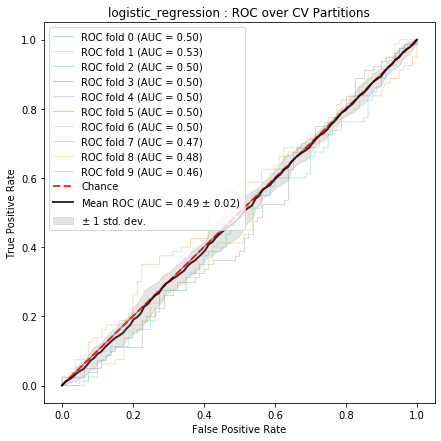

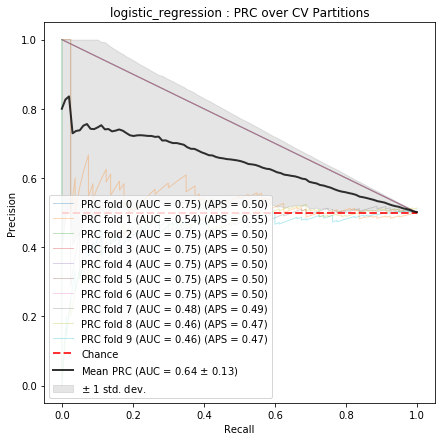

Avg. Model Balanced Accuracy = 0.495625 (std. dev. = 0.026523868967403687)
Avg. Model Accuracy = 0.495625 (std. dev. = 0.02652386896740368)
Avg. Model F1-Score = 0.4579100145137881 (std. dev. = 0.2456928508301242)
Avg. Model Recall = 0.5875 (std. dev. = 0.37906134068248115)
Avg. Model Specificity = 0.40374999999999994 (std. dev. = 0.37579291172133616)
Avg. Model Precision = 0.39516988674217185 (std. dev. = 0.19946241022137803)
Avg. Model True Positives = 47.0 (std. dev. = 30.32490725459849)
Avg. Model True Negatives = 32.3 (std. dev. = 30.0634329377069)
Avg. Model False Positives = 47.7 (std. dev. = 30.0634329377069)
Avg. Model False Negatives = 33.0 (std. dev. = 30.32490725459849)
Avg. ROC AUC = 0.4935625 (std. dev. = 0.018396478465235545)
Avg. PRC AUC = 0.6440900851208327 (std. dev. = 0.13157134384855207)
Avg. PRC Precision Score = 0.49669473440457307 (std. dev. = 0.021994029862494064)

---Feature Importances---



Names    Scores
19  M1P1  0.006250
11   N11  0.005625
12   N12  0.005000
16  M0P0  0.004375
1     N1  0.003750
2     N2  0.003125
4     N4  0.003125
15   N15  0.002500
8     N8  0.001875
17  M0P1  0.001875
9     N9  0.001875
13   N13  0.001250
18  M1P0  0.001250
14   N14  0.000625
0     N0  0.000000
7     N7  0.000000
6     N6  0.000000
5     N5  0.000000
3     N3  0.000000
10   N10  0.000000

Logistic Regression Run Time: 176.57083296775818


In [52]:
algorithm = 'logistic_regression'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Logistic Regression Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Decision Tree

Running decision_tree
Best trial:
  Value:  0.6909722222222222
  Params: 
    criterion: entropy
    splitter: random
    max_depth: 17
    min_samples_split: 44
    min_samples_leaf: 21
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6236111111111111
  Params: 
    criterion: gini
    splitter: best
    max_depth: 20
    min_samples_split: 42
    min_samples_leaf: 18
    max_features: None
    class_weight: None
Running decision_tree
Best trial:
  Value:  0.6236111111111111
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 23
    min_samples_split: 12
    min_samples_leaf: 11
    max_features: log2
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6493055555555555
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 21
    min_samples_split: 44
    min_samples_leaf: 19
    max_features: None
    class_weight: None
Running decision_tree
Best trial:
  Value:  0.6430555555555556
  Para

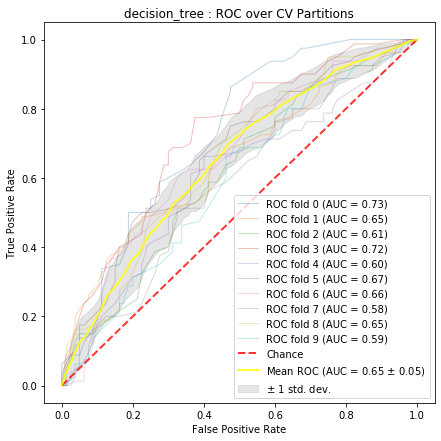

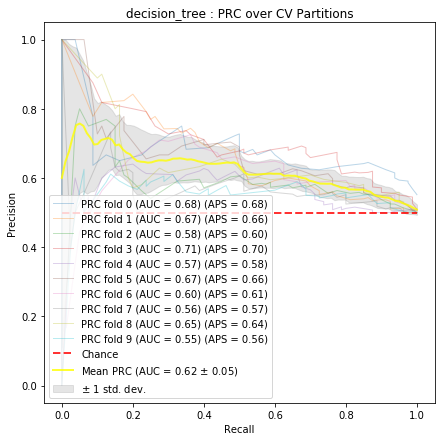

Avg. Model Balanced Accuracy = 0.6050000000000001 (std. dev. = 0.03820176697484033)
Avg. Model Accuracy = 0.6050000000000001 (std. dev. = 0.03820176697484033)
Avg. Model F1-Score = 0.5972505931695364 (std. dev. = 0.050652151323101705)
Avg. Model Recall = 0.59 (std. dev. = 0.07262919523166975)
Avg. Model Specificity = 0.62 (std. dev. = 0.04337337893224368)
Avg. Model Precision = 0.607381555698608 (std. dev. = 0.03617405043362748)
Avg. Model True Positives = 47.2 (std. dev. = 5.81033561853358)
Avg. Model True Negatives = 49.6 (std. dev. = 3.4698703145794942)
Avg. Model False Positives = 30.4 (std. dev. = 3.4698703145794942)
Avg. Model False Negatives = 32.8 (std. dev. = 5.81033561853358)
Avg. ROC AUC = 0.6468671875 (std. dev. = 0.04866187259280391)
Avg. PRC AUC = 0.6238790355196787 (std. dev. = 0.05480856320990643)
Avg. PRC Precision Score = 0.625638789824241 (std. dev. = 0.047346542815554886)

---Feature Importances---



Names    Scores
16  M0P0  0.255978
18  M1P0  0.236842
19  M1P1  0.130406
17  M0P1  0.095650
4     N4  0.042576
1     N1  0.040299
2     N2  0.040134
8     N8  0.032525
11   N11  0.029290
9     N9  0.029155
6     N6  0.019281
12   N12  0.014433
14   N14  0.014362
15   N15  0.008485
5     N5  0.007518
7     N7  0.001706
13   N13  0.001360
0     N0  0.000000
3     N3  0.000000
10   N10  0.000000

Decision Tree Run Time: 163.15084528923035


In [53]:
algorithm = 'decision_tree'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Decision Tree Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Random Forest

Running random_forest
Best trial:
  Value:  0.7180555555555556
  Params: 
    n_estimators: 366
    criterion: gini
    max_depth: 16
    min_samples_split: 4
    min_samples_leaf: 19
    max_features: None
    bootstrap: True
    oob_score: False
    n_jobs: -1
    class_weight: None
Running random_forest
Best trial:
  Value:  0.6923611111111111
  Params: 
    n_estimators: 999
    criterion: entropy
    max_depth: 28
    min_samples_split: 4
    min_samples_leaf: 13
    max_features: None
    bootstrap: True
    oob_score: True
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.7027777777777778
  Params: 
    n_estimators: 372
    criterion: gini
    max_depth: 13
    min_samples_split: 5
    min_samples_leaf: 25
    max_features: None
    bootstrap: True
    oob_score: True
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.7027777777777778
  Params: 
    n_estimators: 995
    criterion: entropy
    max_depth:

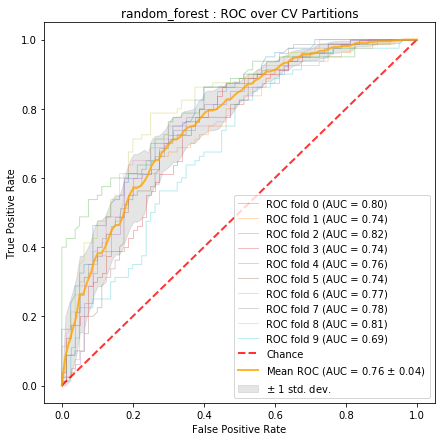

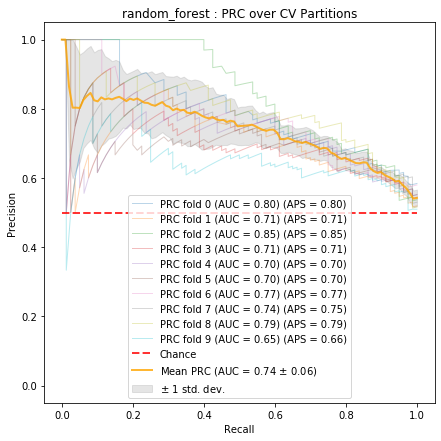

Avg. Model Balanced Accuracy = 0.69625 (std. dev. = 0.02727178028658927)
Avg. Model Accuracy = 0.6962499999999999 (std. dev. = 0.027271780286589282)
Avg. Model F1-Score = 0.6966171607830949 (std. dev. = 0.030315917281572832)
Avg. Model Recall = 0.69875 (std. dev. = 0.04273830249319689)
Avg. Model Specificity = 0.6937500000000001 (std. dev. = 0.032234492395569074)
Avg. Model Precision = 0.6954236799970903 (std. dev. = 0.02694099824938351)
Avg. Model True Positives = 55.9 (std. dev. = 3.419064199455752)
Avg. Model True Negatives = 55.5 (std. dev. = 2.5787593916455256)
Avg. Model False Positives = 24.5 (std. dev. = 2.5787593916455256)
Avg. Model False Negatives = 24.1 (std. dev. = 3.419064199455752)
Avg. ROC AUC = 0.764953125 (std. dev. = 0.036700863329636055)
Avg. PRC AUC = 0.740419848274511 (std. dev. = 0.05595250491296109)
Avg. PRC Precision Score = 0.7440700260667716 (std. dev. = 0.0543617895702339)

---Feature Importances---



Names    Scores
16  M0P0  0.197339
18  M1P0  0.175310
19  M1P1  0.148953
17  M0P1  0.146590
1     N1  0.052424
2     N2  0.044312
4     N4  0.041234
11   N11  0.038980
9     N9  0.034349
12   N12  0.031850
8     N8  0.028719
6     N6  0.018196
14   N14  0.014610
5     N5  0.011651
15   N15  0.011041
7     N7  0.003356
13   N13  0.001087
0     N0  0.000000
3     N3  0.000000
10   N10  0.000000

Random Forest Run Time: 1865.3773083686829


In [54]:
algorithm = 'random_forest'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Random Forest Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Naive Bayes

Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes


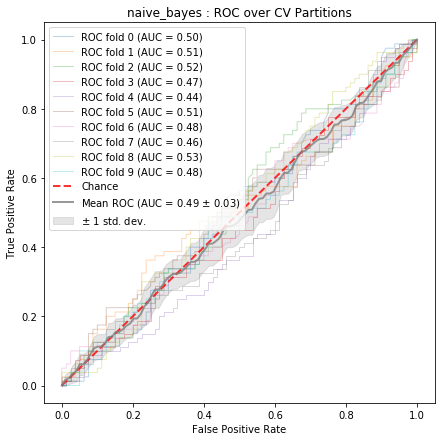

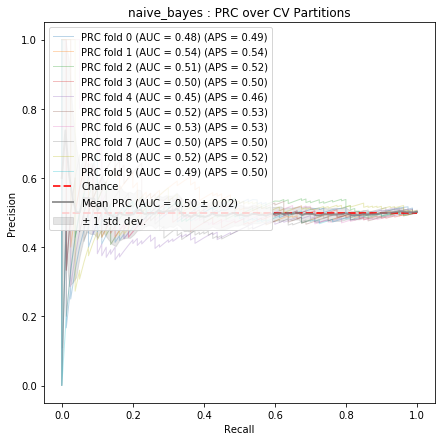

Avg. Model Balanced Accuracy = 0.49625 (std. dev. = 0.03077133406272794)
Avg. Model Accuracy = 0.49625 (std. dev. = 0.030771334062727928)
Avg. Model F1-Score = 0.4332196106051258 (std. dev. = 0.03805043099336157)
Avg. Model Recall = 0.38625000000000004 (std. dev. = 0.043821370357395265)
Avg. Model Specificity = 0.60625 (std. dev. = 0.05569167352486365)
Avg. Model Precision = 0.49599672196095596 (std. dev. = 0.039300984534766485)
Avg. Model True Positives = 30.9 (std. dev. = 3.505709628591621)
Avg. Model True Negatives = 48.5 (std. dev. = 4.455333881989093)
Avg. Model False Positives = 31.5 (std. dev. = 4.455333881989093)
Avg. Model False Negatives = 49.1 (std. dev. = 3.505709628591621)
Avg. ROC AUC = 0.48948437499999997 (std. dev. = 0.026891759854031007)
Avg. PRC AUC = 0.502925847123734 (std. dev. = 0.023990272398725164)
Avg. PRC Precision Score = 0.5101994489969239 (std. dev. = 0.022566558014320354)

---Feature Importances---



Names    Scores
19  M1P1  0.019375
12   N12  0.013125
15   N15  0.012500
16  M0P0  0.010000
17  M0P1  0.008750
18  M1P0  0.007500
2     N2  0.006250
14   N14  0.005000
7     N7  0.004375
8     N8  0.004375
9     N9  0.003750
1     N1  0.003750
11   N11  0.003125
6     N6  0.002500
5     N5  0.001875
4     N4  0.001250
13   N13  0.000625
0     N0  0.000000
3     N3  0.000000
10   N10  0.000000

Naive Bayes Run Time: 1.690755844116211


In [55]:
algorithm = 'naive_bayes'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Naive Bayes Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run XGBoost

Running XGB
Best trial:
  Value:  0.7263888888888889
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.000688289132142573
    alpha: 1.3751123264956037e-05
    eta: 0.15902058344825443
    gamma: 0.0009582576015885176
    max_depth: 27
    grow_policy: lossguide
    n_estimators: 329
    min_samples_split: 39
    min_samples_leaf: 26
    subsample: 0.746403860068859
    min_child_weight: 7.185602022647103
    colsample_bytree: 0.253281828171251
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.7250000000000001
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.004961523055376884
    alpha: 0.0016757639860783614
    eta: 0.26966803079986795
    gamma: 0.007696292707813898
    max_depth: 3
    grow_policy: depthwise
    n_estimators: 195
    min_samples_split: 9
    min_samples_leaf: 45
    subsample: 0.5806478687062933
    min_child_weight: 9.322363024373812
    colsample_bytree: 0.8722610328618966
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.7243055555555555
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.00995634131633428
    alpha: 0.022516090587451826
    eta: 0.00011940275427983441
    gamma: 0.9968985311370995
    max_depth: 17
    grow_policy: lossguide
    n_estimators: 851
    min_samples_split: 15
    min_samples_leaf: 25
    subsample: 0.547859401404113
    min_child_weight: 8.98098914907916
    colsample_bytree: 0.31139346334916007
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.7166666666666667
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.04505896729025864
    alpha: 0.037940998897957795
    eta: 3.480348983120959e-05
    gamma: 0.034056068084441116
    max_depth: 21
    grow_policy: lossguide
    n_estimators: 774
    min_samples_split: 9
    min_samples_leaf: 26
    subsample: 0.5137747725451051
    min_child_weight: 9.94870124825129
    colsample_bytree: 0.6076683655464459
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.71875
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0962314650374974
    alpha: 1.3740684619804751e-05
    eta: 0.9664975813734721
    gamma: 5.2216998085498576e-08
    max_depth: 8
    grow_policy: lossguide
    n_estimators: 412
    min_samples_split: 13
    min_samples_leaf: 43
    subsample: 0.7816342737345611
    min_child_weight: 7.793909929401804
    colsample_bytree: 0.3069082983547953
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.7180555555555556
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 7.632740653323751e-06
    alpha: 2.1892863317310355e-07
    eta: 1.0846456256924434e-08
    gamma: 0.0028134815029319457
    max_depth: 18
    grow_policy: depthwise
    n_estimators: 724
    min_samples_split: 19
    min_samples_leaf: 38
    subsample: 0.9394667132651512
    min_child_weight: 8.173051798512377
    colsample_bytree: 0.37413220575532863
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.7173611111111112
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 1.6285917649555056e-07
    alpha: 3.220135709008233e-08
    eta: 1.145603612717152e-06
    gamma: 7.045210531643853e-07
    max_depth: 12
    grow_policy: depthwise
    n_estimators: 438
    min_samples_split: 17
    min_samples_leaf: 45
    subsample: 0.6413756340896968
    min_child_weight: 9.835869937553849
    colsample_bytree: 0.28729736105560044
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.7062500000000002
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.05523992258982833
    alpha: 0.0001487914696693589
    eta: 5.662698313403888e-07
    gamma: 0.0019521229436791463
    max_depth: 4
    grow_policy: lossguide
    n_estimators: 202
    min_samples_split: 10
    min_samples_leaf: 48
    subsample: 0.6727077586462633
    min_child_weight: 8.861778953399694
    colsample_bytree: 0.9233875343093458
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.7090277777777777
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 9.481069579376301e-05
    alpha: 0.26302795747906305
    eta: 2.3089705511302838e-08
    gamma: 0.0005683245254160306
    max_depth: 16
    grow_policy: lossguide
    n_estimators: 604
    min_samples_split: 18
    min_samples_leaf: 19
    subsample: 0.5498606016441357
    min_child_weight: 9.877505497518134
    colsample_bytree: 0.3779889135711718
    scale_pos_weight: 1.0



Running XGB
Best trial:
  Value:  0.7159722222222222
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.05666422176181504
    alpha: 0.007664042866196048
    eta: 1.1151206300242806e-07
    gamma: 0.02410516594823798
    max_depth: 23
    grow_policy: depthwise
    n_estimators: 647
    min_samples_split: 10
    min_samples_leaf: 14
    subsample: 0.5539138246784547
    min_child_weight: 8.752961331055882
    colsample_bytree: 0.3407897751529208
    scale_pos_weight: 1.0


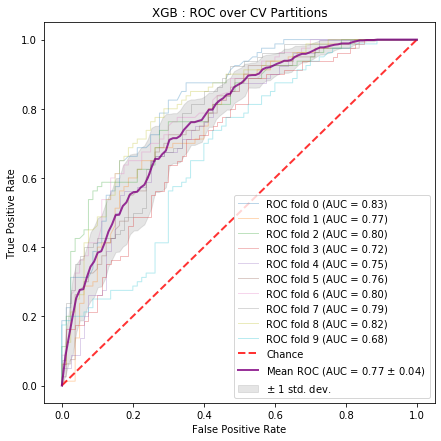

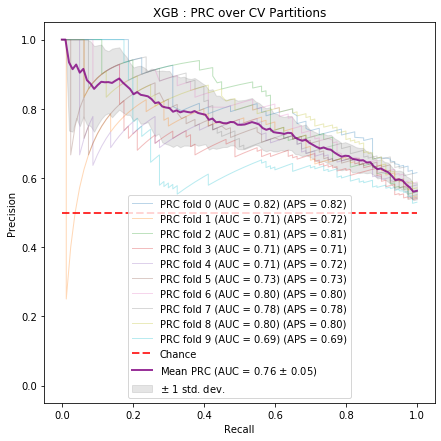

Avg. Model Balanced Accuracy = 0.6987500000000001 (std. dev. = 0.03577272005313544)
Avg. Model Accuracy = 0.6987500000000001 (std. dev. = 0.035772720053135455)
Avg. Model F1-Score = 0.6961165888461307 (std. dev. = 0.040403823942268234)
Avg. Model Recall = 0.6925000000000001 (std. dev. = 0.05706356105256662)
Avg. Model Specificity = 0.7050000000000001 (std. dev. = 0.040388736053508775)
Avg. Model Precision = 0.7014698944083839 (std. dev. = 0.035696920677940364)
Avg. Model True Positives = 55.4 (std. dev. = 4.565084884205331)
Avg. Model True Negatives = 56.4 (std. dev. = 3.2310988842807022)
Avg. Model False Positives = 23.6 (std. dev. = 3.2310988842807022)
Avg. Model False Negatives = 24.6 (std. dev. = 4.565084884205331)
Avg. ROC AUC = 0.7733359375 (std. dev. = 0.042933366823676974)
Avg. PRC AUC = 0.755768412064492 (std. dev. = 0.048015089126877186)
Avg. PRC Precision Score = 0.7585433297853241 (std. dev. = 0.04718223234421765)

---Feature Importances---



Names    Scores
19  M1P1  0.063750
16  M0P0  0.063125
17  M0P1  0.063125
18  M1P0  0.055000
15   N15  0.005000
11   N11  0.004375
12   N12  0.003750
4     N4  0.003750
14   N14  0.003125
8     N8  0.001875
7     N7  0.001875
9     N9  0.001875
6     N6  0.001875
1     N1  0.001250
13   N13  0.001250
0     N0  0.000000
5     N5  0.000000
3     N3  0.000000
2     N2  0.000000
10   N10  0.000000

XGBoost Run Time: 1895.3840970993042


In [56]:
algorithm = 'XGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('XGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LGBoost

Running LGB
Best trial:
  Value:  0.7284722222222223
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 238
    max_depth: 16
    lambda_l1: 0.009675482846883464
    lambda_l2: 9.867608536434945
    feature_fraction: 0.8785363759819029
    bagging_fraction: 0.6135181586749773
    bagging_freq: 6
    min_child_samples: 85
    n_estimators: 708
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7270833333333333
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 123
    max_depth: 11
    lambda_l1: 0.0034080544400670217
    lambda_l2: 9.24409596703419e-06
    feature_fraction: 0.8509365886492533
    bagging_fraction: 0.6385360433653772
    bagging_freq: 5
    min_child_samples: 98
    n_estimators: 883
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7256944444444445
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 166
    max_depth: 30
    lambda_l1: 0.0007407906080984927
    lambda_l2: 5.670756911950406
    feature_fraction: 0.6556877768192828
    bagging_fraction: 0.6342892805138008
    bagging_freq: 2
    min_child_samples: 72
    n_estimators: 358
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7263888888888888
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 143
    max_depth: 28
    lambda_l1: 1.370156834069055e-07
    lambda_l2: 3.0928048002753076e-07
    feature_fraction: 0.713441512123543
    bagging_fraction: 0.6022761740759442
    bagging_freq: 2
    min_child_samples: 80
    n_estimators: 311
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7173611111111112
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 32
    max_depth: 12
    lambda_l1: 0.009994039412790293
    lambda_l2: 5.2420330857876025e-05
    feature_fraction: 0.9395616445685054
    bagging_fraction: 0.5784862015185503
    bagging_freq: 5
    min_child_samples: 84
    n_estimators: 574
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7208333333333333
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 53
    max_depth: 29
    lambda_l1: 0.5011675718199278
    lambda_l2: 3.326183204878926e-06
    feature_fraction: 0.7241625277447208
    bagging_fraction: 0.7536371417304408
    bagging_freq: 3
    min_child_samples: 96
    n_estimators: 710
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7250000000000001
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 130
    max_depth: 26
    lambda_l1: 9.81989713552179e-07
    lambda_l2: 0.006693830569870984
    feature_fraction: 0.662825384986332
    bagging_fraction: 0.7185726549109346
    bagging_freq: 5
    min_child_samples: 98
    n_estimators: 331
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7166666666666667
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 239
    max_depth: 13
    lambda_l1: 0.1766835377355122
    lambda_l2: 0.2684925219450607
    feature_fraction: 0.8367451980712094
    bagging_fraction: 0.5521291671504823
    bagging_freq: 7
    min_child_samples: 75
    n_estimators: 409
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7131944444444445
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 131
    max_depth: 27
    lambda_l1: 0.020628156585558388
    lambda_l2: 1.6452027117602086e-05
    feature_fraction: 0.8660687967510058
    bagging_fraction: 0.8153604729593501
    bagging_freq: 1
    min_child_samples: 71
    n_estimators: 214
    scale_pos_weight: 1.0



Running LGB
Best trial:
  Value:  0.7277777777777779
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 28
    max_depth: 14
    lambda_l1: 0.0001457115284503784
    lambda_l2: 0.000155741313161579
    feature_fraction: 0.9086034072142761
    bagging_fraction: 0.5967236268859583
    bagging_freq: 3
    min_child_samples: 85
    n_estimators: 161
    scale_pos_weight: 1.0


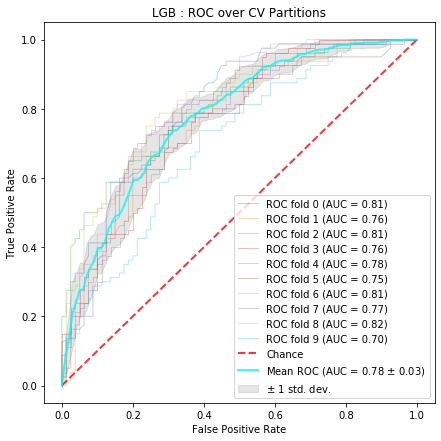

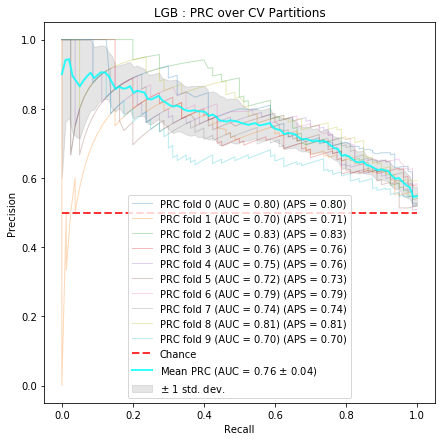

Avg. Model Balanced Accuracy = 0.7074999999999999 (std. dev. = 0.029421505739849526)
Avg. Model Accuracy = 0.7074999999999999 (std. dev. = 0.02942150573984953)
Avg. Model F1-Score = 0.7058892197242022 (std. dev. = 0.03589496874420743)
Avg. Model Recall = 0.705 (std. dev. = 0.05623610939600996)
Avg. Model Specificity = 0.7099999999999999 (std. dev. = 0.03201562118716424)
Avg. Model Precision = 0.708447451209848 (std. dev. = 0.02572258606047114)
Avg. Model True Positives = 56.4 (std. dev. = 4.498888751680797)
Avg. Model True Negatives = 56.8 (std. dev. = 2.5612496949731396)
Avg. Model False Positives = 23.2 (std. dev. = 2.5612496949731396)
Avg. Model False Negatives = 23.6 (std. dev. = 4.498888751680797)
Avg. ROC AUC = 0.77775 (std. dev. = 0.033954724853012)
Avg. PRC AUC = 0.7591650458754071 (std. dev. = 0.04305961790265202)
Avg. PRC Precision Score = 0.7622448671175902 (std. dev. = 0.041550842599971376)

---Feature Importances---



Names    Scores
17  M0P1  0.070625
18  M1P0  0.061875
16  M0P0  0.061250
19  M1P1  0.056875
2     N2  0.007500
1     N1  0.006875
15   N15  0.003750
14   N14  0.003125
5     N5  0.002500
7     N7  0.002500
11   N11  0.002500
4     N4  0.002500
9     N9  0.002500
12   N12  0.001875
6     N6  0.001250
8     N8  0.001250
0     N0  0.000000
13   N13  0.000000
3     N3  0.000000
10   N10  0.000000

LGBoost Run Time: 527.0324597358704


In [57]:
algorithm = 'LGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
        
    elapsed_time = time.time() - start_time
    print('LGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run SVM

Running SVM
Best trial:
  Value:  0.7076388888888889
  Params: 
    kernel: rbf
    C: 1.8699425976152275
    gamma: scale
    degree: 4
    probability: True
    class_weight: None



Running SVM
Best trial:
  Value:  0.6909722222222223
  Params: 
    kernel: rbf
    C: 0.7078454626038914
    gamma: scale
    degree: 1
    probability: True
    class_weight: None



Running SVM
Best trial:
  Value:  0.7000000000000001
  Params: 
    kernel: poly
    C: 16.577929133646812
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6701388888888888
  Params: 
    kernel: rbf
    C: 2.4803989102456767
    gamma: scale
    degree: 6
    probability: True
    class_weight: None



Running SVM
Best trial:
  Value:  0.7118055555555557
  Params: 
    kernel: poly
    C: 3.9996986355472033
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7069444444444445
  Params: 
    kernel: poly
    C: 2.2111422329904946
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7097222222222223
  Params: 
    kernel: poly
    C: 71.9715199880424
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.69375
  Params: 
    kernel: poly
    C: 107.19694375053017
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6881944444444444
  Params: 
    kernel: poly
    C: 1.0641769778630175
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.7041666666666666
  Params: 
    kernel: poly
    C: 568.311124279006
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced


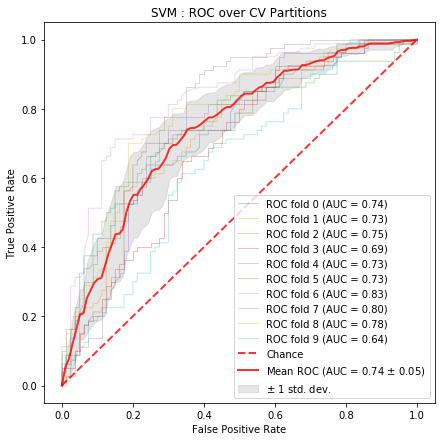

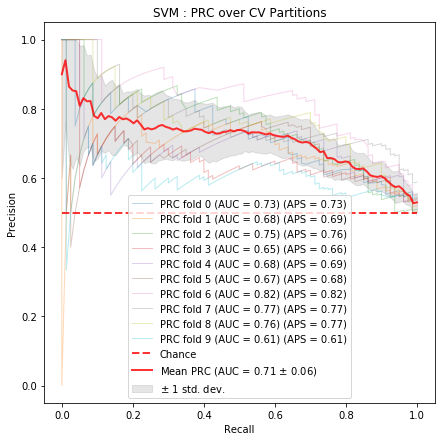

Avg. Model Balanced Accuracy = 0.690625 (std. dev. = 0.03657718722099879)
Avg. Model Accuracy = 0.6906249999999999 (std. dev. = 0.03657718722099884)
Avg. Model F1-Score = 0.6873882772850811 (std. dev. = 0.04197936334561192)
Avg. Model Recall = 0.6825 (std. dev. = 0.054829280498653266)
Avg. Model Specificity = 0.69875 (std. dev. = 0.032811011871016704)
Avg. Model Precision = 0.6933032186969592 (std. dev. = 0.034164147342999815)
Avg. Model True Positives = 54.6 (std. dev. = 4.386342439892262)
Avg. Model True Negatives = 55.9 (std. dev. = 2.6248809496813377)
Avg. Model False Positives = 24.1 (std. dev. = 2.6248809496813377)
Avg. Model False Negatives = 25.4 (std. dev. = 4.386342439892262)
Avg. ROC AUC = 0.7420000000000001 (std. dev. = 0.051227941613470315)
Avg. PRC AUC = 0.7131877538873864 (std. dev. = 0.06223387968167216)
Avg. PRC Precision Score = 0.7173335579892257 (std. dev. = 0.06060200880828141)

---Feature Importances---



Names    Scores
17  M0P1  0.055625
16  M0P0  0.054375
18  M1P0  0.047500
19  M1P1  0.045625
2     N2  0.004375
12   N12  0.003750
7     N7  0.003125
1     N1  0.002500
15   N15  0.001875
4     N4  0.001875
11   N11  0.001875
8     N8  0.001250
14   N14  0.000625
6     N6  0.000625
0     N0  0.000000
13   N13  0.000000
9     N9  0.000000
5     N5  0.000000
3     N3  0.000000
10   N10  0.000000

SVM Run Time: 2071.1873693466187


In [58]:
algorithm = 'SVM'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('SVM Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run ANN

Running ANN
Best trial:
  Value:  0.7236111111111111
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.2237123055626818
    solver: adam
    batch_size: auto
    alpha: 0.02511977360799186
    max_iter: 200
    n_layers: 1
    n_units_l0: 62



Running ANN
Best trial:
  Value:  0.7125
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.2130526380717236
    solver: adam
    batch_size: auto
    alpha: 0.0015113478842115444
    max_iter: 200
    n_layers: 1
    n_units_l0: 18



Running ANN
Best trial:
  Value:  0.7194444444444444
  Params: 
    activation: relu
    learning_rate: constant
    momentum: 0.48948426256939276
    solver: adam
    batch_size: auto
    alpha: 0.004402346876636895
    max_iter: 200
    n_layers: 1
    n_units_l0: 45



Running ANN
Best trial:
  Value:  0.7083333333333334
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.35813711611637933
    solver: adam
    batch_size: auto
    alpha: 0.035822850541464515
    max_iter: 200
    n_layers: 1
    n_units_l0: 72



Running ANN
Best trial:
  Value:  0.7138888888888889
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.24331712055419955
    solver: adam
    batch_size: auto
    alpha: 0.0012511137527206242
    max_iter: 200
    n_layers: 1
    n_units_l0: 36



Running ANN
Best trial:
  Value:  0.7138888888888889
  Params: 
    activation: relu
    learning_rate: adaptive
    momentum: 0.8488545516323157
    solver: adam
    batch_size: auto
    alpha: 0.018525832961072616
    max_iter: 200
    n_layers: 1
    n_units_l0: 28



Running ANN
Best trial:
  Value:  0.7125
  Params: 
    activation: relu
    learning_rate: constant
    momentum: 0.23112581388149595
    solver: adam
    batch_size: auto
    alpha: 0.0001614862812577833
    max_iter: 200
    n_layers: 1
    n_units_l0: 46



Running ANN
Best trial:
  Value:  0.7006944444444444
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.10085124492775771
    solver: adam
    batch_size: auto
    alpha: 0.00043150220294769847
    max_iter: 200
    n_layers: 1
    n_units_l0: 24



Running ANN
Best trial:
  Value:  0.6965277777777779
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.5998621930135135
    solver: adam
    batch_size: auto
    alpha: 0.02426784797036426
    max_iter: 200
    n_layers: 1
    n_units_l0: 21



Running ANN
Best trial:
  Value:  0.7201388888888888
  Params: 
    activation: tanh
    learning_rate: adaptive
    momentum: 0.47187300761284545
    solver: adam
    batch_size: auto
    alpha: 0.0008307768742858182
    max_iter: 200
    n_layers: 1
    n_units_l0: 43


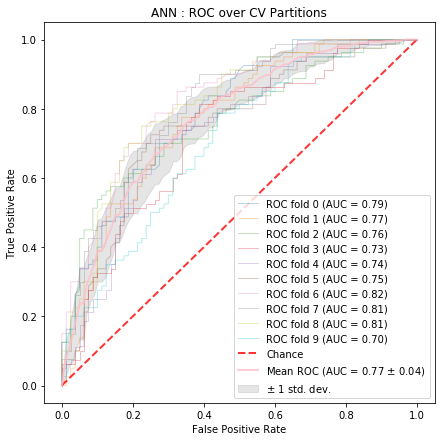

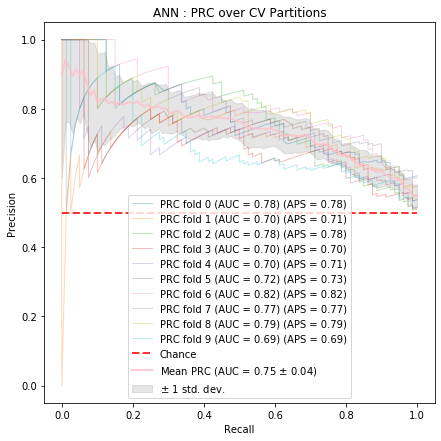

Avg. Model Balanced Accuracy = 0.7049999999999998 (std. dev. = 0.03351771919447979)
Avg. Model Accuracy = 0.705 (std. dev. = 0.033517719194479816)
Avg. Model F1-Score = 0.7048970217904217 (std. dev. = 0.036386823701431294)
Avg. Model Recall = 0.7062499999999999 (std. dev. = 0.04976507309348594)
Avg. Model Specificity = 0.7037500000000001 (std. dev. = 0.03954823004889094)
Avg. Model Precision = 0.7047852953159481 (std. dev. = 0.03371520954682327)
Avg. Model True Positives = 56.5 (std. dev. = 3.9812058474788765)
Avg. Model True Negatives = 56.3 (std. dev. = 3.1638584039112754)
Avg. Model False Positives = 23.7 (std. dev. = 3.163858403911275)
Avg. Model False Negatives = 23.5 (std. dev. = 3.9812058474788765)
Avg. ROC AUC = 0.7694062500000001 (std. dev. = 0.037717714360264464)
Avg. PRC AUC = 0.7452472809271723 (std. dev. = 0.044513987612544506)
Avg. PRC Precision Score = 0.7488029122292742 (std. dev. = 0.04331162022623348)

---Feature Importances---



Names    Scores
16  M0P0  0.072500
17  M0P1  0.071250
18  M1P0  0.066250
19  M1P1  0.065000
1     N1  0.008750
11   N11  0.008125
2     N2  0.006250
14   N14  0.005625
4     N4  0.005625
12   N12  0.005625
9     N9  0.005000
6     N6  0.005000
15   N15  0.004375
8     N8  0.003750
13   N13  0.002500
5     N5  0.001250
0     N0  0.000000
7     N7  0.000000
3     N3  0.000000
10   N10  0.000000

ANN Run Time: 1634.722306728363


In [59]:
algorithm = 'ANN'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('ANN Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LCS

In [60]:
def makeConfigFile(train_dataset,test_dataset,outpath,external_ek_file,iterations,popsize,configfile,outcomelabel,instancelabel,discthresh):
    """ Construct Configuration File for CV Analysis """
    configFile = open(configfile,'w')
    
    #Write to Config File#############################################################################################################
    configFile.write('offlineData=1# \n')
    configFile.write('trainFile='+str(train_dataset)+'# \n')
    configFile.write('testFile='+str(test_dataset)+'# \n')
    configFile.write('internalCrossValidation=0# \n')
    
    configFile.write('outFileName='+str(outpath)+'# \n')
    configFile.write('randomSeed=1# \n')
    configFile.write('labelInstanceID='+str(instancelabel)+'# \n')
    configFile.write('labelPhenotype='+str(outcomelabel)+'# \n')
    configFile.write('discreteAttributeLimit='+str(discthresh)+'# \n')
    configFile.write('labelMissingData=NA# \n')
    configFile.write('outputSummary=1# \n')
    configFile.write('outputPopulation=1# \n')
    configFile.write('outputAttCoOccur=1# \n')
    configFile.write('outputTestPredictions=1# \n')  
    configFile.write('maxAttsCoOccur=50# \n')
        
    configFile.write('trackingFrequency=0# \n')
    configFile.write('learningIterations='+str(iterations)+'# \n')
    
    configFile.write('N='+str(popsize)+'# \n') 
    configFile.write('nu=1# \n')
    configFile.write('chi=0.8# \n')
    configFile.write('upsilon=0.04# \n')
    configFile.write('theta_GA=25# \n')
    configFile.write('theta_del=20# \n')   
    configFile.write('theta_sub=20# \n')    
    configFile.write('acc_sub=0.99# \n')    
    configFile.write('beta=0.2# \n')         
    configFile.write('delta=0.1# \n')     
    configFile.write('init_fit=0.01# \n')
    configFile.write('fitnessReduction=0.1# \n')
    configFile.write('theta_sel=0.5# \n')
    configFile.write('RSL_Override=0# \n')

    configFile.write('doSubsumption=1# \n')
    configFile.write('selectionMethod=tournament# \n')
    
    configFile.write('doAttributeTracking=1# \n')
    configFile.write('doAttributeFeedback=1# \n')
    
    configFile.write('useExpertKnowledge=1# \n')
    configFile.write('external_EK_Generation='+str(external_ek_file)+'# \n')
    configFile.write('outEKFileName=None# \n')
    
    configFile.write('filterAlgorithm=None# \n')
    configFile.write('turfPercent=0.2# \n')
    configFile.write('reliefNeighbors=10# \n')
    configFile.write('reliefSampleFraction=1# \n')
    configFile.write('onlyEKScores=0# \n')
    
    configFile.write('doRuleCompaction=1# \n')
    configFile.write('onlyRC=0# \n')
    configFile.write('ruleCompactionMethod=QRF# \n')
    
    configFile.write('doPopulationReboot=0# \n')
    configFile.write('popRebootIteration=0# \n')
    
    configFile.close()

### Generate LCS Configuration Files (needed to pass all run/hyperparamters)

In [61]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    start_time = time.time()
    # Generate LCS configuration files (needed to pass all run/hyper parameters to LCS)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        trainFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
        testFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
        ekFile = wd_path+output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
        configfile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        outFold = wd_path+lcs_folder+'/'

        makeConfigFile(trainFile,testFile,outFold,ekFile,iterations,popsize,configfile,outcomeLabel,instLabel,categoricalCutoff)

In [62]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    #Use Python Magic to run Exstracs from command line
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch'+'/'+'exstracs_main.py'
        configFile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        %run {lcs_path} {configFile}

----------------------------------------------------------------------------
Environment: Formatting Data... 
DataManagement: Loading Data... C:/temp/sim_run/cv_datasets/a_20s_1600_Het_h_0_scale_CV_S_FS_0_Train.txt
DataManagement: Phenotype Column Location = 0
DataManagement: Number of Attributes = 9
DataManagement: Number of Instances = 1440
DataManagement: Loading Data... C:/temp/sim_run/cv_datasets/a_20s_1600_Het_h_0_scale_CV_S_FS_0_Test.txt
DataManagement: Number of Attributes = 9
DataManagement: Number of Instances = 160
DataManagement: Analyzing Phenotype...
DataManagement: Phenotype Detected as Discrete.
DataManagement: Detecting Classes...
DataManagement: Following Classes Detected:
['1', '0']
Class: 1 count = 720
Class: 0 count = 720
{'1': 0.5, '0': 0.5}
DataManagement: Detecting Attributes...
DataManagement: Identified 9 discrete and 0 continuous attributes.
DataManagement: Characterizing Attributes...
DataManagement: Estimating Classifier Specification Limit
DataManagement: 

Epoch: 85	 Iteration: 122400	 MacroPop: 1452	 MicroPop: 2000	 AccEstimate: 0.7326388888888888	 AveGen: 0.4951666666666666	 ExpRules: 0.5557851239669421	 Time: 11.754792086283366
Epoch: 86	 Iteration: 123840	 MacroPop: 1457	 MicroPop: 2000	 AccEstimate: 0.7333333333333333	 AveGen: 0.500166666666667	 ExpRules: 0.544955387783116	 Time: 11.87891791264216
Epoch: 87	 Iteration: 125280	 MacroPop: 1455	 MicroPop: 2000	 AccEstimate: 0.7263888888888889	 AveGen: 0.49522222222222273	 ExpRules: 0.5450171821305841	 Time: 12.00515827735265
Epoch: 88	 Iteration: 126720	 MacroPop: 1439	 MicroPop: 2000	 AccEstimate: 0.7347222222222223	 AveGen: 0.4941666666666668	 ExpRules: 0.5211952744961779	 Time: 12.13158183892568
Epoch: 89	 Iteration: 128160	 MacroPop: 1449	 MicroPop: 2000	 AccEstimate: 0.7319444444444444	 AveGen: 0.4937777777777788	 ExpRules: 0.5638371290545203	 Time: 12.25582367181778
Epoch: 90	 Iteration: 129600	 MacroPop: 1494	 MicroPop: 2000	 AccEstimate: 0.7381944444444445	 AveGen: 0.4932777777

Epoch: 18	 Iteration: 25920	 MacroPop: 1752	 MicroPop: 2000	 AccEstimate: 0.7354166666666667	 AveGen: 0.6176666666666661	 ExpRules: 0.420662100456621	 Time: 2.6739508549372357
Epoch: 19	 Iteration: 27360	 MacroPop: 1733	 MicroPop: 2000	 AccEstimate: 0.7395833333333334	 AveGen: 0.6094583333333341	 ExpRules: 0.432198499711483	 Time: 2.8376636226971943
Epoch: 20	 Iteration: 28800	 MacroPop: 1763	 MicroPop: 2000	 AccEstimate: 0.7194444444444444	 AveGen: 0.6087083333333345	 ExpRules: 0.41123085649461144	 Time: 3.0071221550305682
Epoch: 21	 Iteration: 30240	 MacroPop: 1765	 MicroPop: 2000	 AccEstimate: 0.7208333333333333	 AveGen: 0.6033333333333339	 ExpRules: 0.3954674220963173	 Time: 3.178495951493581
Epoch: 22	 Iteration: 31680	 MacroPop: 1743	 MicroPop: 2000	 AccEstimate: 0.73125	 AveGen: 0.6029583333333338	 ExpRules: 0.4004589787722318	 Time: 3.3520514647165935
Epoch: 23	 Iteration: 33120	 MacroPop: 1741	 MicroPop: 2000	 AccEstimate: 0.7173611111111111	 AveGen: 0.6086666666666671	 ExpRul

Epoch: 110	 Iteration: 158400	 MacroPop: 1494	 MicroPop: 2000	 AccEstimate: 0.7409722222222223	 AveGen: 0.6166666666666657	 ExpRules: 0.5220883534136547	 Time: 17.076593180497486
Epoch: 111	 Iteration: 159840	 MacroPop: 1501	 MicroPop: 2000	 AccEstimate: 0.7458333333333333	 AveGen: 0.6154583333333336	 ExpRules: 0.5163224516988674	 Time: 17.207513427734376
Epoch: 112	 Iteration: 161280	 MacroPop: 1536	 MicroPop: 2000	 AccEstimate: 0.7368055555555556	 AveGen: 0.6168749999999995	 ExpRules: 0.5065104166666666	 Time: 17.344279368718464
Epoch: 113	 Iteration: 162720	 MacroPop: 1497	 MicroPop: 2000	 AccEstimate: 0.7347222222222223	 AveGen: 0.6201250000000009	 ExpRules: 0.5263861055444222	 Time: 17.476515889167786
Epoch: 114	 Iteration: 164160	 MacroPop: 1496	 MicroPop: 2000	 AccEstimate: 0.7402777777777778	 AveGen: 0.6178750000000007	 ExpRules: 0.5247326203208557	 Time: 17.606153754393258
Epoch: 115	 Iteration: 165600	 MacroPop: 1476	 MicroPop: 2000	 AccEstimate: 0.7395833333333334	 AveGen: 0

Epoch: 44	 Iteration: 63360	 MacroPop: 1697	 MicroPop: 2000	 AccEstimate: 0.7361111111111112	 AveGen: 0.6099583333333327	 ExpRules: 0.44961697112551563	 Time: 7.066235808531443
Epoch: 45	 Iteration: 64800	 MacroPop: 1712	 MicroPop: 2000	 AccEstimate: 0.7319444444444444	 AveGen: 0.6042083333333343	 ExpRules: 0.441588785046729	 Time: 7.226217993100485
Epoch: 46	 Iteration: 66240	 MacroPop: 1699	 MicroPop: 2000	 AccEstimate: 0.7222222222222222	 AveGen: 0.6036249999999994	 ExpRules: 0.42731018246027075	 Time: 7.390530316034953
Epoch: 47	 Iteration: 67680	 MacroPop: 1702	 MicroPop: 2000	 AccEstimate: 0.7319444444444444	 AveGen: 0.6012916666666672	 ExpRules: 0.43243243243243246	 Time: 7.554676099618276
Epoch: 48	 Iteration: 69120	 MacroPop: 1709	 MicroPop: 2000	 AccEstimate: 0.7291666666666666	 AveGen: 0.6053749999999989	 ExpRules: 0.42480983031012287	 Time: 7.717972505092621
Epoch: 49	 Iteration: 70560	 MacroPop: 1661	 MicroPop: 2000	 AccEstimate: 0.7118055555555556	 AveGen: 0.6050833333333

Epoch: 136	 Iteration: 195840	 MacroPop: 1465	 MicroPop: 2000	 AccEstimate: 0.7423611111111111	 AveGen: 0.6122500000000014	 ExpRules: 0.5658703071672355	 Time: 20.46460248629252
Epoch: 137	 Iteration: 197280	 MacroPop: 1469	 MicroPop: 2000	 AccEstimate: 0.7375	 AveGen: 0.6133333333333336	 ExpRules: 0.5568413886997958	 Time: 20.587695137659708
Epoch: 138	 Iteration: 198720	 MacroPop: 1456	 MicroPop: 2000	 AccEstimate: 0.7395833333333334	 AveGen: 0.6112916666666668	 ExpRules: 0.5666208791208791	 Time: 20.707323733965556
------------------------------------------------------------------------------------------------------------------------------------------------------
Running Population Evaluation after 200000 iterations.
-----------------------------------------------
TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
1088 out of 1440 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.7555555555555555
Balanced Accuracy (Ad

Epoch: 69	 Iteration: 99360	 MacroPop: 1690	 MicroPop: 2000	 AccEstimate: 0.7388888888888889	 AveGen: 0.6570357142857124	 ExpRules: 0.4485207100591716	 Time: 11.246134436130523
Epoch: 70	 Iteration: 100800	 MacroPop: 1685	 MicroPop: 2000	 AccEstimate: 0.73125	 AveGen: 0.6627857142857134	 ExpRules: 0.4540059347181009	 Time: 11.406799411773681
Epoch: 71	 Iteration: 102240	 MacroPop: 1667	 MicroPop: 2000	 AccEstimate: 0.7326388888888888	 AveGen: 0.6582857142857141	 ExpRules: 0.4631073785242951	 Time: 11.561818623542786
Epoch: 72	 Iteration: 103680	 MacroPop: 1677	 MicroPop: 2000	 AccEstimate: 0.7423611111111111	 AveGen: 0.659964285714284	 ExpRules: 0.4669051878354204	 Time: 11.718036909898123
Epoch: 73	 Iteration: 105120	 MacroPop: 1658	 MicroPop: 2000	 AccEstimate: 0.7319444444444444	 AveGen: 0.6615714285714265	 ExpRules: 0.4644149577804584	 Time: 11.874221885204316
Epoch: 74	 Iteration: 106560	 MacroPop: 1672	 MicroPop: 2000	 AccEstimate: 0.7458333333333333	 AveGen: 0.6622857142857136	 

Epoch: 2	 Iteration: 2880	 MacroPop: 982	 MicroPop: 1354	 AccEstimate: 0.6291666666666667	 AveGen: 0.784289934585354	 ExpRules: 0.37169042769857435	 Time: 0.06493554115295411
Epoch: 3	 Iteration: 4320	 MacroPop: 1559	 MicroPop: 2000	 AccEstimate: 0.68125	 AveGen: 0.7471785714285731	 ExpRules: 0.5323925593329057	 Time: 0.16621096134185792
Epoch: 4	 Iteration: 5760	 MacroPop: 1674	 MicroPop: 2000	 AccEstimate: 0.7083333333333334	 AveGen: 0.7153571428571419	 ExpRules: 0.5370370370370371	 Time: 0.30625782410303753
Epoch: 5	 Iteration: 7200	 MacroPop: 1756	 MicroPop: 2000	 AccEstimate: 0.71875	 AveGen: 0.6971071428571401	 ExpRules: 0.49316628701594534	 Time: 0.46084397633870444
Epoch: 6	 Iteration: 8640	 MacroPop: 1775	 MicroPop: 2000	 AccEstimate: 0.725	 AveGen: 0.6844999999999994	 ExpRules: 0.4445070422535211	 Time: 0.6264220356941224
Epoch: 7	 Iteration: 10080	 MacroPop: 1785	 MicroPop: 2000	 AccEstimate: 0.7201388888888889	 AveGen: 0.6788571428571429	 ExpRules: 0.434733893557423	 Time: 

Epoch: 95	 Iteration: 136800	 MacroPop: 1632	 MicroPop: 2000	 AccEstimate: 0.7416666666666667	 AveGen: 0.6634999999999998	 ExpRules: 0.4852941176470588	 Time: 15.580135842164358
Epoch: 96	 Iteration: 138240	 MacroPop: 1634	 MicroPop: 2000	 AccEstimate: 0.7444444444444445	 AveGen: 0.6651785714285716	 ExpRules: 0.5048959608323134	 Time: 15.725578729311625
Epoch: 97	 Iteration: 139680	 MacroPop: 1611	 MicroPop: 2000	 AccEstimate: 0.7395833333333334	 AveGen: 0.6670714285714292	 ExpRules: 0.4965859714463066	 Time: 15.869790736834208
Epoch: 98	 Iteration: 141120	 MacroPop: 1593	 MicroPop: 2000	 AccEstimate: 0.7402777777777778	 AveGen: 0.6675000000000012	 ExpRules: 0.487758945386064	 Time: 16.01158630847931
Epoch: 99	 Iteration: 142560	 MacroPop: 1599	 MicroPop: 2000	 AccEstimate: 0.7381944444444445	 AveGen: 0.6689642857142861	 ExpRules: 0.4959349593495935	 Time: 16.152715706825255
Epoch: 100	 Iteration: 144000	 MacroPop: 1601	 MicroPop: 2000	 AccEstimate: 0.7340277777777777	 AveGen: 0.669178

Epoch: 28	 Iteration: 40320	 MacroPop: 1637	 MicroPop: 2000	 AccEstimate: 0.7361111111111112	 AveGen: 0.5559000000000001	 ExpRules: 0.4612095296273671	 Time: 3.9859830498695374
Epoch: 29	 Iteration: 41760	 MacroPop: 1632	 MicroPop: 2000	 AccEstimate: 0.7333333333333333	 AveGen: 0.5595500000000008	 ExpRules: 0.4430147058823529	 Time: 4.1399363358815515
Epoch: 30	 Iteration: 43200	 MacroPop: 1655	 MicroPop: 2000	 AccEstimate: 0.7423611111111111	 AveGen: 0.5595500000000018	 ExpRules: 0.44833836858006043	 Time: 4.294822271664938
Epoch: 31	 Iteration: 44640	 MacroPop: 1636	 MicroPop: 2000	 AccEstimate: 0.7465277777777778	 AveGen: 0.5683000000000019	 ExpRules: 0.4449877750611247	 Time: 4.446244092782338
Epoch: 32	 Iteration: 46080	 MacroPop: 1660	 MicroPop: 2000	 AccEstimate: 0.7388888888888889	 AveGen: 0.5620000000000002	 ExpRules: 0.45481927710843373	 Time: 4.60069701274236
Epoch: 33	 Iteration: 47520	 MacroPop: 1661	 MicroPop: 2000	 AccEstimate: 0.7270833333333333	 AveGen: 0.5613000000000

Epoch: 120	 Iteration: 172800	 MacroPop: 1416	 MicroPop: 2000	 AccEstimate: 0.7423611111111111	 AveGen: 0.5572999999999998	 ExpRules: 0.538135593220339	 Time: 16.86634766260783
Epoch: 121	 Iteration: 174240	 MacroPop: 1415	 MicroPop: 2000	 AccEstimate: 0.7368055555555556	 AveGen: 0.5622500000000008	 ExpRules: 0.553356890459364	 Time: 16.98727527062098
Epoch: 122	 Iteration: 175680	 MacroPop: 1404	 MicroPop: 2000	 AccEstimate: 0.7347222222222223	 AveGen: 0.5622500000000001	 ExpRules: 0.5591168091168092	 Time: 17.10766994158427
Epoch: 123	 Iteration: 177120	 MacroPop: 1409	 MicroPop: 2000	 AccEstimate: 0.7319444444444444	 AveGen: 0.5621499999999999	 ExpRules: 0.5471965933286018	 Time: 17.2379412651062
Epoch: 124	 Iteration: 178560	 MacroPop: 1409	 MicroPop: 2000	 AccEstimate: 0.7326388888888888	 AveGen: 0.5606500000000001	 ExpRules: 0.5422285308729595	 Time: 17.356671480337777
Epoch: 125	 Iteration: 180000	 MacroPop: 1364	 MicroPop: 2000	 AccEstimate: 0.7354166666666667	 AveGen: 0.556550

Epoch: 54	 Iteration: 77760	 MacroPop: 1520	 MicroPop: 2000	 AccEstimate: 0.725	 AveGen: 0.5088333333333329	 ExpRules: 0.4861842105263158	 Time: 7.52281748453776
Epoch: 55	 Iteration: 79200	 MacroPop: 1536	 MicroPop: 2000	 AccEstimate: 0.7222222222222222	 AveGen: 0.496444444444445	 ExpRules: 0.4967447916666667	 Time: 7.661598614851633
Epoch: 56	 Iteration: 80640	 MacroPop: 1524	 MicroPop: 2000	 AccEstimate: 0.7333333333333333	 AveGen: 0.5063888888888883	 ExpRules: 0.4927821522309711	 Time: 7.801728745301564
Epoch: 57	 Iteration: 82080	 MacroPop: 1533	 MicroPop: 2000	 AccEstimate: 0.7319444444444444	 AveGen: 0.5103333333333331	 ExpRules: 0.5042400521852577	 Time: 7.939643847942352
Epoch: 58	 Iteration: 83520	 MacroPop: 1537	 MicroPop: 2000	 AccEstimate: 0.7298611111111111	 AveGen: 0.5138333333333334	 ExpRules: 0.4866623292127521	 Time: 8.077742143472035
Epoch: 59	 Iteration: 84960	 MacroPop: 1528	 MicroPop: 2000	 AccEstimate: 0.7381944444444445	 AveGen: 0.5071111111111123	 ExpRules: 0.5

---------------------------------------------------------------------------------------------------------
Starting Rule Compaction Algorithm (QRF) ...
Starting number of classifiers = 1291
Original Training Accuracy = 0.7465663037627407
Original Testing Accuracy = 0.65
STAGE 1 Ended: Classifiers Remaining = 999
-----------------------------------------------
TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
1077 out of 1440 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.7479166666666667
Balanced Accuracy (Adjusted) = 0.7479401023630705
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
102 out of 160 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.6375
Balanced Accuracy (Adjusted) = 0.6375859912445279
Writing Population Statistical Summary File...
Writing Population as Data File...
Calculating Attribute 

Epoch: 79	 Iteration: 113760	 MacroPop: 1603	 MicroPop: 2000	 AccEstimate: 0.7402777777777778	 AveGen: 0.655307692307685	 ExpRules: 0.4990642545227698	 Time: 12.71176739136378
Epoch: 80	 Iteration: 115200	 MacroPop: 1603	 MicroPop: 2000	 AccEstimate: 0.7347222222222223	 AveGen: 0.6544615384615301	 ExpRules: 0.47535870243293826	 Time: 12.855411605040233
Epoch: 81	 Iteration: 116640	 MacroPop: 1628	 MicroPop: 2000	 AccEstimate: 0.7319444444444444	 AveGen: 0.6489230769230706	 ExpRules: 0.4821867321867322	 Time: 13.002236787478129
Epoch: 82	 Iteration: 118080	 MacroPop: 1621	 MicroPop: 2000	 AccEstimate: 0.7340277777777777	 AveGen: 0.6477307692307619	 ExpRules: 0.4719309068476249	 Time: 13.150361057122549
Epoch: 83	 Iteration: 119520	 MacroPop: 1629	 MicroPop: 2000	 AccEstimate: 0.7368055555555556	 AveGen: 0.647692307692301	 ExpRules: 0.4653161448741559	 Time: 13.298851704597473
Epoch: 84	 Iteration: 120960	 MacroPop: 1628	 MicroPop: 2000	 AccEstimate: 0.7395833333333334	 AveGen: 0.6442307

Epoch: 12	 Iteration: 17280	 MacroPop: 1807	 MicroPop: 2000	 AccEstimate: 0.7340277777777777	 AveGen: 0.6597142857142851	 ExpRules: 0.4183729939125623	 Time: 1.7205525477727255
Epoch: 13	 Iteration: 18720	 MacroPop: 1813	 MicroPop: 2000	 AccEstimate: 0.7256944444444444	 AveGen: 0.6610357142857137	 ExpRules: 0.392719249862107	 Time: 1.8976231535275778
Epoch: 14	 Iteration: 20160	 MacroPop: 1805	 MicroPop: 2000	 AccEstimate: 0.7340277777777777	 AveGen: 0.6602857142857129	 ExpRules: 0.41717451523545707	 Time: 2.1080514987309775
Epoch: 15	 Iteration: 21600	 MacroPop: 1812	 MicroPop: 2000	 AccEstimate: 0.7215277777777778	 AveGen: 0.6623214285714286	 ExpRules: 0.4067328918322296	 Time: 2.2837221026420593
Epoch: 16	 Iteration: 23040	 MacroPop: 1792	 MicroPop: 2000	 AccEstimate: 0.7291666666666666	 AveGen: 0.6605357142857136	 ExpRules: 0.41517857142857145	 Time: 2.4596425890922546
Epoch: 17	 Iteration: 24480	 MacroPop: 1810	 MicroPop: 2000	 AccEstimate: 0.7298611111111111	 AveGen: 0.6578214285

Epoch: 104	 Iteration: 149760	 MacroPop: 1582	 MicroPop: 2000	 AccEstimate: 0.7430555555555556	 AveGen: 0.6710714285714269	 ExpRules: 0.5031605562579013	 Time: 16.64479904572169
Epoch: 105	 Iteration: 151200	 MacroPop: 1628	 MicroPop: 2000	 AccEstimate: 0.7493055555555556	 AveGen: 0.6704642857142853	 ExpRules: 0.49017199017199015	 Time: 16.789542452494302
Epoch: 106	 Iteration: 152640	 MacroPop: 1612	 MicroPop: 2000	 AccEstimate: 0.74375	 AveGen: 0.6659642857142851	 ExpRules: 0.48635235732009924	 Time: 16.932837887605032
Epoch: 107	 Iteration: 154080	 MacroPop: 1607	 MicroPop: 2000	 AccEstimate: 0.7444444444444445	 AveGen: 0.6681428571428576	 ExpRules: 0.4915992532669571	 Time: 17.076666283607484
Epoch: 108	 Iteration: 155520	 MacroPop: 1587	 MicroPop: 2000	 AccEstimate: 0.7451388888888889	 AveGen: 0.6646428571428579	 ExpRules: 0.5122873345935728	 Time: 17.235332747300465
Epoch: 109	 Iteration: 156960	 MacroPop: 1599	 MicroPop: 2000	 AccEstimate: 0.7444444444444445	 AveGen: 0.666499999

Epoch: 38	 Iteration: 54720	 MacroPop: 1719	 MicroPop: 2000	 AccEstimate: 0.7333333333333333	 AveGen: 0.6153750000000007	 ExpRules: 0.4339732402559628	 Time: 6.351224247614542
Epoch: 39	 Iteration: 56160	 MacroPop: 1728	 MicroPop: 2000	 AccEstimate: 0.7430555555555556	 AveGen: 0.616000000000001	 ExpRules: 0.4380787037037037	 Time: 6.51283856232961
Epoch: 40	 Iteration: 57600	 MacroPop: 1710	 MicroPop: 2000	 AccEstimate: 0.7402777777777778	 AveGen: 0.6154999999999998	 ExpRules: 0.4391812865497076	 Time: 6.676368109385172
Epoch: 41	 Iteration: 59040	 MacroPop: 1710	 MicroPop: 2000	 AccEstimate: 0.75	 AveGen: 0.6157500000000002	 ExpRules: 0.4233918128654971	 Time: 6.842896195252736
Epoch: 42	 Iteration: 60480	 MacroPop: 1691	 MicroPop: 2000	 AccEstimate: 0.7527777777777778	 AveGen: 0.6133750000000001	 ExpRules: 0.43701951507983444	 Time: 7.004110789299011
Epoch: 43	 Iteration: 61920	 MacroPop: 1711	 MicroPop: 2000	 AccEstimate: 0.7451388888888889	 AveGen: 0.613666666666668	 ExpRules: 0.43

Epoch: 130	 Iteration: 187200	 MacroPop: 1427	 MicroPop: 2000	 AccEstimate: 0.7479166666666667	 AveGen: 0.6165416666666675	 ExpRules: 0.5564120532585844	 Time: 19.868969802061716
Epoch: 131	 Iteration: 188640	 MacroPop: 1457	 MicroPop: 2000	 AccEstimate: 0.7506944444444444	 AveGen: 0.6210416666666668	 ExpRules: 0.5401509951956074	 Time: 19.99229564666748
Epoch: 132	 Iteration: 190080	 MacroPop: 1406	 MicroPop: 2000	 AccEstimate: 0.7486111111111111	 AveGen: 0.6206666666666659	 ExpRules: 0.5761024182076814	 Time: 20.112890144189198
Epoch: 133	 Iteration: 191520	 MacroPop: 1415	 MicroPop: 2000	 AccEstimate: 0.7569444444444444	 AveGen: 0.6138333333333343	 ExpRules: 0.5597173144876325	 Time: 20.23195248444875
Epoch: 134	 Iteration: 192960	 MacroPop: 1410	 MicroPop: 2000	 AccEstimate: 0.7576388888888889	 AveGen: 0.6155833333333321	 ExpRules: 0.5460992907801419	 Time: 20.352147301038105
Epoch: 135	 Iteration: 194400	 MacroPop: 1409	 MicroPop: 2000	 AccEstimate: 0.7520833333333333	 AveGen: 0.6

<Figure size 432x288 with 0 Axes>

### Load and Evaluate LCS Predictions

Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS



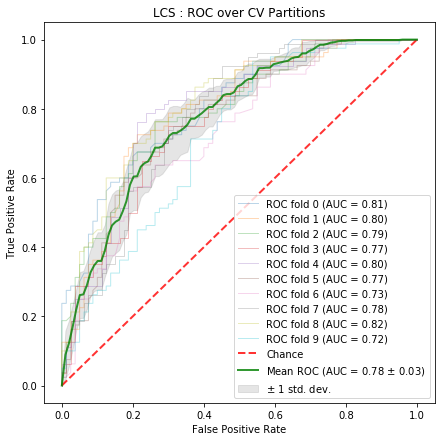

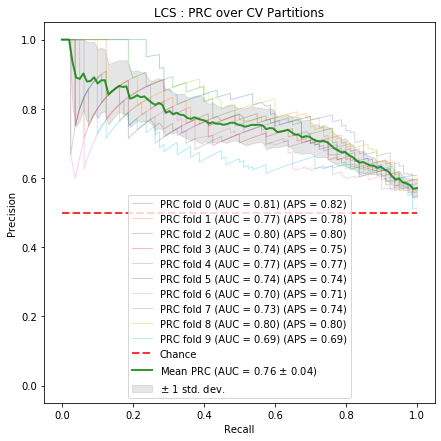

Avg. Model Balanced Accuracy = 0.704375 (std. dev. = 0.03913618051113315)
Avg. Model Accuracy = 0.7043750000000001 (std. dev. = 0.03913618051113317)
Avg. Model F1-Score = 0.7043041660206991 (std. dev. = 0.04561051128267557)
Avg. Model Recall = 0.7075000000000001 (std. dev. = 0.0647591692349431)
Avg. Model Specificity = 0.7012499999999999 (std. dev. = 0.04624999999999998)
Avg. Model Precision = 0.7033210046713266 (std. dev. = 0.03933615424915796)
Avg. Model True Positives = 56.6 (std. dev. = 5.180733538795447)
Avg. Model True Negatives = 56.1 (std. dev. = 3.6999999999999997)
Avg. Model False Positives = 23.9 (std. dev. = 3.6999999999999997)
Avg. Model False Negatives = 23.4 (std. dev. = 5.180733538795447)
Avg. ROC AUC = 0.7771250000000001 (std. dev. = 0.031067372605757943)
Avg. PRC AUC = 0.7552442814906815 (std. dev. = 0.0408285632733815)
Avg. PRC Precision Score = 0.7581465171361902 (std. dev. = 0.039806992726224386)
LCS Run Time: 12221.531257867813


In [63]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    elapsed_time = time.time() - start_time
    print('LCS Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

### Load and Evaluate LCS with QRF Predictions

Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF



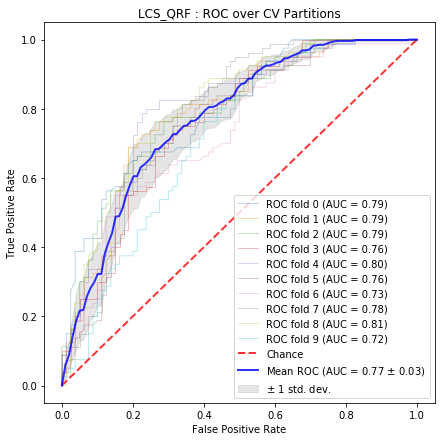

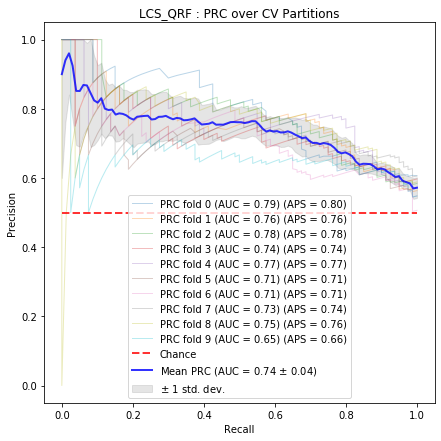

Avg. Model Balanced Accuracy = 0.704375 (std. dev. = 0.03791952828029378)
Avg. Model Accuracy = 0.704375 (std. dev. = 0.037919528280293775)
Avg. Model F1-Score = 0.7086108210117504 (std. dev. = 0.041721794397683004)
Avg. Model Recall = 0.72125 (std. dev. = 0.057567894698347256)
Avg. Model Specificity = 0.6875 (std. dev. = 0.042573465914816006)
Avg. Model Precision = 0.6978733101156452 (std. dev. = 0.03719671654936069)
Avg. Model True Positives = 57.7 (std. dev. = 4.605431575867782)
Avg. Model True Negatives = 55.0 (std. dev. = 3.40587727318528)
Avg. Model False Positives = 25.0 (std. dev. = 3.40587727318528)
Avg. Model False Negatives = 22.3 (std. dev. = 4.605431575867782)
Avg. ROC AUC = 0.772625 (std. dev. = 0.02935831474269683)
Avg. PRC AUC = 0.7388689412325531 (std. dev. = 0.03892699350152998)
Avg. PRC Precision Score = 0.7425367385374996 (std. dev. = 0.03820474030470541)


In [64]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS_QRF(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

### Load and Evaluate LCS Feature Importance Estimates

In [65]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)



---Feature Importances---



Names  Scores
19  M1P1  1547.3
17  M0P1  1419.9
16  M0P0  1350.6
18  M1P0  1322.8
14   N14   458.1
11   N11   403.8
12   N12   390.3
15   N15   373.8
1     N1   335.1
9     N9   261.5
2     N2   259.9
7     N7   244.4
4     N4   220.1
8     N8   161.8
13   N13   146.0
6     N6   110.9
5     N5    85.0
0     N0     0.0
3     N3     0.0
10   N10     0.0

### Load and Evaluate LCS with QRF Feature Importance Estimates

In [66]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_RC_QRF_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)



---Feature Importances---



Names  Scores
19  M1P1  1315.2
17  M0P1  1202.7
16  M0P0  1147.4
18  M1P0  1123.5
14   N14   375.5
11   N11   335.9
12   N12   318.8
15   N15   303.8
1     N1   280.4
9     N9   219.3
2     N2   214.4
7     N7   195.8
4     N4   183.8
8     N8   131.9
13   N13   123.0
6     N6    93.9
5     N5    71.8
0     N0     0.0
3     N3     0.0
10   N10     0.0

---
# Review result table (for global ROC and PRC figure building)

In [67]:
#Load pickle files of results
result_table = []

for algorithm in algorithmsToRun:
    tempDict = pickle.load(open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'rb'))
    result_table.append(tempDict)
    
result_table = pd.DataFrame.from_dict(result_table)

In [68]:
result_table
result_table.set_index('algorithm', inplace=True)

algorithm                                                fpr  \
0  logistic_regression  [0.0, 0.010101010101010102, 0.0202020202020202...   
1        decision_tree  [0.0, 0.010101010101010102, 0.0202020202020202...   
2        random_forest  [0.0, 0.010101010101010102, 0.0202020202020202...   
3          naive_bayes  [0.0, 0.010101010101010102, 0.0202020202020202...   
4                  XGB  [0.0, 0.010101010101010102, 0.0202020202020202...   
5                  LGB  [0.0, 0.010101010101010102, 0.0202020202020202...   
6                  SVM  [0.0, 0.010101010101010102, 0.0202020202020202...   
7                  ANN  [0.0, 0.010101010101010102, 0.0202020202020202...   
8                  LCS  [0.0, 0.010101010101010102, 0.0202020202020202...   
9              LCS_QRF  [0.0, 0.010101010101010102, 0.0202020202020202...   

                                                 tpr       auc  \
0  [0.0, 0.011060606060606059, 0.0171212121212121...  0.493506   
1  [0.0, 0.03239057239057239, 0.05563973063973063...  0.646835   
2  [0.0, 0.08499999999999999, 0.12452020202020202...  0.764797   
3  [0.0, 0.01625, 0.021249999999999998, 0.0337499...  0.489645   
4  [0.0, 0.08499999999999999, 0.14250000000000002...  0.773041   
5  [0.0, 0.07925505050505052, 0.13851010101010103...  0.777360   
6  [0.0, 0.052500000000000005, 0.0775, 0.12125, 0...  0.741809   
7  [0.0, 0.0725, 0.1075, 0.145, 0.190871212121212...  0.769012   
8  [0.0, 0.08875000000000001, 0.12279040404040406...  0.776662   
9  [0.0, 0.058750000000000004, 0.0882702020202020...  0.772300   

                                                prec    pr_auc  ave_prec  
0  [0.8, 0.8265993265993264, 0.8357142857142856, ...  0.644085  0.496695  
1  [0.6, 0.6473945807279142, 0.676756987868099, 0...  0.623838  0.625639  
2  [1.0, 1.0, 0.8641414141414142, 0.8031313131313...  0.740763  0.744070  
3  [0.6, 0.7373737373737373, 0.6112409812409813, ...  0.503089  0.510199  
4  [1.0, 1.0, 0.9342424242424243, 0.9144444444444...  0.755995  0.758543  
5  [0.9, 0.9404040404040405, 0.9436026936026936, ...  0.758848  0.762245  
6  [0.9, 0.9404040404040405, 0.8641414141414142, ...  0.713328  0.717334  
7  [0.9, 0.9404040404040405, 0.9205387205387205, ...  0.745375  0.748803  
8  [1.0, 1.0, 1.0, 0.934040404040404, 0.889812409...  0.755200  0.758147  
9  [0.9, 0.9404040404040405, 0.9602693602693602, ...  0.738552  0.742537

---
# ROC Plot Summarizing Analysis

([<matplotlib.axis.XTick at 0x2054ba91548>,
 <a list of 11 Text xticklabel objects>)

Text(0.5, 0, 'False Positive Rate')

([<matplotlib.axis.YTick at 0x2054892c488>,
 <a list of 11 Text yticklabel objects>)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Comparing Algorithms: Testing Data with CV')

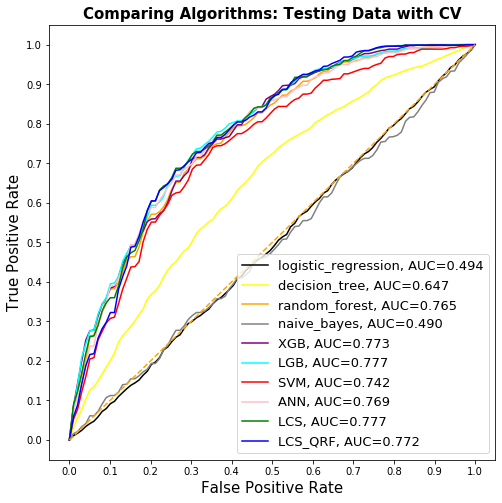

In [69]:
#Multi-algorithm ROC plot
fig = plt.figure(figsize=(8,8))
count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], color = algColors[count],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    count += 1
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_ROC_' + data_name), bbox_inches = "tight")
plt.show()


---
# PRC Plot Summarizing Analysis

([<matplotlib.axis.XTick at 0x2054bb9e4c8>,
 <a list of 11 Text xticklabel objects>)

Text(0.5, 0, 'Recall')

([<matplotlib.axis.YTick at 0x2054c49d748>,
 <a list of 11 Text yticklabel objects>)

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Comparing Algorithms: Testing Data with CV')

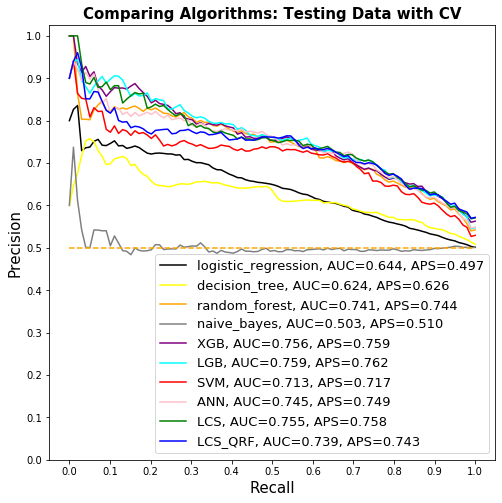

In [70]:
#Multi-algorithm PRC plot ['algorithm','fpr','tpr','auc','prec','pr_auc','ave_prec'])
#result_table.set_index('algorithm', inplace=True)

fig = plt.figure(figsize=(8,8))

count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['prec'], color = algColors[count],
             label="{}, AUC={:.3f}, APS={:.3f}".format(i, result_table.loc[i]['pr_auc'],result_table.loc[i]['ave_prec']))
    count += 1
noskill = len(yTestList[0][yTestList[0]==1]) / len(yTestList[0]) #Fraction of cases
plt.plot([0,1], [noskill,noskill], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_PRC_' + data_name), bbox_inches = "tight")
plt.show()


---
# Summarize Algorithm Metrics 

In [71]:
td = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_Metrics_'+data_name+'.csv')
metrics = list(td.columns.values.tolist()) 

metric_summary = pd.DataFrame(index=metrics,columns=algorithmsToRun)
master_list = []

for algorithm in algorithmsToRun:
    #Open file
    td = pd.read_csv(wd_path+output_folder+'/'+algorithm+'_Metrics_'+data_name+'.csv')
    master_list.append(td)
    for metric in metrics:
        ave = td[metric].mean()
        sd = td[metric].std()
        metric_summary.at[metric, algorithm] = str(round(ave,4))+' ('+str(round(sd,4))+')'
    
metric_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_Metrics_'+data_name+'.csv')   

In [72]:
metric_summary

logistic_regression    decision_tree    random_forest  \
Balanced Accuracy      0.4956 (0.028)   0.605 (0.0403)  0.6963 (0.0287)   
Accuracy               0.4956 (0.028)   0.605 (0.0403)  0.6962 (0.0287)   
F1_Score               0.4579 (0.259)  0.5973 (0.0534)   0.6966 (0.032)   
Recall                0.5875 (0.3996)    0.59 (0.0766)  0.6987 (0.0451)   
Specificity           0.4037 (0.3961)    0.62 (0.0457)   0.6938 (0.034)   
Precision             0.3952 (0.2103)  0.6074 (0.0381)  0.6954 (0.0284)   
TP                     47.0 (31.9653)    47.2 (6.1246)     55.9 (3.604)   
TN                     32.3 (31.6896)    49.6 (3.6576)    55.5 (2.7183)   
FP                     47.7 (31.6896)    30.4 (3.6576)    24.5 (2.7183)   
FN                     33.0 (31.9653)    32.8 (6.1246)     24.1 (3.604)   
ROC_AUC               0.4936 (0.0194)  0.6469 (0.0513)   0.765 (0.0387)   
PRC_AUC               0.6441 (0.1387)  0.6239 (0.0578)   0.7404 (0.059)   
PRC_APS               0.4967 (0.0232)  0.6256 (0.0499)  0.7441 (0.0573)   

                       naive_bayes              XGB              LGB  \
Balanced Accuracy  0.4963 (0.0324)  0.6987 (0.0377)   0.7075 (0.031)   
Accuracy           0.4963 (0.0324)  0.6987 (0.0377)   0.7075 (0.031)   
F1_Score           0.4332 (0.0401)  0.6961 (0.0426)  0.7059 (0.0378)   
Recall             0.3863 (0.0462)  0.6925 (0.0602)   0.705 (0.0593)   
Specificity        0.6062 (0.0587)   0.705 (0.0426)    0.71 (0.0337)   
Precision           0.496 (0.0414)  0.7015 (0.0376)  0.7084 (0.0271)   
TP                   30.9 (3.6953)     55.4 (4.812)    56.4 (4.7422)   
TN                   48.5 (4.6963)    56.4 (3.4059)    56.8 (2.6998)   
FP                   31.5 (4.6963)    23.6 (3.4059)    23.2 (2.6998)   
FN                   49.1 (3.6953)     24.6 (4.812)    23.6 (4.7422)   
ROC_AUC            0.4895 (0.0283)  0.7733 (0.0453)  0.7777 (0.0358)   
PRC_AUC            0.5029 (0.0253)  0.7558 (0.0506)  0.7592 (0.0454)   
PRC_APS            0.5102 (0.0238)  0.7585 (0.0497)  0.7622 (0.0438)   

                               SVM              ANN              LCS  \
Balanced Accuracy  0.6906 (0.0386)   0.705 (0.0353)  0.7044 (0.0413)   
Accuracy           0.6906 (0.0386)   0.705 (0.0353)  0.7044 (0.0413)   
F1_Score           0.6874 (0.0443)  0.7049 (0.0384)  0.7043 (0.0481)   
Recall             0.6825 (0.0578)  0.7062 (0.0525)  0.7075 (0.0683)   
Specificity        0.6987 (0.0346)  0.7038 (0.0417)  0.7013 (0.0488)   
Precision           0.6933 (0.036)  0.7048 (0.0355)  0.7033 (0.0415)   
TP                   54.6 (4.6236)    56.5 (4.1966)     56.6 (5.461)   
TN                   55.9 (2.7669)     56.3 (3.335)    56.1 (3.9001)   
FP                   24.1 (2.7669)     23.7 (3.335)    23.9 (3.9001)   
FN                   25.4 (4.6236)    23.5 (4.1966)     23.4 (5.461)   
ROC_AUC              0.742 (0.054)  0.7694 (0.0398)  0.7771 (0.0327)   
PRC_AUC            0.7132 (0.0656)  0.7452 (0.0469)   0.7552 (0.043)   
PRC_APS            0.7173 (0.0639)  0.7488 (0.0457)   0.7581 (0.042)   

                           LCS_QRF  
Balanced Accuracy    0.7044 (0.04)  
Accuracy             0.7044 (0.04)  
F1_Score            0.7086 (0.044)  
Recall             0.7212 (0.0607)  
Specificity        0.6875 (0.0449)  
Precision          0.6979 (0.0392)  
TP                   57.7 (4.8546)  
TN                   55.0 (3.5901)  
FP                   25.0 (3.5901)  
FN                   22.3 (4.8546)  
ROC_AUC            0.7726 (0.0309)  
PRC_AUC             0.7389 (0.041)  
PRC_APS            0.7425 (0.0403)

---
# Performance Metric Boxplots Comparing Algorithms

Text(0.5, 1.0, 'Comparing Algorithm Balanced Accuracy')

Text(0, 0.5, 'Balanced Accuracy')

Text(0.5, 0, 'ML Algorithm')

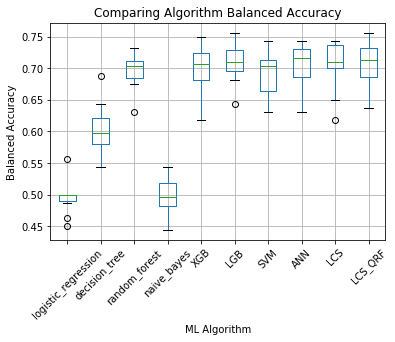

Text(0.5, 1.0, 'Comparing Algorithm Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'ML Algorithm')

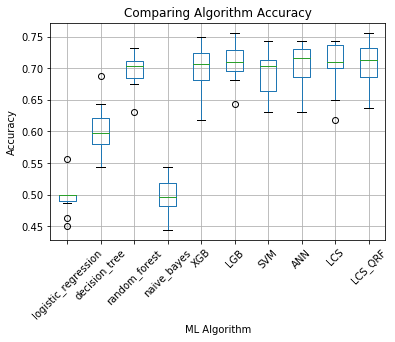

Text(0.5, 1.0, 'Comparing Algorithm F1_Score')

Text(0, 0.5, 'F1_Score')

Text(0.5, 0, 'ML Algorithm')

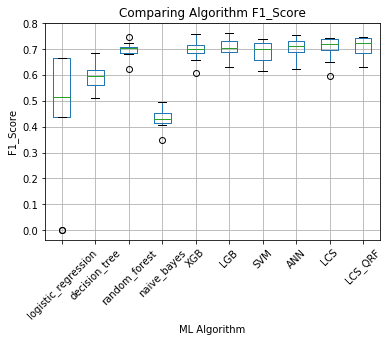

Text(0.5, 1.0, 'Comparing Algorithm Recall')

Text(0, 0.5, 'Recall')

Text(0.5, 0, 'ML Algorithm')

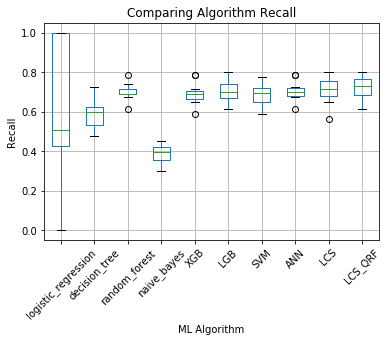

Text(0.5, 1.0, 'Comparing Algorithm Specificity')

Text(0, 0.5, 'Specificity')

Text(0.5, 0, 'ML Algorithm')

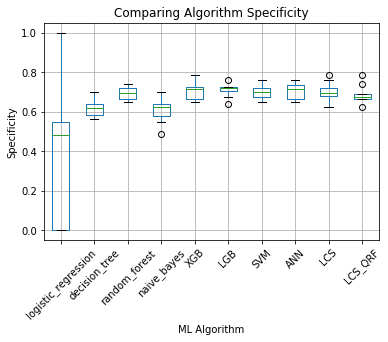

Text(0.5, 1.0, 'Comparing Algorithm Precision')

Text(0, 0.5, 'Precision')

Text(0.5, 0, 'ML Algorithm')

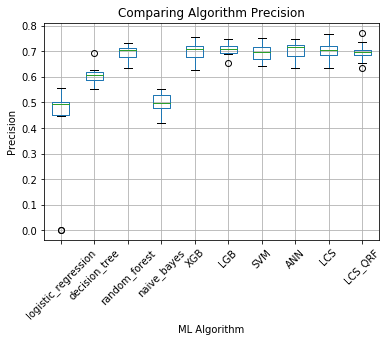

Text(0.5, 1.0, 'Comparing Algorithm TP')

Text(0, 0.5, 'TP')

Text(0.5, 0, 'ML Algorithm')

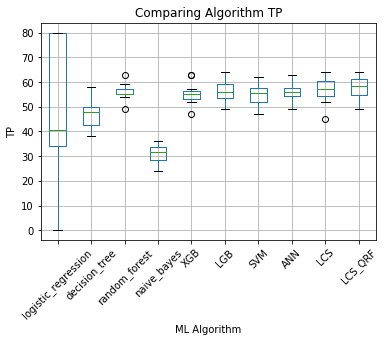

Text(0.5, 1.0, 'Comparing Algorithm TN')

Text(0, 0.5, 'TN')

Text(0.5, 0, 'ML Algorithm')

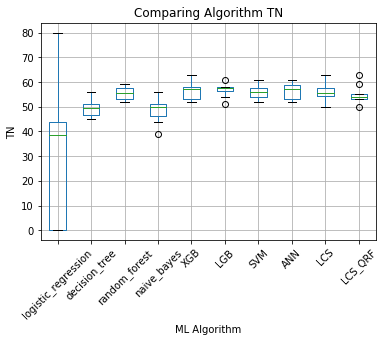

Text(0.5, 1.0, 'Comparing Algorithm FP')

Text(0, 0.5, 'FP')

Text(0.5, 0, 'ML Algorithm')

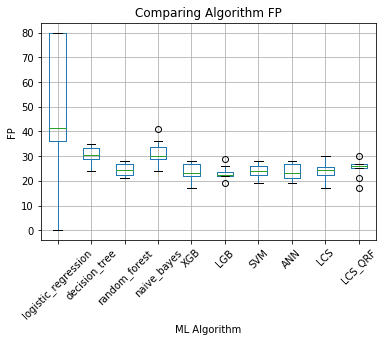

Text(0.5, 1.0, 'Comparing Algorithm FN')

Text(0, 0.5, 'FN')

Text(0.5, 0, 'ML Algorithm')

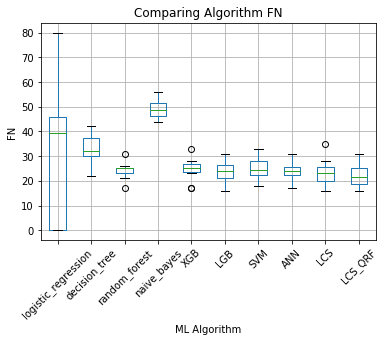

Text(0.5, 1.0, 'Comparing Algorithm ROC_AUC')

Text(0, 0.5, 'ROC_AUC')

Text(0.5, 0, 'ML Algorithm')

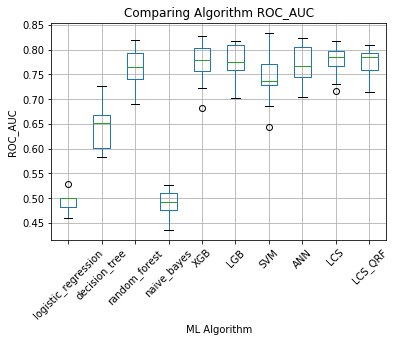

Text(0.5, 1.0, 'Comparing Algorithm PRC_AUC')

Text(0, 0.5, 'PRC_AUC')

Text(0.5, 0, 'ML Algorithm')

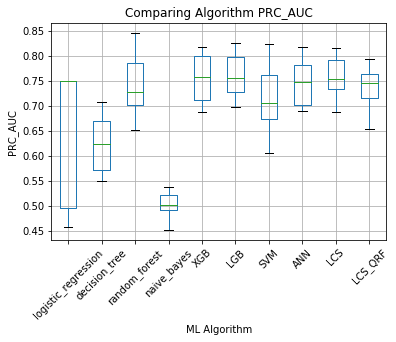

Text(0.5, 1.0, 'Comparing Algorithm PRC_APS')

Text(0, 0.5, 'PRC_APS')

Text(0.5, 0, 'ML Algorithm')

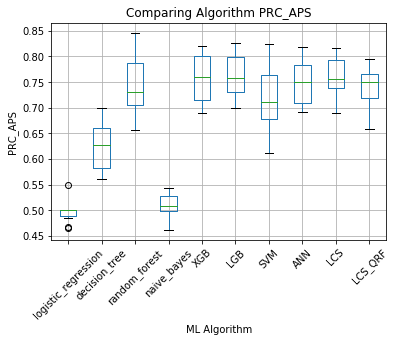

In [73]:

#For each metric
for metric in metrics:
    i = 0
    tempList = []
    for algorithm in algorithmsToRun:
        temp_td = master_list[i]
        tempList.append(temp_td[metric].tolist())
        i += 1
        
    td = pd.DataFrame(tempList)
    td = td.transpose()
    td.columns = algorithmsToRun
        
    boxplot = td.boxplot(column=algorithmsToRun,rot=45)
    plt.title('Comparing Algorithm '+ str(metric))
    plt.ylabel(str(metric))
    plt.xlabel('ML Algorithm')
    plt.savefig((wd_path+output_folder+'/'+'Compare_'+str(metric)+'_Boxplot_'+data_name), bbox_inches = "tight")
    plt.show()


---
# Statistical Comparisons
- Kruskal Wallis AOV comparing ML algorithms
- Mann-Whitney U test - Pairwise algorithm differences  

## Kruskal Wallis Test - Algorithm comparisons for each metric
- Are any algorithms performing statistically better or worse? 

## Mann-Whiney Test - Pairwise Post-Hoc Analysis 
- For any metric where kruskal wallis test was significant.

In [74]:
if len(algorithmsToRun) > 1:
    label = ['statistic','pvalue','sig']
    kruskal_summary = pd.DataFrame(index=metrics,columns=label)
    for metric in metrics:
        tempArray = []
        for i in range(len(algorithmsToRun)):
            tempArray.append(master_list[i][metric])
        result = stats.kruskal(*tempArray)
        #result = stats.kruskal(master_list[0][metric],master_list[1][metric],master_list[2][metric],master_list[3][metric],master_list[4][metric],master_list[5][metric],master_list[6][metric]) 
        kruskal_summary.at[metric, 'statistic'] = str(round(result[0],6))
        kruskal_summary.at[metric, 'pvalue'] = str(round(result[1],6))
        if result[1] < sig_cutoff:
            kruskal_summary.at[metric, 'sig'] = str('*')
        else:
            kruskal_summary.at[metric, 'sig'] = str('')

    kruskal_summary

    kruskal_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_KruskalWallis_'+data_name+'.csv')   

statistic   pvalue sig
Balanced Accuracy  62.600322      0.0   *
Accuracy           62.637592      0.0   *
F1_Score           55.697126      0.0   *
Recall             36.690318    3e-05   *
Specificity        38.094843  1.7e-05   *
Precision          62.768353      0.0   *
TP                 36.690318    3e-05   *
TN                 38.094843  1.7e-05   *
FP                 38.094843  1.7e-05   *
FN                 36.690318    3e-05   *
ROC_AUC            64.505321      0.0   *
PRC_AUC            45.412547    1e-06   *
PRC_APS            64.855205      0.0   *

In [75]:
if len(algorithmsToRun) > 1:
    algCount = len(algorithmsToRun)
    for metric in metrics:
        if kruskal_summary['sig'][metric] == '*':
            mann_stats = []
            #Balanced Accuracy
            for i in range(0,algCount-1):
                for j in range(i+1,algCount):
                    set1 = master_list[i][metric]
                    set2 = master_list[j][metric]

                    #print('Mann-WhitneyU: '+str(algorithmsToRun[i])+' vs. '+str(algorithmsToRun[j]))
                    report = stats.mannwhitneyu(set1,set2)
                    #report
                    tempstats = [algorithmsToRun[i], algorithmsToRun[j], report[0], report[1], '']
                    if report[1] < sig_cutoff:
                        tempstats[4] = '*'
                    mann_stats.append(tempstats)

            mann_stats_df = pd.DataFrame(mann_stats)
            mann_stats_df.columns = ['Algorithm 1', 'Algorithm 2', 'statistic', 'p-value', 'sig']
            filepath = wd_path+output_folder+'/'+'MannWhitney_'+str(metric)+'_'+data_name+'.csv'
            mann_stats_df.to_csv(filepath, index = False) 
            mann_stats_df

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree        1.0  0.000100   *
1   logistic_regression  random_forest        0.0  0.000074   *
2   logistic_regression    naive_bayes       47.5  0.438974    
3   logistic_regression            XGB        0.0  0.000074   *
4   logistic_regression            LGB        0.0  0.000074   *
5   logistic_regression            SVM        0.0  0.000075   *
6   logistic_regression            ANN        0.0  0.000075   *
7   logistic_regression            LCS        0.0  0.000074   *
8   logistic_regression        LCS_QRF        0.0  0.000074   *
9         decision_tree  random_forest        4.0  0.000287   *
10        decision_tree    naive_bayes        0.5  0.000103   *
11        decision_tree            XGB        5.0  0.000377   *
12        decision_tree            LGB        2.5  0.000187   *
13        decision_tree            SVM        6.0  0.000500   *
14        decision_tree            ANN        4.0  0.000289   *
15        decision_tree            LCS        4.0  0.000286   *
16        decision_tree        LCS_QRF        4.5  0.000327   *
17        random_forest    naive_bayes        0.0  0.000090   *
18        random_forest            XGB       47.0  0.424689    
19        random_forest            LGB       39.0  0.212805    
20        random_forest            SVM       48.0  0.454725    
21        random_forest            ANN       39.0  0.213242    
22        random_forest            LCS       37.0  0.171350    
23        random_forest        LCS_QRF       39.0  0.212717    
24          naive_bayes            XGB        0.0  0.000089   *
25          naive_bayes            LGB        0.0  0.000090   *
26          naive_bayes            SVM        0.0  0.000090   *
27          naive_bayes            ANN        0.0  0.000090   *
28          naive_bayes            LCS        0.0  0.000089   *
29          naive_bayes        LCS_QRF        0.0  0.000089   *
30                  XGB            LGB       44.0  0.338333    
31                  XGB            SVM       44.0  0.338391    
32                  XGB            ANN       43.0  0.311129    
33                  XGB            LCS       44.5  0.352144    
34                  XGB        LCS_QRF       42.0  0.284867    
35                  LGB            SVM       38.5  0.202220    
36                  LGB            ANN       49.0  0.484891    
37                  LGB            LCS       46.5  0.409965    
38                  LGB        LCS_QRF       49.5  0.500000    
39                  SVM            ANN       37.0  0.171807    
40                  SVM            LCS       39.5  0.223904    
41                  SVM        LCS_QRF       39.5  0.224076    
42                  ANN            LCS       48.5  0.469746    
43                  ANN        LCS_QRF       47.5  0.439712    
44                  LCS        LCS_QRF       46.5  0.409763

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree        1.0  0.000100   *
1   logistic_regression  random_forest        0.0  0.000074   *
2   logistic_regression    naive_bayes       47.5  0.438974    
3   logistic_regression            XGB        0.0  0.000074   *
4   logistic_regression            LGB        0.0  0.000074   *
5   logistic_regression            SVM        0.0  0.000074   *
6   logistic_regression            ANN        0.0  0.000075   *
7   logistic_regression            LCS        0.0  0.000074   *
8   logistic_regression        LCS_QRF        0.0  0.000074   *
9         decision_tree  random_forest        4.0  0.000287   *
10        decision_tree    naive_bayes        0.5  0.000103   *
11        decision_tree            XGB        5.0  0.000377   *
12        decision_tree            LGB        2.5  0.000187   *
13        decision_tree            SVM        6.0  0.000497   *
14        decision_tree            ANN        4.0  0.000289   *
15        decision_tree            LCS        4.0  0.000286   *
16        decision_tree        LCS_QRF        4.5  0.000327   *
17        random_forest    naive_bayes        0.0  0.000090   *
18        random_forest            XGB       46.0  0.395050    
19        random_forest            LGB       38.0  0.191259    
20        random_forest            SVM       48.5  0.469746    
21        random_forest            ANN       38.0  0.191709    
22        random_forest            LCS       37.0  0.171350    
23        random_forest        LCS_QRF       39.0  0.212717    
24          naive_bayes            XGB        0.0  0.000089   *
25          naive_bayes            LGB        0.0  0.000090   *
26          naive_bayes            SVM        0.0  0.000090   *
27          naive_bayes            ANN        0.0  0.000090   *
28          naive_bayes            LCS        0.0  0.000089   *
29          naive_bayes        LCS_QRF        0.0  0.000089   *
30                  XGB            LGB       44.0  0.338333    
31                  XGB            SVM       44.0  0.338333    
32                  XGB            ANN       43.0  0.311129    
33                  XGB            LCS       44.5  0.352144    
34                  XGB        LCS_QRF       43.0  0.310932    
35                  LGB            SVM       38.0  0.191439    
36                  LGB            ANN       49.0  0.484879    
37                  LGB            LCS       47.0  0.424745    
38                  LGB        LCS_QRF       49.5  0.500000    
39                  SVM            ANN       37.5  0.181359    
40                  SVM            LCS       40.0  0.235165    
41                  SVM        LCS_QRF       39.5  0.223990    
42                  ANN            LCS       48.5  0.469746    
43                  ANN        LCS_QRF       48.5  0.469746    
44                  LCS        LCS_QRF       46.5  0.409763

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       34.0  0.119684    
1   logistic_regression  random_forest        4.0  0.000276   *
2   logistic_regression    naive_bayes       29.0  0.059842    
3   logistic_regression            XGB        8.0  0.000816   *
4   logistic_regression            LGB        4.0  0.000276   *
5   logistic_regression            SVM       16.0  0.005497   *
6   logistic_regression            ANN        4.0  0.000276   *
7   logistic_regression            LCS        8.0  0.000816   *
8   logistic_regression        LCS_QRF        8.0  0.000816   *
9         decision_tree  random_forest        4.0  0.000291   *
10        decision_tree    naive_bayes        0.0  0.000091   *
11        decision_tree            XGB        8.0  0.000853   *
12        decision_tree            LGB        3.0  0.000220   *
13        decision_tree            SVM        9.0  0.001101   *
14        decision_tree            ANN        3.0  0.000220   *
15        decision_tree            LCS        7.0  0.000657   *
16        decision_tree        LCS_QRF        5.0  0.000384   *
17        random_forest    naive_bayes        0.0  0.000091   *
18        random_forest            XGB       48.5  0.469838    
19        random_forest            LGB       41.5  0.272599    
20        random_forest            SVM       46.5  0.410265    
21        random_forest            ANN       42.0  0.285230    
22        random_forest            LCS       38.5  0.202751    
23        random_forest        LCS_QRF       35.0  0.136338    
24          naive_bayes            XGB        0.0  0.000091   *
25          naive_bayes            LGB        0.0  0.000091   *
26          naive_bayes            SVM        0.0  0.000091   *
27          naive_bayes            ANN        0.0  0.000091   *
28          naive_bayes            LCS        0.0  0.000091   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       42.5  0.298282    
31                  XGB            SVM       46.0  0.395592    
32                  XGB            ANN       44.0  0.338678    
33                  XGB            LCS       41.0  0.260261    
34                  XGB        LCS_QRF       39.0  0.213678    
35                  LGB            SVM       37.5  0.182083    
36                  LGB            ANN       49.5  0.500000    
37                  LGB            LCS       46.0  0.395668    
38                  LGB        LCS_QRF       42.5  0.298282    
39                  SVM            ANN       38.0  0.192337    
40                  SVM            LCS       36.5  0.162785    
41                  SVM        LCS_QRF       32.0  0.092938    
42                  ANN            LCS       45.5  0.381141    
43                  ANN        LCS_QRF       44.0  0.338792    
44                  LCS        LCS_QRF       43.5  0.325012

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       43.5  0.324270    
1   logistic_regression  random_forest       40.0  0.234488    
2   logistic_regression    naive_bayes       23.0  0.021973   *
3   logistic_regression            XGB       40.0  0.234996    
4   logistic_regression            LGB       40.0  0.235081    
5   logistic_regression            SVM       40.0  0.235249    
6   logistic_regression            ANN       40.0  0.235165    
7   logistic_regression            LCS       40.0  0.235333    
8   logistic_regression        LCS_QRF       40.0  0.235333    
9         decision_tree  random_forest       11.5  0.001926   *
10        decision_tree    naive_bayes        0.0  0.000090   *
11        decision_tree            XGB       15.0  0.004450   *
12        decision_tree            LGB       12.0  0.002232   *
13        decision_tree            SVM       17.0  0.006866   *
14        decision_tree            ANN       11.5  0.001960   *
15        decision_tree            LCS       13.0  0.002861   *
16        decision_tree        LCS_QRF        9.0  0.001072   *
17        random_forest    naive_bayes        0.0  0.000085   *
18        random_forest            XGB       41.5  0.267601    
19        random_forest            LGB       47.0  0.424290    
20        random_forest            SVM       44.0  0.337343    
21        random_forest            ANN       46.5  0.409149    
22        random_forest            LCS       41.5  0.271072    
23        random_forest        LCS_QRF       36.5  0.160950    
24          naive_bayes            XGB        0.0  0.000088   *
25          naive_bayes            LGB        0.0  0.000089   *
26          naive_bayes            SVM        0.0  0.000090   *
27          naive_bayes            ANN        0.0  0.000089   *
28          naive_bayes            LCS        0.0  0.000090   *
29          naive_bayes        LCS_QRF        0.0  0.000090   *
30                  XGB            LGB       41.5  0.271149    
31                  XGB            SVM       48.0  0.454571    
32                  XGB            ANN       39.0  0.211392    
33                  XGB            LCS       39.0  0.212717    
34                  XGB        LCS_QRF       35.5  0.143867    
35                  LGB            SVM       40.0  0.234147    
36                  LGB            ANN       48.0  0.454398    
37                  LGB            LCS       43.5  0.324270    
38                  LGB        LCS_QRF       41.0  0.259553    
39                  SVM            ANN       39.5  0.223473    
40                  SVM            LCS       37.0  0.171350    
41                  SVM        LCS_QRF       30.5  0.074540    
42                  ANN            LCS       45.5  0.380573    
43                  ANN        LCS_QRF       39.5  0.223732    
44                  LCS        LCS_QRF       42.5  0.297657

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       21.0  0.015068   *
1   logistic_regression  random_forest       20.0  0.012514   *
2   logistic_regression    naive_bayes       23.5  0.023959   *
3   logistic_regression            XGB       20.0  0.012486   *
4   logistic_regression            LGB       20.0  0.012267   *
5   logistic_regression            SVM       20.0  0.012486   *
6   logistic_regression            ANN       20.0  0.012431   *
7   logistic_regression            LCS       20.0  0.012542   *
8   logistic_regression        LCS_QRF       20.0  0.012404   *
9         decision_tree  random_forest        9.0  0.001072   *
10        decision_tree    naive_bayes       47.0  0.424261    
11        decision_tree            XGB        7.5  0.000728   *
12        decision_tree            LGB        5.0  0.000352   *
13        decision_tree            SVM        8.0  0.000823   *
14        decision_tree            ANN        8.5  0.000936   *
15        decision_tree            LCS       10.5  0.001559   *
16        decision_tree        LCS_QRF       15.0  0.004348   *
17        random_forest    naive_bayes        5.5  0.000425   *
18        random_forest            XGB       43.5  0.323770    
19        random_forest            LGB       38.0  0.189805    
20        random_forest            SVM       47.0  0.424519    
21        random_forest            ANN       42.0  0.283690    
22        random_forest            LCS       47.0  0.424689    
23        random_forest        LCS_QRF       43.5  0.323645    
24          naive_bayes            XGB        4.0  0.000280   *
25          naive_bayes            LGB        4.0  0.000261   *
26          naive_bayes            SVM        5.0  0.000370   *
27          naive_bayes            ANN        4.5  0.000318   *
28          naive_bayes            LCS        9.5  0.001202   *
29          naive_bayes        LCS_QRF       12.0  0.002188   *
30                  XGB            LGB       45.5  0.379094    
31                  XGB            SVM       46.5  0.409321    
32                  XGB            ANN       49.0  0.484735    
33                  XGB            LCS       46.5  0.409864    
34                  XGB        LCS_QRF       40.5  0.246098    
35                  LGB            SVM       38.5  0.198328    
36                  LGB            ANN       48.0  0.454134    
37                  LGB            LCS       39.5  0.222429    
38                  LGB        LCS_QRF       29.5  0.063617    
39                  SVM            ANN       46.5  0.409492    
40                  SVM            LCS       49.0  0.484822    
41                  SVM        LCS_QRF       40.0  0.233806    
42                  ANN            LCS       47.5  0.439644    
43                  ANN        LCS_QRF       42.5  0.296462    
44                  LCS        LCS_QRF       37.5  0.180080

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree        1.0  0.000116   *
1   logistic_regression  random_forest        0.0  0.000086   *
2   logistic_regression    naive_bayes       39.0  0.212717    
3   logistic_regression            XGB        0.0  0.000086   *
4   logistic_regression            LGB        0.0  0.000086   *
5   logistic_regression            SVM        0.0  0.000086   *
6   logistic_regression            ANN        0.0  0.000086   *
7   logistic_regression            LCS        0.0  0.000086   *
8   logistic_regression        LCS_QRF        0.0  0.000086   *
9         decision_tree  random_forest        4.0  0.000291   *
10        decision_tree    naive_bayes        1.0  0.000123   *
11        decision_tree            XGB        4.0  0.000291   *
12        decision_tree            LGB        2.0  0.000165   *
13        decision_tree            SVM        5.0  0.000384   *
14        decision_tree            ANN        3.0  0.000220   *
15        decision_tree            LCS        3.0  0.000220   *
16        decision_tree        LCS_QRF        4.0  0.000291   *
17        random_forest    naive_bayes        0.0  0.000091   *
18        random_forest            XGB       44.5  0.352570    
19        random_forest            LGB       37.5  0.182083    
20        random_forest            SVM       48.5  0.469860    
21        random_forest            ANN       40.0  0.236171    
22        random_forest            LCS       44.5  0.352676    
23        random_forest        LCS_QRF       48.0  0.454827    
24          naive_bayes            XGB        0.0  0.000091   *
25          naive_bayes            LGB        0.0  0.000091   *
26          naive_bayes            SVM        0.0  0.000091   *
27          naive_bayes            ANN        0.0  0.000091   *
28          naive_bayes            LCS        0.0  0.000091   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       47.0  0.424998    
31                  XGB            SVM       42.0  0.285230    
32                  XGB            ANN       44.5  0.352570    
33                  XGB            LCS       49.0  0.484925    
34                  XGB        LCS_QRF       43.0  0.311588    
35                  LGB            SVM       37.5  0.182083    
36                  LGB            ANN       48.0  0.454827    
37                  LGB            LCS       46.0  0.395668    
38                  LGB        LCS_QRF       36.5  0.162785    
39                  SVM            ANN       40.5  0.248065    
40                  SVM            LCS       42.5  0.298282    
41                  SVM        LCS_QRF       50.0  0.484925    
42                  ANN            LCS       48.5  0.469860    
43                  ANN        LCS_QRF       40.0  0.236338    
44                  LCS        LCS_QRF       44.5  0.352676

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       43.5  0.324270    
1   logistic_regression  random_forest       40.0  0.234488    
2   logistic_regression    naive_bayes       23.0  0.021973   *
3   logistic_regression            XGB       40.0  0.234996    
4   logistic_regression            LGB       40.0  0.235081    
5   logistic_regression            SVM       40.0  0.235249    
6   logistic_regression            ANN       40.0  0.235165    
7   logistic_regression            LCS       40.0  0.235333    
8   logistic_regression        LCS_QRF       40.0  0.235333    
9         decision_tree  random_forest       11.5  0.001926   *
10        decision_tree    naive_bayes        0.0  0.000090   *
11        decision_tree            XGB       15.0  0.004450   *
12        decision_tree            LGB       12.0  0.002232   *
13        decision_tree            SVM       17.0  0.006866   *
14        decision_tree            ANN       11.5  0.001960   *
15        decision_tree            LCS       13.0  0.002861   *
16        decision_tree        LCS_QRF        9.0  0.001072   *
17        random_forest    naive_bayes        0.0  0.000085   *
18        random_forest            XGB       41.5  0.267601    
19        random_forest            LGB       47.0  0.424290    
20        random_forest            SVM       44.0  0.337343    
21        random_forest            ANN       46.5  0.409149    
22        random_forest            LCS       41.5  0.271072    
23        random_forest        LCS_QRF       36.5  0.160950    
24          naive_bayes            XGB        0.0  0.000088   *
25          naive_bayes            LGB        0.0  0.000089   *
26          naive_bayes            SVM        0.0  0.000090   *
27          naive_bayes            ANN        0.0  0.000089   *
28          naive_bayes            LCS        0.0  0.000090   *
29          naive_bayes        LCS_QRF        0.0  0.000090   *
30                  XGB            LGB       41.5  0.271149    
31                  XGB            SVM       48.0  0.454571    
32                  XGB            ANN       39.0  0.211392    
33                  XGB            LCS       39.0  0.212717    
34                  XGB        LCS_QRF       35.5  0.143867    
35                  LGB            SVM       40.0  0.234147    
36                  LGB            ANN       48.0  0.454398    
37                  LGB            LCS       43.5  0.324270    
38                  LGB        LCS_QRF       41.0  0.259553    
39                  SVM            ANN       39.5  0.223473    
40                  SVM            LCS       37.0  0.171350    
41                  SVM        LCS_QRF       30.5  0.074540    
42                  ANN            LCS       45.5  0.380573    
43                  ANN        LCS_QRF       39.5  0.223732    
44                  LCS        LCS_QRF       42.5  0.297657

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       21.0  0.015068   *
1   logistic_regression  random_forest       20.0  0.012514   *
2   logistic_regression    naive_bayes       23.5  0.023959   *
3   logistic_regression            XGB       20.0  0.012486   *
4   logistic_regression            LGB       20.0  0.012267   *
5   logistic_regression            SVM       20.0  0.012486   *
6   logistic_regression            ANN       20.0  0.012431   *
7   logistic_regression            LCS       20.0  0.012542   *
8   logistic_regression        LCS_QRF       20.0  0.012404   *
9         decision_tree  random_forest        9.0  0.001072   *
10        decision_tree    naive_bayes       47.0  0.424261    
11        decision_tree            XGB        7.5  0.000728   *
12        decision_tree            LGB        5.0  0.000352   *
13        decision_tree            SVM        8.0  0.000823   *
14        decision_tree            ANN        8.5  0.000936   *
15        decision_tree            LCS       10.5  0.001559   *
16        decision_tree        LCS_QRF       15.0  0.004348   *
17        random_forest    naive_bayes        5.5  0.000425   *
18        random_forest            XGB       43.5  0.323770    
19        random_forest            LGB       38.0  0.189805    
20        random_forest            SVM       47.0  0.424519    
21        random_forest            ANN       42.0  0.283690    
22        random_forest            LCS       47.0  0.424689    
23        random_forest        LCS_QRF       43.5  0.323645    
24          naive_bayes            XGB        4.0  0.000280   *
25          naive_bayes            LGB        4.0  0.000261   *
26          naive_bayes            SVM        5.0  0.000370   *
27          naive_bayes            ANN        4.5  0.000318   *
28          naive_bayes            LCS        9.5  0.001202   *
29          naive_bayes        LCS_QRF       12.0  0.002188   *
30                  XGB            LGB       45.5  0.379094    
31                  XGB            SVM       46.5  0.409321    
32                  XGB            ANN       49.0  0.484735    
33                  XGB            LCS       46.5  0.409864    
34                  XGB        LCS_QRF       40.5  0.246098    
35                  LGB            SVM       38.5  0.198328    
36                  LGB            ANN       48.0  0.454134    
37                  LGB            LCS       39.5  0.222429    
38                  LGB        LCS_QRF       29.5  0.063617    
39                  SVM            ANN       46.5  0.409492    
40                  SVM            LCS       49.0  0.484822    
41                  SVM        LCS_QRF       40.0  0.233806    
42                  ANN            LCS       47.5  0.439644    
43                  ANN        LCS_QRF       42.5  0.296462    
44                  LCS        LCS_QRF       37.5  0.180080

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       21.0  0.015068   *
1   logistic_regression  random_forest       20.0  0.012514   *
2   logistic_regression    naive_bayes       23.5  0.023959   *
3   logistic_regression            XGB       20.0  0.012486   *
4   logistic_regression            LGB       20.0  0.012267   *
5   logistic_regression            SVM       20.0  0.012486   *
6   logistic_regression            ANN       20.0  0.012431   *
7   logistic_regression            LCS       20.0  0.012542   *
8   logistic_regression        LCS_QRF       20.0  0.012404   *
9         decision_tree  random_forest        9.0  0.001072   *
10        decision_tree    naive_bayes       47.0  0.424261    
11        decision_tree            XGB        7.5  0.000728   *
12        decision_tree            LGB        5.0  0.000352   *
13        decision_tree            SVM        8.0  0.000823   *
14        decision_tree            ANN        8.5  0.000936   *
15        decision_tree            LCS       10.5  0.001559   *
16        decision_tree        LCS_QRF       15.0  0.004348   *
17        random_forest    naive_bayes        5.5  0.000425   *
18        random_forest            XGB       43.5  0.323770    
19        random_forest            LGB       38.0  0.189805    
20        random_forest            SVM       47.0  0.424519    
21        random_forest            ANN       42.0  0.283690    
22        random_forest            LCS       47.0  0.424689    
23        random_forest        LCS_QRF       43.5  0.323645    
24          naive_bayes            XGB        4.0  0.000280   *
25          naive_bayes            LGB        4.0  0.000261   *
26          naive_bayes            SVM        5.0  0.000370   *
27          naive_bayes            ANN        4.5  0.000318   *
28          naive_bayes            LCS        9.5  0.001202   *
29          naive_bayes        LCS_QRF       12.0  0.002188   *
30                  XGB            LGB       45.5  0.379094    
31                  XGB            SVM       46.5  0.409321    
32                  XGB            ANN       49.0  0.484735    
33                  XGB            LCS       46.5  0.409864    
34                  XGB        LCS_QRF       40.5  0.246098    
35                  LGB            SVM       38.5  0.198328    
36                  LGB            ANN       48.0  0.454134    
37                  LGB            LCS       39.5  0.222429    
38                  LGB        LCS_QRF       29.5  0.063617    
39                  SVM            ANN       46.5  0.409492    
40                  SVM            LCS       49.0  0.484822    
41                  SVM        LCS_QRF       40.0  0.233806    
42                  ANN            LCS       47.5  0.439644    
43                  ANN        LCS_QRF       42.5  0.296462    
44                  LCS        LCS_QRF       37.5  0.180080

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       43.5  0.324270    
1   logistic_regression  random_forest       40.0  0.234488    
2   logistic_regression    naive_bayes       23.0  0.021973   *
3   logistic_regression            XGB       40.0  0.234996    
4   logistic_regression            LGB       40.0  0.235081    
5   logistic_regression            SVM       40.0  0.235249    
6   logistic_regression            ANN       40.0  0.235165    
7   logistic_regression            LCS       40.0  0.235333    
8   logistic_regression        LCS_QRF       40.0  0.235333    
9         decision_tree  random_forest       11.5  0.001926   *
10        decision_tree    naive_bayes        0.0  0.000090   *
11        decision_tree            XGB       15.0  0.004450   *
12        decision_tree            LGB       12.0  0.002232   *
13        decision_tree            SVM       17.0  0.006866   *
14        decision_tree            ANN       11.5  0.001960   *
15        decision_tree            LCS       13.0  0.002861   *
16        decision_tree        LCS_QRF        9.0  0.001072   *
17        random_forest    naive_bayes        0.0  0.000085   *
18        random_forest            XGB       41.5  0.267601    
19        random_forest            LGB       47.0  0.424290    
20        random_forest            SVM       44.0  0.337343    
21        random_forest            ANN       46.5  0.409149    
22        random_forest            LCS       41.5  0.271072    
23        random_forest        LCS_QRF       36.5  0.160950    
24          naive_bayes            XGB        0.0  0.000088   *
25          naive_bayes            LGB        0.0  0.000089   *
26          naive_bayes            SVM        0.0  0.000090   *
27          naive_bayes            ANN        0.0  0.000089   *
28          naive_bayes            LCS        0.0  0.000090   *
29          naive_bayes        LCS_QRF        0.0  0.000090   *
30                  XGB            LGB       41.5  0.271149    
31                  XGB            SVM       48.0  0.454571    
32                  XGB            ANN       39.0  0.211392    
33                  XGB            LCS       39.0  0.212717    
34                  XGB        LCS_QRF       35.5  0.143867    
35                  LGB            SVM       40.0  0.234147    
36                  LGB            ANN       48.0  0.454398    
37                  LGB            LCS       43.5  0.324270    
38                  LGB        LCS_QRF       41.0  0.259553    
39                  SVM            ANN       39.5  0.223473    
40                  SVM            LCS       37.0  0.171350    
41                  SVM        LCS_QRF       30.5  0.074540    
42                  ANN            LCS       45.5  0.380573    
43                  ANN        LCS_QRF       39.5  0.223732    
44                  LCS        LCS_QRF       42.5  0.297657

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree        0.0  0.000075   *
1   logistic_regression  random_forest        0.0  0.000075   *
2   logistic_regression    naive_bayes       47.0  0.424059    
3   logistic_regression            XGB        0.0  0.000075   *
4   logistic_regression            LGB        0.0  0.000075   *
5   logistic_regression            SVM        0.0  0.000075   *
6   logistic_regression            ANN        0.0  0.000075   *
7   logistic_regression            LCS        0.0  0.000075   *
8   logistic_regression        LCS_QRF        0.0  0.000075   *
9         decision_tree  random_forest        2.0  0.000165   *
10        decision_tree    naive_bayes        0.0  0.000091   *
11        decision_tree            XGB        4.0  0.000291   *
12        decision_tree            LGB        2.0  0.000165   *
13        decision_tree            SVM        8.0  0.000853   *
14        decision_tree            ANN        2.0  0.000165   *
15        decision_tree            LCS        2.0  0.000165   *
16        decision_tree        LCS_QRF        2.0  0.000165   *
17        random_forest    naive_bayes        0.0  0.000091   *
18        random_forest            XGB       43.0  0.311588    
19        random_forest            LGB       38.0  0.192337    
20        random_forest            SVM       32.0  0.092938    
21        random_forest            ANN       46.0  0.395668    
22        random_forest            LCS       43.0  0.311588    
23        random_forest        LCS_QRF       45.0  0.366865    
24          naive_bayes            XGB        0.0  0.000091   *
25          naive_bayes            LGB        0.0  0.000091   *
26          naive_bayes            SVM        0.0  0.000091   *
27          naive_bayes            ANN        0.0  0.000091   *
28          naive_bayes            LCS        0.0  0.000091   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       49.0  0.484925    
31                  XGB            SVM       32.0  0.092938    
32                  XGB            ANN       45.0  0.366865    
33                  XGB            LCS       48.5  0.469860    
34                  XGB        LCS_QRF       44.0  0.338792    
35                  LGB            SVM       27.0  0.044487   *
36                  LGB            ANN       43.0  0.311588    
37                  LGB            LCS       49.0  0.484925    
38                  LGB        LCS_QRF       44.0  0.338792    
39                  SVM            ANN       34.0  0.120661    
40                  SVM            LCS       31.0  0.080986    
41                  SVM        LCS_QRF       30.0  0.070233    
42                  ANN            LCS       43.0  0.311588    
43                  ANN        LCS_QRF       49.0  0.484925    
44                  LCS        LCS_QRF       43.0  0.311588

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       40.0  0.233376    
1   logistic_regression  random_forest       36.0  0.150521    
2   logistic_regression    naive_bayes       27.0  0.042384   *
3   logistic_regression            XGB       30.0  0.067608    
4   logistic_regression            LGB       24.0  0.025381   *
5   logistic_regression            SVM       36.0  0.150521    
6   logistic_regression            ANN       30.0  0.067608    
7   logistic_regression            LCS       30.0  0.067608    
8   logistic_regression        LCS_QRF       30.0  0.067608    
9         decision_tree  random_forest        7.0  0.000657   *
10        decision_tree    naive_bayes        0.0  0.000091   *
11        decision_tree            XGB        2.0  0.000165   *
12        decision_tree            LGB        2.0  0.000165   *
13        decision_tree            SVM       15.0  0.004554   *
14        decision_tree            ANN        4.0  0.000291   *
15        decision_tree            LCS        2.0  0.000165   *
16        decision_tree        LCS_QRF        4.0  0.000291   *
17        random_forest    naive_bayes        0.0  0.000091   *
18        random_forest            XGB       37.0  0.172352    
19        random_forest            LGB       38.0  0.192337    
20        random_forest            SVM       37.0  0.172352    
21        random_forest            ANN       49.0  0.484925    
22        random_forest            LCS       41.0  0.260261    
23        random_forest        LCS_QRF       48.0  0.454861    
24          naive_bayes            XGB        0.0  0.000091   *
25          naive_bayes            LGB        0.0  0.000091   *
26          naive_bayes            SVM        0.0  0.000091   *
27          naive_bayes            ANN        0.0  0.000091   *
28          naive_bayes            LCS        0.0  0.000091   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       47.0  0.425053    
31                  XGB            SVM       29.0  0.060612    
32                  XGB            ANN       38.0  0.192337    
33                  XGB            LCS       49.0  0.484925    
34                  XGB        LCS_QRF       40.0  0.236338    
35                  LGB            SVM       29.0  0.060612    
36                  LGB            ANN       41.0  0.260261    
37                  LGB            LCS       48.0  0.454861    
38                  LGB        LCS_QRF       38.0  0.192337    
39                  SVM            ANN       30.0  0.070233    
40                  SVM            LCS       28.0  0.052055    
41                  SVM        LCS_QRF       38.0  0.192337    
42                  ANN            LCS       45.0  0.366865    
43                  ANN        LCS_QRF       49.0  0.484925    
44                  LCS        LCS_QRF       40.0  0.236338

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree        0.0  0.000075   *
1   logistic_regression  random_forest        0.0  0.000075   *
2   logistic_regression    naive_bayes       31.0  0.078206    
3   logistic_regression            XGB        0.0  0.000075   *
4   logistic_regression            LGB        0.0  0.000075   *
5   logistic_regression            SVM        0.0  0.000075   *
6   logistic_regression            ANN        0.0  0.000075   *
7   logistic_regression            LCS        0.0  0.000075   *
8   logistic_regression        LCS_QRF        0.0  0.000075   *
9         decision_tree  random_forest        5.0  0.000384   *
10        decision_tree    naive_bayes        0.0  0.000091   *
11        decision_tree            XGB        1.0  0.000123   *
12        decision_tree            LGB        1.0  0.000123   *
13        decision_tree            SVM       13.0  0.002898   *
14        decision_tree            ANN        1.0  0.000123   *
15        decision_tree            LCS        1.0  0.000123   *
16        decision_tree        LCS_QRF        3.0  0.000220   *
17        random_forest    naive_bayes        0.0  0.000091   *
18        random_forest            XGB       37.0  0.172352    
19        random_forest            LGB       39.0  0.213678    
20        random_forest            SVM       37.0  0.172352    
21        random_forest            ANN       49.0  0.484925    
22        random_forest            LCS       41.0  0.260261    
23        random_forest        LCS_QRF       48.0  0.454861    
24          naive_bayes            XGB        0.0  0.000091   *
25          naive_bayes            LGB        0.0  0.000091   *
26          naive_bayes            SVM        0.0  0.000091   *
27          naive_bayes            ANN        0.0  0.000091   *
28          naive_bayes            LCS        0.0  0.000091   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       47.0  0.425053    
31                  XGB            SVM       30.0  0.070233    
32                  XGB            ANN       38.0  0.192337    
33                  XGB            LCS       50.0  0.484925    
34                  XGB        LCS_QRF       40.0  0.236338    
35                  LGB            SVM       28.0  0.052055    
36                  LGB            ANN       40.0  0.236338    
37                  LGB            LCS       47.0  0.425053    
38                  LGB        LCS_QRF       39.0  0.213678    
39                  SVM            ANN       30.0  0.070233    
40                  SVM            LCS       28.0  0.052055    
41                  SVM        LCS_QRF       36.0  0.153745    
42                  ANN            LCS       45.0  0.366865    
43                  ANN        LCS_QRF       49.0  0.484925    
44                  LCS        LCS_QRF       40.0  0.236338

---
# Visualize Feature Importance Results Across Algorithms

## Specify dataset specific paths/names

In [76]:
figx = 24
figy = 12
    
#Feature names to use in the final publication figures
df = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_FI_'+data_name+'.csv')

printfeatureNames = list(df.columns)
print(printfeatureNames)

['N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'M0P0', 'M0P1', 'M1P0', 'M1P1']


## Load feature importance and balanced accuracy results
- Do this generically so that future algorithms can be added here
- Identify a feature list for each algorithm (only features with average scores over zero)
- Identify union of these feature lists - master feature list to be included in bar chart
- Have a max_features to visualize - use ranking to reduce above list as needed to top n features only.
- Add ability to load LCS or other external algorithm to these results

In [77]:
#algorithm feature importance dataframe list (used to generate FI boxplots for each algorithm)
fi_df_list = []
#algorithm feature importance averages list (used to generate composite FI barplots)
fi_ave_list = []
#algorithm focus metric averages list (used in weighted FI viz)
ave_metric_list = []
#list of pre-feature selection features as they appear in FI reports for each algorithm
all_feature_list = []

In [78]:
for each in algorithmsToRun:
    #Get relevant feature importance info
    temp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_FI_'+data_name+'.csv')
    if each == algorithmsToRun[0]: #Should be same for all algorithm files (i.e. all original features in standard CV dataset order)
        all_feature_list = temp_df.columns.tolist()
    fi_df_list.append(temp_df) 
    fi_ave_list.append(temp_df.mean().tolist())
    
    #Get relevant metric info
    tmp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_Metrics_'+data_name+'.csv')
    ave_metric_list.append(tmp_df[focus_metric].mean())
ave_metric_list

[0.495625,
 0.605,
 0.69625,
 0.49625,
 0.69875,
 0.7074999999999999,
 0.6906250000000002,
 0.7049999999999998,
 0.7043750000000001,
 0.704375]

### Normalize average scores (Range 0-1)

In [79]:
#Normalize average scores so all values range between 0 and 1 (important for combining FI's)
fi_ave_norm_list = []
for each in fi_ave_list: #each algorithm   
    normList = []
    for i in range(len(each)):
        if each[i] <= 0:
            normList.append(0)
        else:
            normList.append((each[i])/(max(each)))
    fi_ave_norm_list.append(normList)


### Identify features with non-zero averages

In [80]:
# For each algorithm identify all non-zero features
alg_non_zero_FI_list = []
for each in fi_ave_list: #each algorithm
    
    temp_non_zero_list = []
    for i in range(len(each)): #each feature
        if each[i] > 0.0:
            temp_non_zero_list.append(all_feature_list[i])
    
    alg_non_zero_FI_list.append(temp_non_zero_list)

### Identify union of features with non-zero averages over all algorithms

In [81]:
#Identify a union list over all algorithms of features with non-zero FI (These are candidates for vizualization)
non_zero_union_features = alg_non_zero_FI_list[0] #grab first algorithm's list

for j in range(1,len(algorithmsToRun)):
    #print(j)
    non_zero_union_features = list(set(non_zero_union_features) | set(alg_non_zero_FI_list[j]))

#print(non_zero_union_features)

non_zero_union_indexes = []
for i in non_zero_union_features:
    non_zero_union_indexes.append(all_feature_list.index(i))
non_zero_union_indexes

[9, 1, 8, 18, 17, 7, 11, 4, 19, 15, 6, 12, 13, 14, 2, 16, 5]

### Identify list of top features over all algorithms to visualize

In [82]:
#If remaining non-zero feature list is still larger than we want to visualize, pick only top features for visualization
featuresToViz = None
if len(non_zero_union_features) > topResults:
    #Identify a top set of feature values
    scoreSumDict = {}
    i = 0
    for each in non_zero_union_features: #for each non-zero feature
        for j in range(len(algorithmsToRun)): #for each algorithm
            #grab target score from each algorithm
            score = fi_ave_norm_list[j][non_zero_union_indexes[i]]
            #multiply score by algorithm performance weight
            score = score*ave_metric_list[j]
            if not each in scoreSumDict:
                scoreSumDict[each] = score
            else:
                scoreSumDict[each] += score
        i += 1
        
    for each in scoreSumDict:
        scoreSumDict[each] = scoreSumDict[each]/ len(algorithmsToRun)
    #print(scoreSumDict)

    #Rank and select top features to visualize

    #Sort features by decreasing score
    scoreSumDict_features = sorted(scoreSumDict, key=lambda x: scoreSumDict[x], reverse=True)
    #scoreSumDict_features

    featuresToViz = scoreSumDict_features[0:topResults]
    #featuresToViz
else:
    featuresToViz = non_zero_union_features #Ranked feature name order

## Generate individual feature importance boxplots for each algorithm

Text(0.5, 1.0, 'logistic_regression')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x2054c2ebe88>,
 <a list of 20 Text xticklabel objects>)

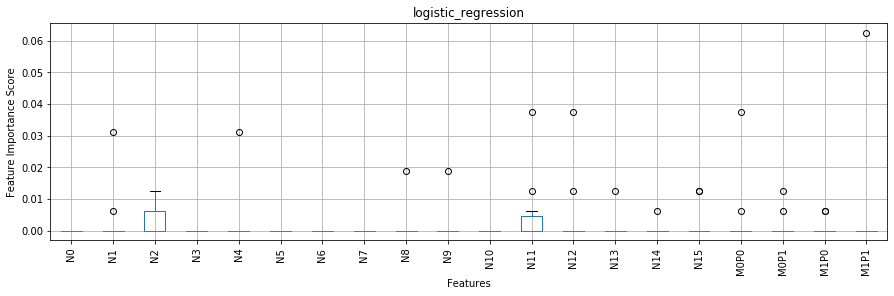

Text(0.5, 1.0, 'decision_tree')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x2054c767f08>,
 <a list of 20 Text xticklabel objects>)

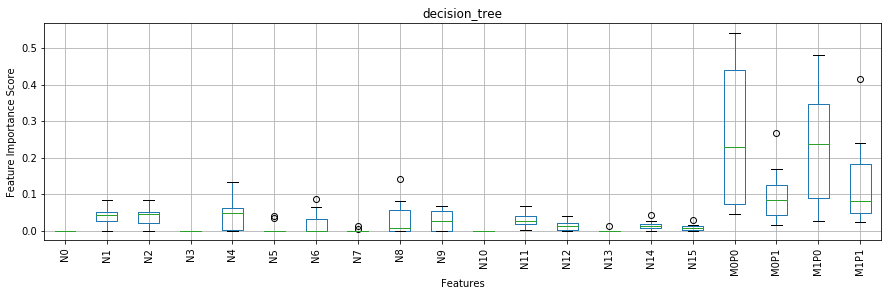

Text(0.5, 1.0, 'random_forest')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x20556213b08>,
 <a list of 20 Text xticklabel objects>)

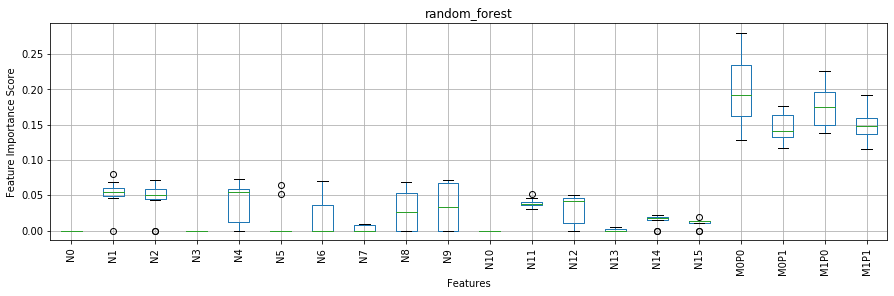

Text(0.5, 1.0, 'naive_bayes')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x20556514bc8>,
 <a list of 20 Text xticklabel objects>)

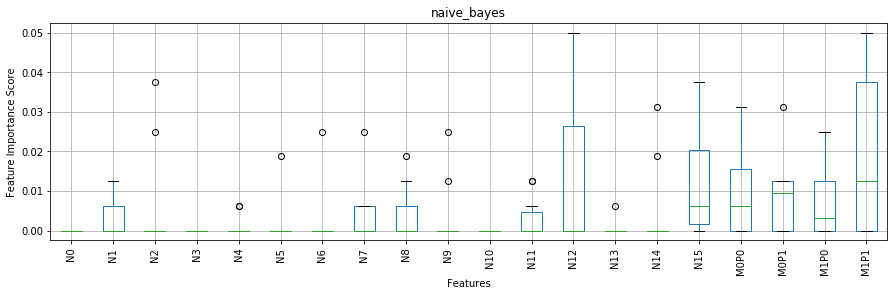

Text(0.5, 1.0, 'XGB')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x20556cff788>,
 <a list of 20 Text xticklabel objects>)

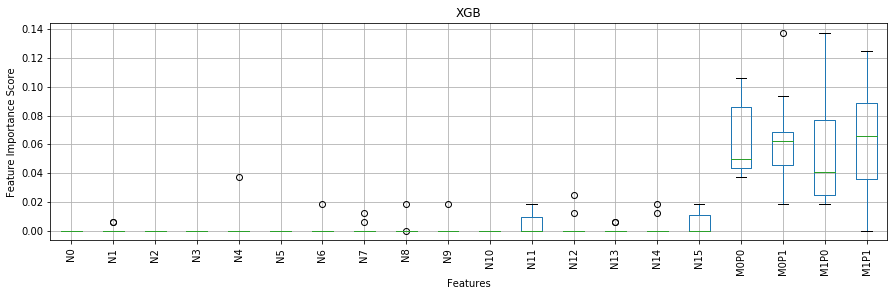

Text(0.5, 1.0, 'LGB')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x20557622b08>,
 <a list of 20 Text xticklabel objects>)

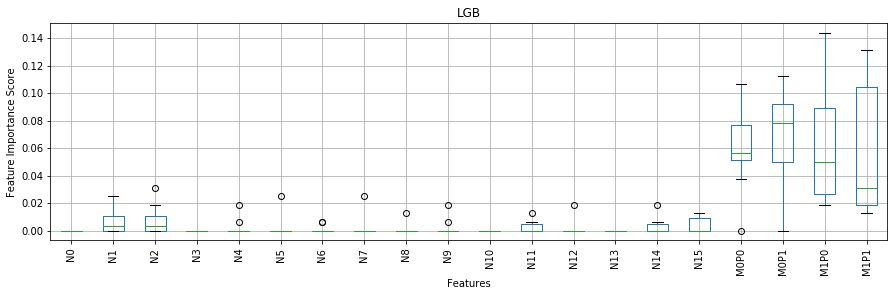

Text(0.5, 1.0, 'SVM')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x20557970bc8>,
 <a list of 20 Text xticklabel objects>)

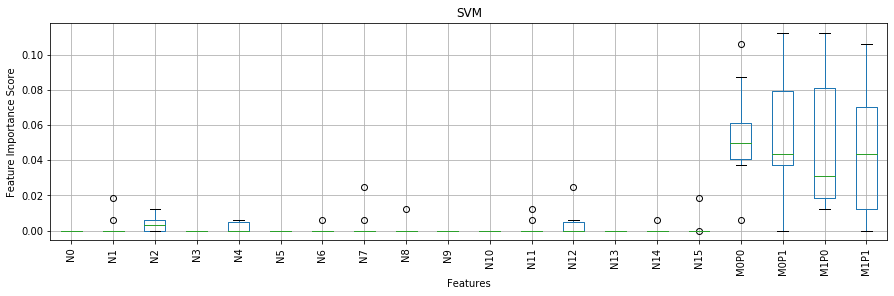

Text(0.5, 1.0, 'ANN')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x20556cc6088>,
 <a list of 20 Text xticklabel objects>)

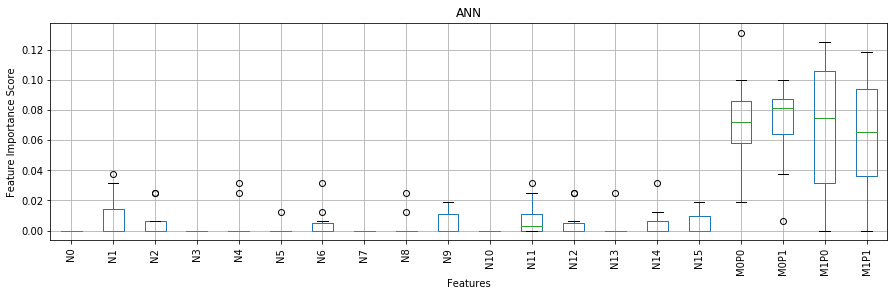

Text(0.5, 1.0, 'LCS')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x2054c8bf888>,
 <a list of 20 Text xticklabel objects>)

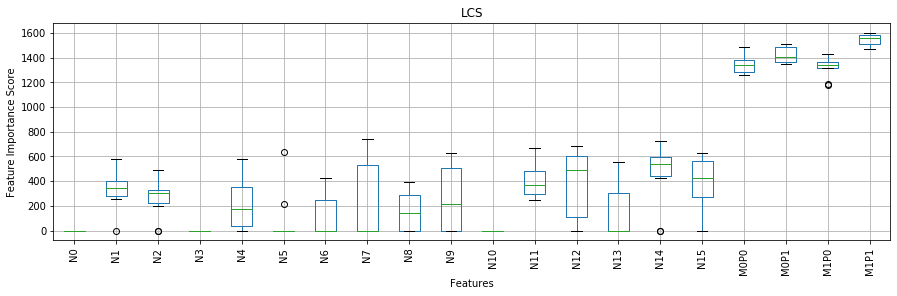

Text(0.5, 1.0, 'LCS_QRF')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x2054c8c7e88>,
 <a list of 20 Text xticklabel objects>)

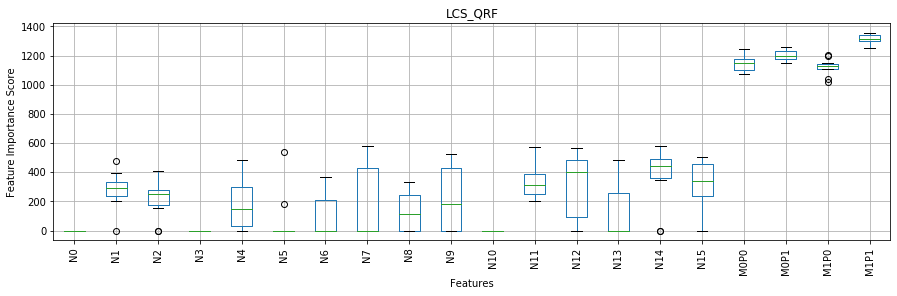

In [83]:
counter = 0
for df in fi_df_list:
    fig = plt.figure(figsize=(15,4))
    boxplot = df.boxplot(rot=90)
    plt.title(algorithmsToRun[counter])
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.xticks(np.arange(1,len(printfeatureNames)+1), printfeatureNames,rotation='vertical')
    plt.savefig((wd_path+output_folder+'/'+algorithmsToRun[counter]+'_boxplot_' + data_name), bbox_inches = "tight")
    plt.show()

    counter += 1

### Create Normalized dataframes with feature viz subsets

In [84]:
featuresToViz

feature_indexToViz = []
for i in featuresToViz:
    feature_indexToViz.append(all_feature_list.index(i))
feature_indexToViz

#Preserve features in original dataset order for consistency
top_fi_ave_norm_list = []
for i in range(len(algorithmsToRun)):
    tempList = []
    for j in range(len(fi_ave_norm_list[i])):
        if j in feature_indexToViz:
            tempList.append(fi_ave_norm_list[i][j])
    top_fi_ave_norm_list.append(tempList)

#Create feature name list in propper order
all_feature_listToViz = []
for j in (all_feature_list):
    if j in featuresToViz:
        all_feature_listToViz.append(j)
all_feature_listToViz

['N9',
 'N1',
 'N8',
 'M1P0',
 'M0P1',
 'N7',
 'N11',
 'N4',
 'M1P1',
 'N15',
 'N6',
 'N12',
 'N13',
 'N14',
 'N2',
 'M0P0',
 'N5']

[9, 1, 8, 18, 17, 7, 11, 4, 19, 15, 6, 12, 13, 14, 2, 16, 5]

['N1',
 'N2',
 'N4',
 'N5',
 'N6',
 'N7',
 'N8',
 'N9',
 'N11',
 'N12',
 'N13',
 'N14',
 'N15',
 'M0P0',
 'M0P1',
 'M1P0',
 'M1P1']

In [85]:
def compound_FI_plot(fi_list,algorithmsToRun,algColors,all_feature_listToViz,figName):
    
    # y-axis in bold
    rc('font', weight='bold', size=16)
    
    # The position of the bars on the x-axis
    r = all_feature_listToViz
    barWidth = 0.75
    plt.figure(figsize=(figx,figy))
            
    lines = None
    if len(algorithmsToRun) == 1:
        print("Plotting with 1 algorithm.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        lines = (p1[0])
        
    elif len(algorithmsToRun) == 2:
        print("Plotting with 2 algorithms.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0])
        
    elif len(algorithmsToRun) == 3:
        print("Plotting with 3 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0])
        
    elif len(algorithmsToRun) == 4:
        print("Plotting with 4 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0])
        
    elif len(algorithmsToRun) == 5:
        print("Plotting with 5 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0])
        
    elif len(algorithmsToRun) == 6:
        print("Plotting with 6 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0])
        
    elif len(algorithmsToRun) == 7:
        print("Plotting with 7 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0])

    elif len(algorithmsToRun) == 8:
        print("Plotting with 8 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0])
        
    elif len(algorithmsToRun) == 9:
        print("Plotting with 9 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0]) 

    elif len(algorithmsToRun) == 10:
        print("Plotting with 10 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        bottom10 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7], fi_list[8])]

        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        p10 = plt.bar(r, fi_list[9], bottom=bottom10, color=algColors[9], edgecolor='white', width=barWidth)

        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0],p10[0]) 
        
    # Custom X axis
    plt.xticks(np.arange(len(all_feature_listToViz)), all_feature_listToViz,rotation='vertical')
    plt.xlabel("Feature", fontsize=20)
    plt.ylabel("Normalized Feature Importance", fontsize=20)
    plt.legend(lines, methodsKey, loc=0,fontsize=16)
    plt.savefig(wd_path+output_folder+'/Compare_FI_'+figName+'_'+data_name, bbox_inches = 'tight')
    # Show graphic
    plt.show()

## Compound Feature Importance Plot (Normalized only)

Plotting with 10 algorithms.


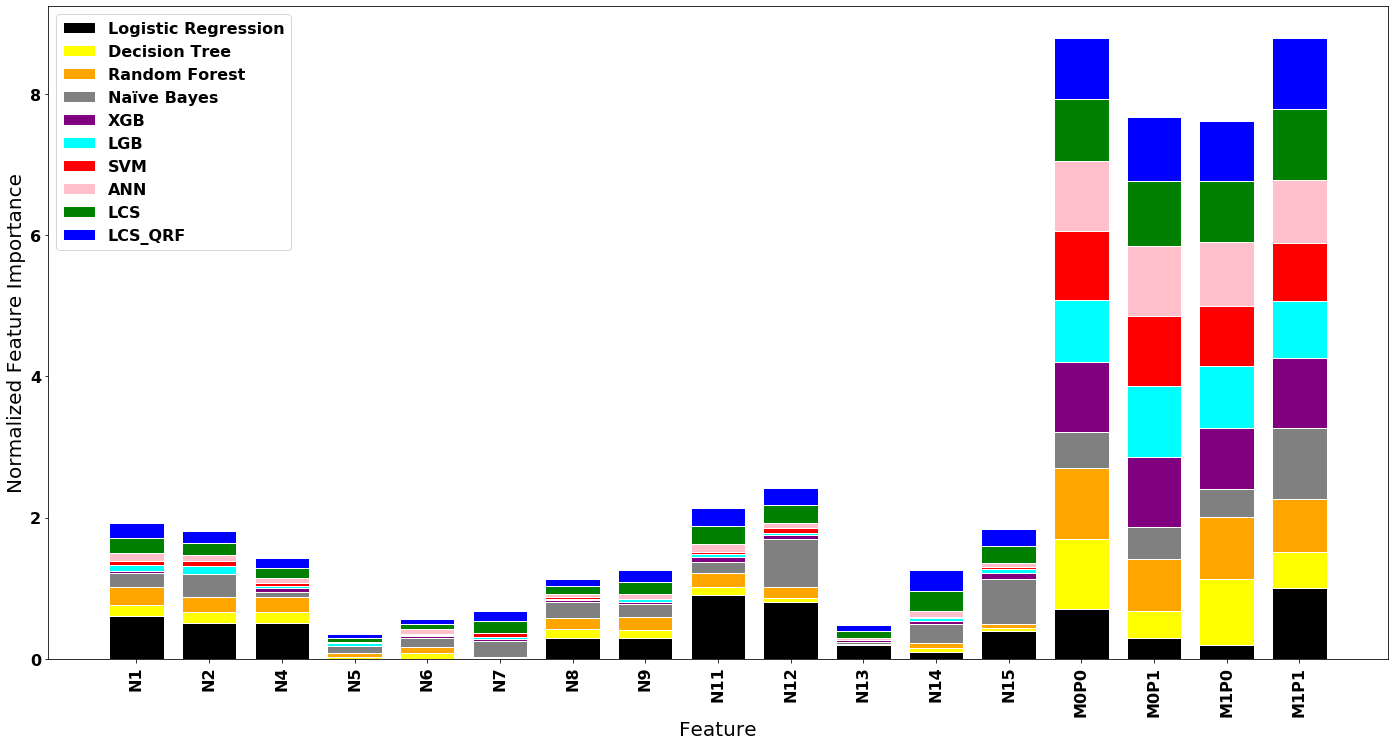

In [86]:
compound_FI_plot(top_fi_ave_norm_list,algorithmsToRun,algColors,all_feature_listToViz,'Norm')

##  Fraction Adjustment of Normalized Feature importances
- Each scores from each algorithm divided by sum of all scores

In [87]:
fracLists = []

for each in top_fi_ave_norm_list:
    fracList = []
    for i in range(len(each)):
        fracList.append((each[i]/(sum(each))))
    fracLists.append(fracList)

## Compound Feature Importance Plot (Normalized + Fraction Adjustment)

Plotting with 10 algorithms.


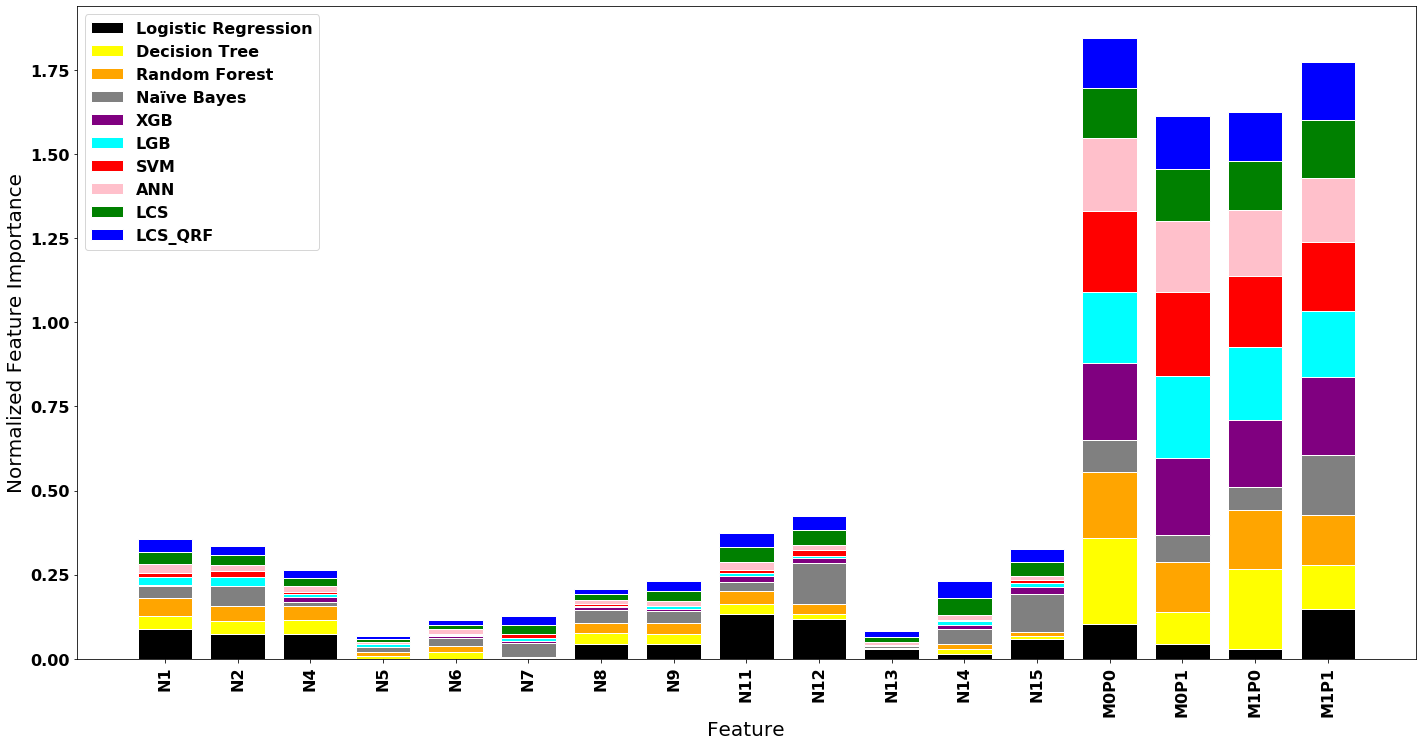

In [88]:
compound_FI_plot(fracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac')

##  Performance Weighting of Normalized Feature importances

In [89]:
#Prepare weights
weights = []

# replace all balanced accuraces <=.5 with 0
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] <= .5:
        ave_metric_list[i] = 0

# normalize balanced accuracies
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] == 0:
        weights.append(0)
    else:
        weights.append((ave_metric_list[i]-0.5)/0.5)
        
        
# Weight normalized feature importances
weightedLists = []

for i in range(len(top_fi_ave_norm_list)):
    weightList = np.multiply(weights[i],top_fi_ave_norm_list[i]).tolist()
    weightedLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Perf. Weight Adjustment)

Plotting with 10 algorithms.


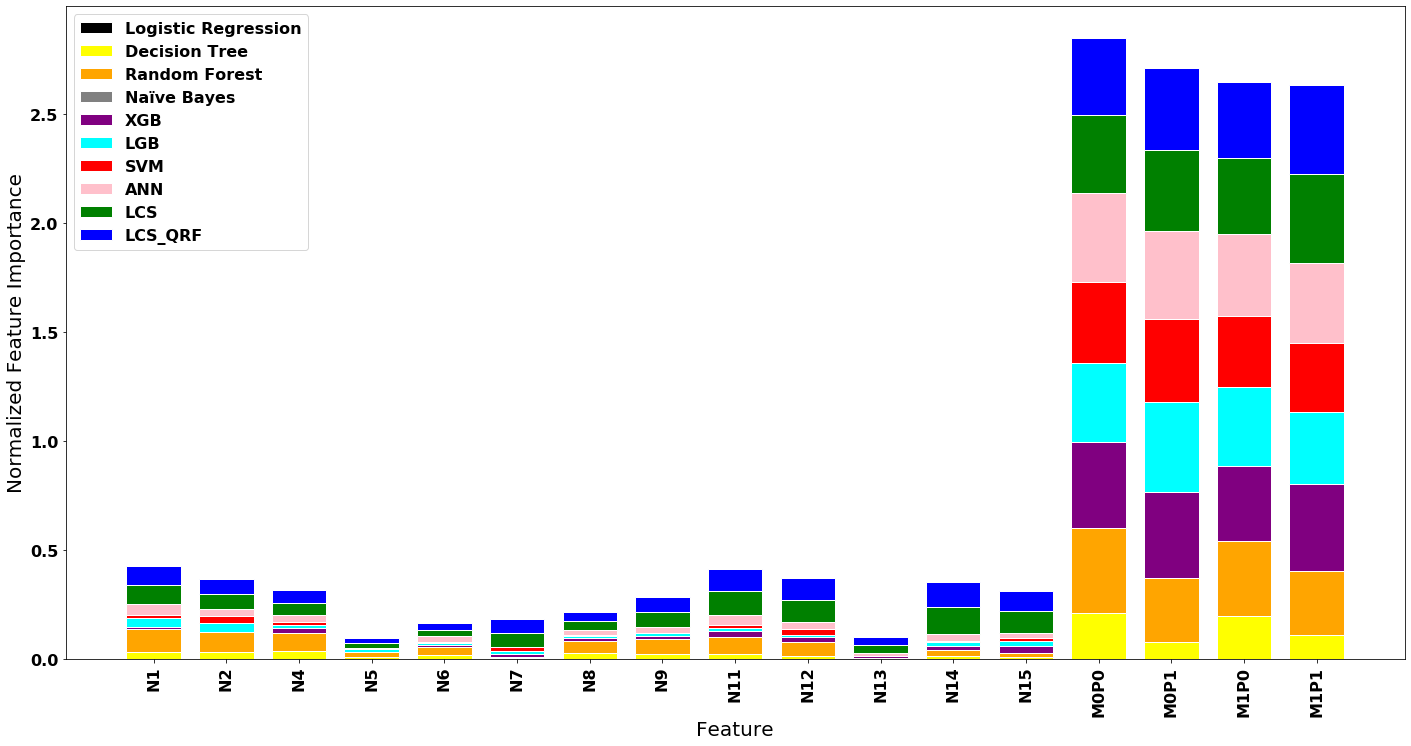

In [90]:
compound_FI_plot(weightedLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Weight')

##  Performance Weighting of Fract. Adj. and Normalized Feature importances

In [91]:
# Weight normalized feature importances
weightedFracLists = []

for i in range(len(fracLists)):
    weightList = np.multiply(weights[i],fracLists[i]).tolist()
    weightedFracLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Frac. + Perf. Weight Adjustment)

Plotting with 10 algorithms.


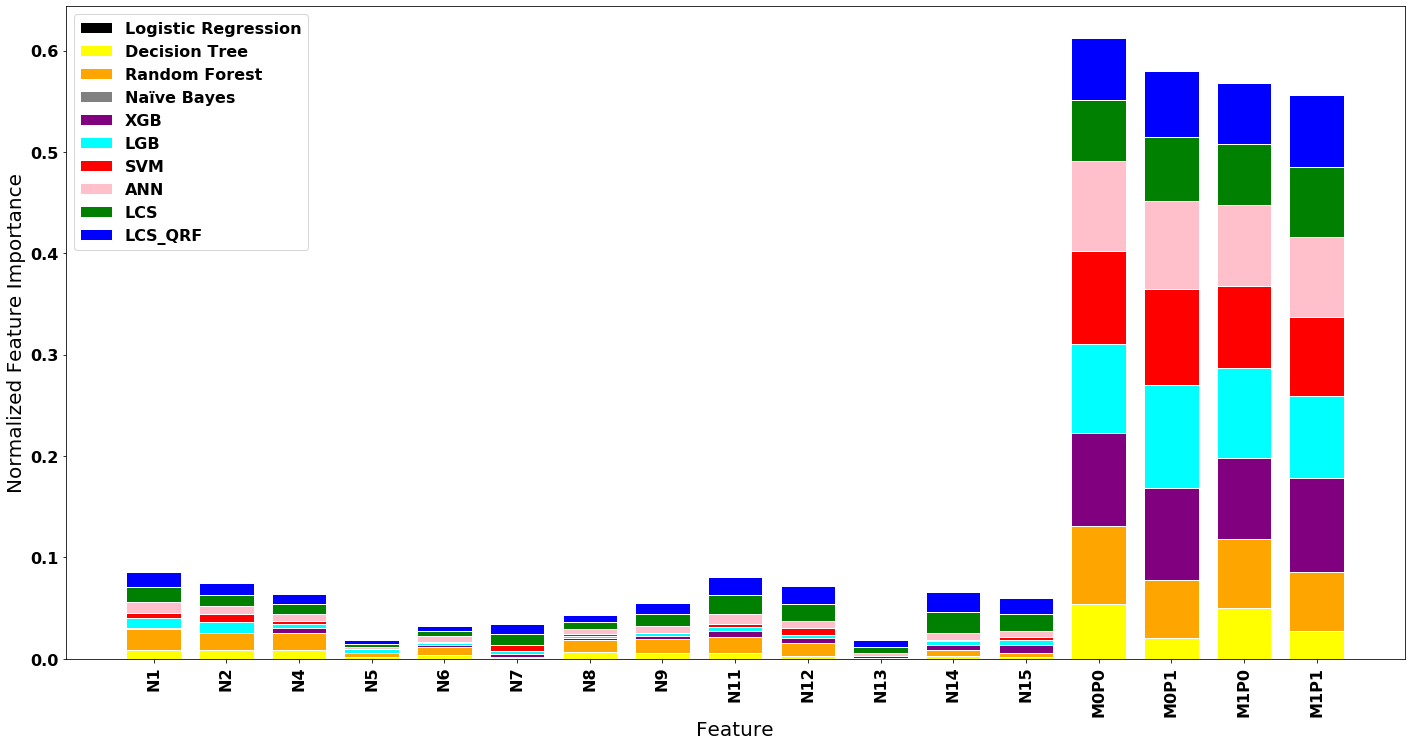

In [92]:
compound_FI_plot(weightedFracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac_Weight')

# Runtime Report

In [93]:
notebook_elapsed_time = time.time() - notebook_start_time
print('Pipeline Run Time: '+ str(notebook_elapsed_time))
run_time_dict['pipeline'] = notebook_elapsed_time
print(run_time_dict)

Pipeline Run Time: 20834.284729719162
{'mutual_information': 2.669032096862793, 'multisurf': 238.84040927886963, 'logistic_regression': 176.57083296775818, 'decision_tree': 163.15084528923035, 'random_forest': 1865.3773083686829, 'naive_bayes': 1.690755844116211, 'XGB': 1895.3840970993042, 'LGB': 527.0324597358704, 'SVM': 2071.1873693466187, 'ANN': 1634.722306728363, 'LCS': 12221.531257867813, 'pipeline': 20834.284729719162}
